Using TensorFlow backend.


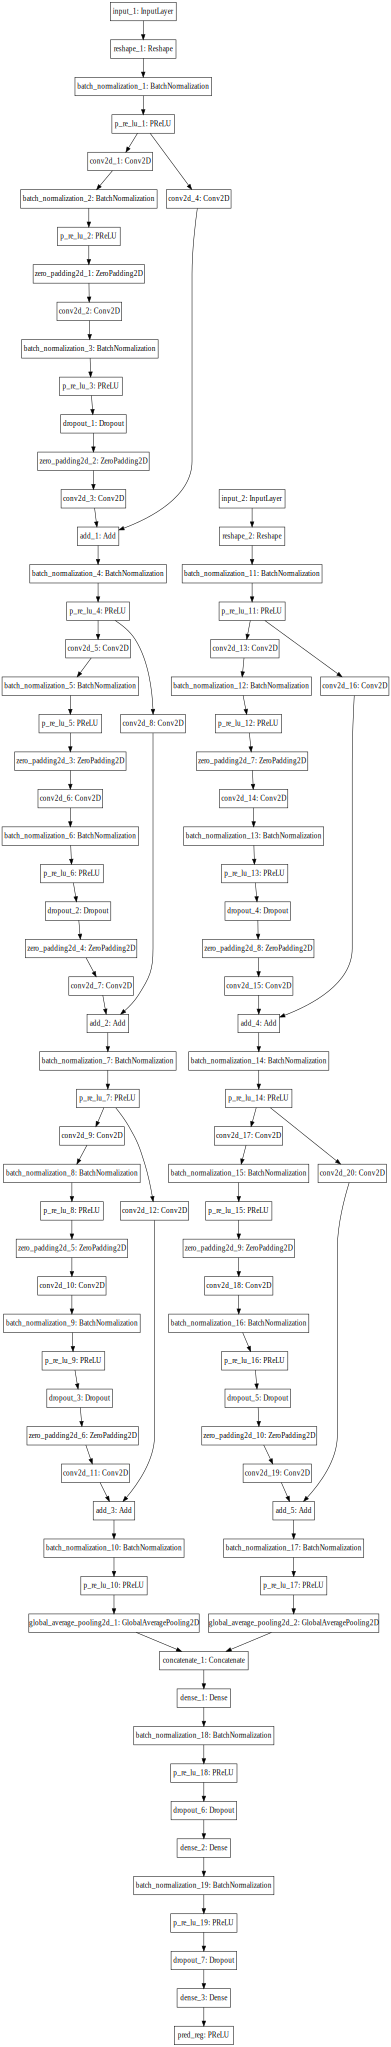

In [1]:
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_json

#for i in os.listdir()
json_file = open('/Users/rudy_layko/mhc/Archive/cnn2Conv2D_bal/model.json', 'r')
loaded_model_json = json_file.read()
#loaded_model_json.load_weights("/Users/rudy_layko/mhc/mhystic/models/15mers/bilstm32/model.1.hdf5")
json_file.close()
net_model = model_from_json(loaded_model_json)
SVG(model_to_dot(net_model).create(prog='dot', format='svg'))

In [9]:
net_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 34, 20)        0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 34, 20, 1)     0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 34, 20, 1)     4                                            
____________________________________________________________________________________________________
p_re_lu_1 (PReLU)                (None, 34, 20, 1)     680                                          
___________________________________________________________________________________________

In [3]:
input_fld = '/Users/rudy_layko/mhc/Archive/cnn2Conv2D_bal/'
weight_file = 'model.json'
num_output = 1
write_graph_def_ascii_flag = True
prefix_output_node_names_of_final_network = 'output_node'
output_graph_name = 'constant_graph_weights.pb'

In [4]:
from keras.models import load_model
import tensorflow as tf
import os
import os.path as osp
from keras import backend as K

output_fld = 'tensorflow_model/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)
weight_file_path = osp.join(input_fld, weight_file)

In [5]:
K.set_learning_phase(0)

pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(net_model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

output nodes names are:  ['output_node0']


In [6]:
sess = K.get_session()

if write_graph_def_ascii_flag:
    f = 'only_the_graph_def.pb.ascii'
    tf.train.write_graph(sess.graph.as_graph_def(), output_fld, f, as_text=True)
    print('saved the graph definition in ascii format at: ', osp.join(output_fld, f))

saved the graph definition in ascii format at:  tensorflow_model/only_the_graph_def.pb.ascii


In [7]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

INFO:tensorflow:Froze 142 variables.
Converted 142 variables to const ops.
saved the constant graph (ready for inference) at:  tensorflow_model/constant_graph_weights.pb


In [8]:
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='./tensorflow_model/constant_graph_weights.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='./logs/tests/1/'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

In [24]:
import keras.backend as K
import numpy as np
from keras.layers import merge, Dense
from keras.models import Input, Model, Sequential

Using TensorFlow backend.


In [25]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

In [25]:
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps, dir_to_save=None):
    
    batch_size = activation_maps[0].shape[0]
    #assert batch_size == 1, 'One image at a time to visualize.'
    a = 0 
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        print(shape)
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.figure(figsize=(16, 9))
        try:
            plt.title(net_model.layers[a].name)
            cur_name = net_model.layers[a].name
        except:
            pass
        a+=1
        plt.imshow(activations, interpolation='None', cmap='rainbow', alpha=0.7)
        plt.colorbar()
        if dir_to_save:
            plt.savefig("./{}/{}.png".format(dir_to_save, cur_name), dpi=300)


In [9]:
import pandas as pd
import numpy as np

In [17]:
data = pd.read_csv("./mhystic/data/human_df.csv")
x_mhc = np.load("./mhystic/x_mhc.npy")
x_pep = np.load("./mhystic/x_pep.npy")

In [18]:
strong_pep = x_pep[468]
weak_pep = x_pep[28]
ex_mhc = x_mhc[3]

In [22]:
weak_acts = get_activations(net_model, [ex_mhc.reshape(-1, 34, 20), weak_pep.reshape(-1, 9, 20)], print_shape_only=False)
strong_acts = get_activations(net_model, [ex_mhc.reshape(-1, 34, 20), strong_pep.reshape(-1, 9, 20)], print_shape_only=False)

----- activations -----
[[[ -5.01835155e+00   1.19885516e+00  -2.76005507e+00  -8.23536396e-01
    -5.58922482e+00  -2.51307058e+00  -1.14142679e-01  -2.31211019e+00
     4.83858824e+00  -9.72263873e-01   1.23188698e+00  -3.04578161e+00
    -2.13895154e+00   1.89773071e+00  -6.26127303e-01   1.33312011e+00
    -1.96329013e-01  -1.57227600e+00   4.64530438e-01  -2.34676862e+00]
  [ -3.90377855e+00  -7.82713950e-01  -2.45461202e+00  -1.36488938e+00
    -5.94103289e+00  -1.81083059e+00  -1.78998366e-01   5.44472277e-01
     2.92822886e+00   1.16734946e+00  -2.48012829e+00   1.63677466e+00
     2.36451074e-01   1.65228307e+00  -9.75134730e-01  -3.85057068e+00
     1.39610839e+00  -6.74522924e+00   5.71650791e+00  -3.84093118e+00]
  [  3.45836210e+00   8.82432640e-01  -1.78137112e+00   1.38686347e+00
     5.65158319e+00   5.58196211e+00  -5.45835686e+00  -4.58606291e+00
    -8.85417044e-01  -1.27687204e+00  -3.66867161e+00   5.28011703e+00
    -2.00757194e+00  -5.86399603e+00   1.49760306e+

   [ 0.32119831  0.          0.         ...,  0.36675179  0.          0.        ]]]]
[[[[ 1.26747835  0.          0.         ...,  0.          0.          1.25238287]
   [ 0.94506937  0.          0.49601382 ...,  0.7638405   0.          0.        ]
   [ 0.76283646  0.          0.         ...,  0.          1.33358836  0.        ]
   ..., 
   [ 1.05046558  0.          0.         ...,  0.          0.55369145
     0.14584202]
   [ 0.80607688  0.          0.6235947  ...,  0.8233366   0.          0.        ]
   [ 0.51242357  0.          0.03460976 ...,  0.          1.95382905  0.        ]]

  [[ 0.78372121  0.          0.45295861 ...,  0.          0.          0.10845832]
   [ 0.          0.          0.         ...,  0.          0.          0.        ]
   [ 3.16328502  0.47907278  0.         ...,  0.31936365  0.          2.82544923]
   ..., 
   [ 1.22641242  0.          0.         ...,  0.          0.0180201   0.        ]
   [ 0.74176168  0.          0.         ...,  0.          0.          0

[[[ -5.01835155e+00   1.19885516e+00  -2.76005507e+00  -8.23536396e-01
    -5.58922482e+00  -2.51307058e+00  -1.14142679e-01  -2.31211019e+00
     4.83858824e+00  -9.72263873e-01   1.23188698e+00  -3.04578161e+00
    -2.13895154e+00   1.89773071e+00  -6.26127303e-01   1.33312011e+00
    -1.96329013e-01  -1.57227600e+00   4.64530438e-01  -2.34676862e+00]
  [ -3.90377855e+00  -7.82713950e-01  -2.45461202e+00  -1.36488938e+00
    -5.94103289e+00  -1.81083059e+00  -1.78998366e-01   5.44472277e-01
     2.92822886e+00   1.16734946e+00  -2.48012829e+00   1.63677466e+00
     2.36451074e-01   1.65228307e+00  -9.75134730e-01  -3.85057068e+00
     1.39610839e+00  -6.74522924e+00   5.71650791e+00  -3.84093118e+00]
  [  3.45836210e+00   8.82432640e-01  -1.78137112e+00   1.38686347e+00
     5.65158319e+00   5.58196211e+00  -5.45835686e+00  -4.58606291e+00
    -8.85417044e-01  -1.27687204e+00  -3.66867161e+00   5.28011703e+00
    -2.00757194e+00  -5.86399603e+00   1.49760306e+00  -4.89523745e+00
    

      5.26960850e-01  -4.51010197e-01   6.02382183e-01]]]]
[[[[ -5.01835155e+00]
   [  1.19885516e+00]
   [ -2.76005507e+00]
   [ -8.23536396e-01]
   [ -5.58922482e+00]
   [ -2.51307058e+00]
   [ -1.14142679e-01]
   [ -2.31211019e+00]
   [  4.83858824e+00]
   [ -9.72263873e-01]
   [  1.23188698e+00]
   [ -3.04578161e+00]
   [ -2.13895154e+00]
   [  1.89773071e+00]
   [ -6.26127303e-01]
   [  1.33312011e+00]
   [ -1.96329013e-01]
   [ -1.57227600e+00]
   [  4.64530438e-01]
   [ -2.34676862e+00]]

  [[ -1.39267004e+00]
   [ -2.58607954e-01]
   [  3.30058265e+00]
   [  2.32660651e+00]
   [  2.18219900e+00]
   [  1.62714028e+00]
   [ -2.52450299e+00]
   [  4.43988085e+00]
   [  7.02636898e-01]
   [  3.00387472e-01]
   [ -4.28148508e+00]
   [  5.76031637e+00]
   [ -1.51648533e+00]
   [  3.19228745e+00]
   [ -3.44033766e+00]
   [ -5.13260078e+00]
   [ -2.13382006e+00]
   [ -7.51526237e-01]
   [  2.61151505e+00]
   [  4.01277113e+00]]

  [[ -3.01637745e+00]
   [ -2.95890188e+00]
   [  2.91332

Displaying activation map 0
(34, 20)
Displaying activation map 1
(1, 34, 20, 1)
Displaying activation map 2
(1, 34, 20, 1)
Displaying activation map 3
(1, 34, 20, 1)
Displaying activation map 4
(1, 34, 20, 8)
Displaying activation map 5
(1, 34, 20, 8)
Displaying activation map 6
(1, 34, 20, 8)
Displaying activation map 7
(1, 36, 22, 8)
Displaying activation map 8
(1, 34, 20, 8)
Displaying activation map 9
(1, 34, 20, 8)
Displaying activation map 10
(1, 34, 20, 8)
Displaying activation map 11
(1, 34, 20, 8)
Displaying activation map 12
(1, 36, 22, 8)
Displaying activation map 13
(9, 20)
Displaying activation map 14
(1, 34, 20, 16)
Displaying activation map 15
(1, 34, 20, 16)
Displaying activation map 16
(1, 9, 20, 1)
Displaying activation map 17
(1, 34, 20, 16)
Displaying activation map 18
(1, 9, 20, 1)
Displaying activation map 19
(1, 34, 20, 16)
Displaying activation map 20
(1, 9, 20, 1)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Displaying activation map 21
(1, 34, 20, 16)
Displaying activation map 22
(1, 9, 20, 8)
Displaying activation map 23
(1, 34, 20, 16)
Displaying activation map 24
(1, 9, 20, 8)
Displaying activation map 25
(1, 34, 20, 16)
Displaying activation map 26
(1, 9, 20, 8)
Displaying activation map 27
(1, 34, 20, 16)
Displaying activation map 28
(1, 11, 22, 8)
Displaying activation map 29
(1, 36, 22, 16)
Displaying activation map 30
(1, 9, 20, 8)
Displaying activation map 31
(1, 34, 20, 16)
Displaying activation map 32
(1, 9, 20, 8)
Displaying activation map 33
(1, 34, 20, 16)
Displaying activation map 34
(1, 9, 20, 8)
Displaying activation map 35
(1, 34, 20, 16)
Displaying activation map 36
(1, 9, 20, 8)
Displaying activation map 37
(1, 34, 20, 16)
Displaying activation map 38
(1, 11, 22, 8)
Displaying activation map 39
(1, 36, 22, 16)
Displaying activation map 40
(1, 9, 20, 16)
Displaying activation map 41
(1, 9, 20, 16)
Displaying activation map 42
(1, 34, 20, 32)
Displaying activation map 4

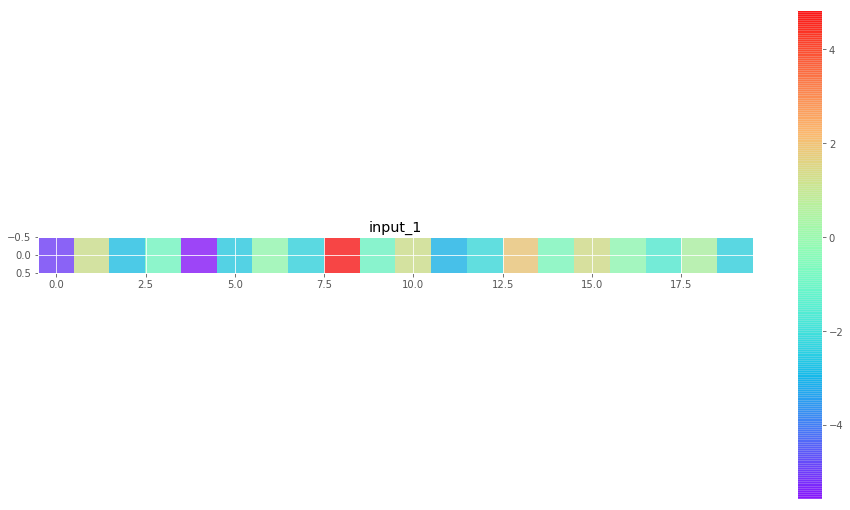

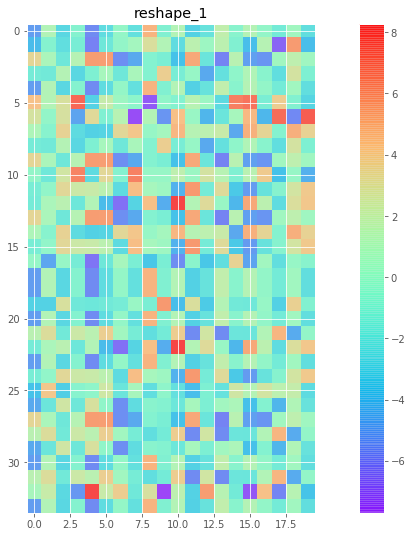

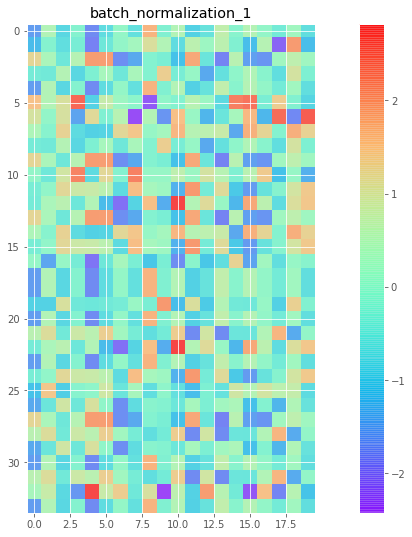

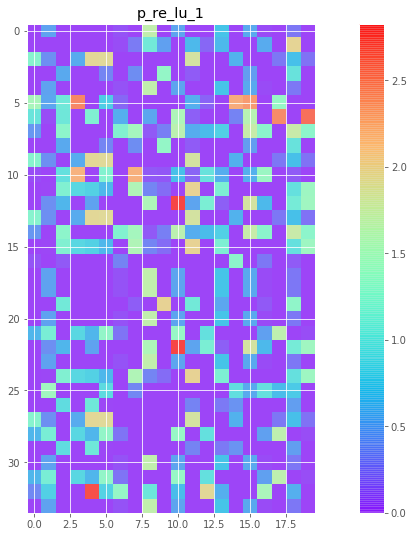

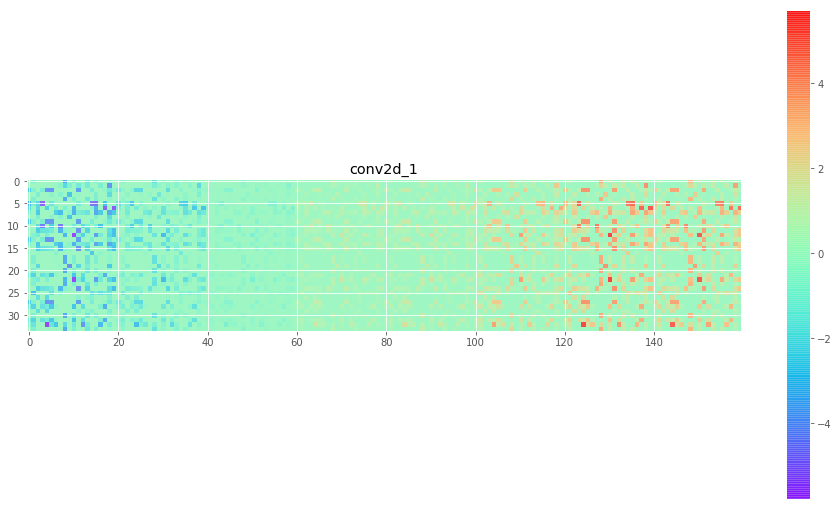

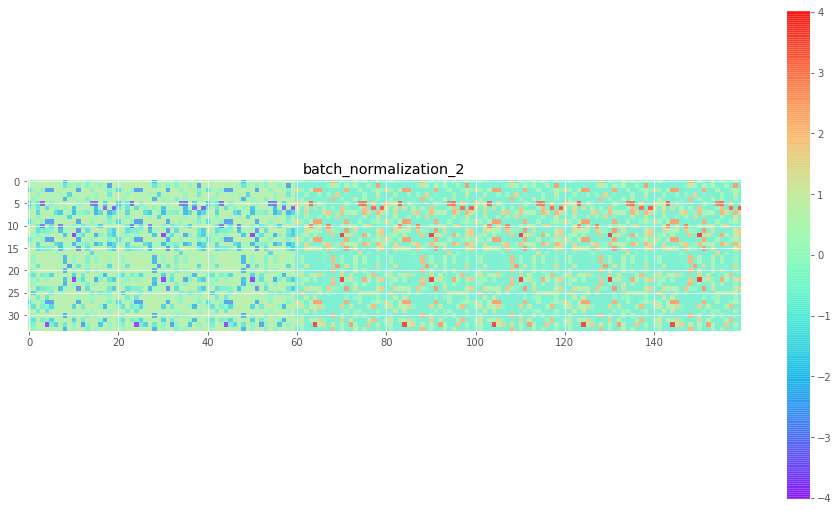

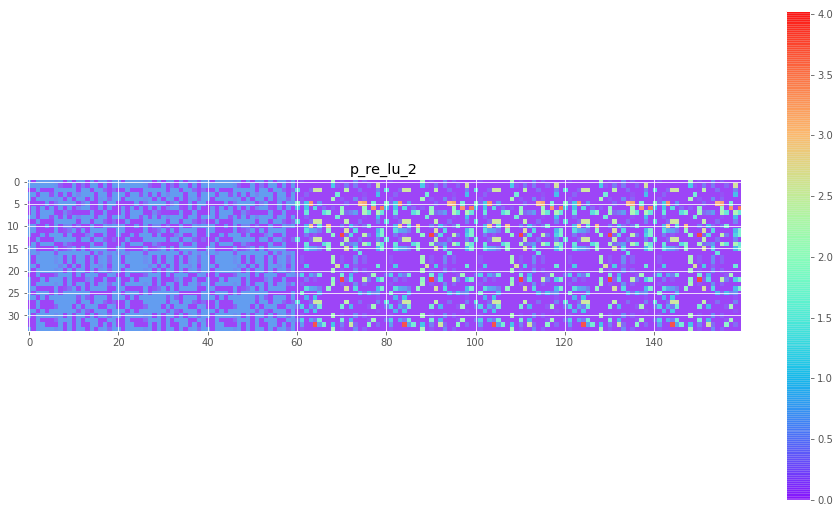

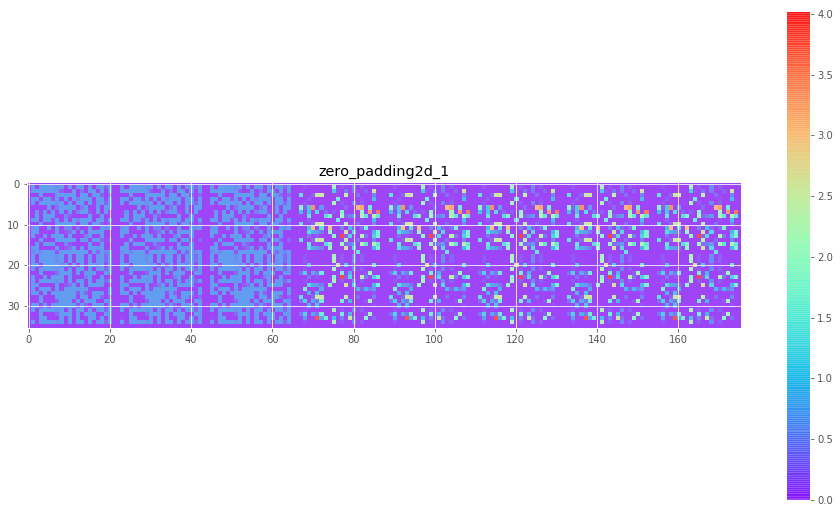

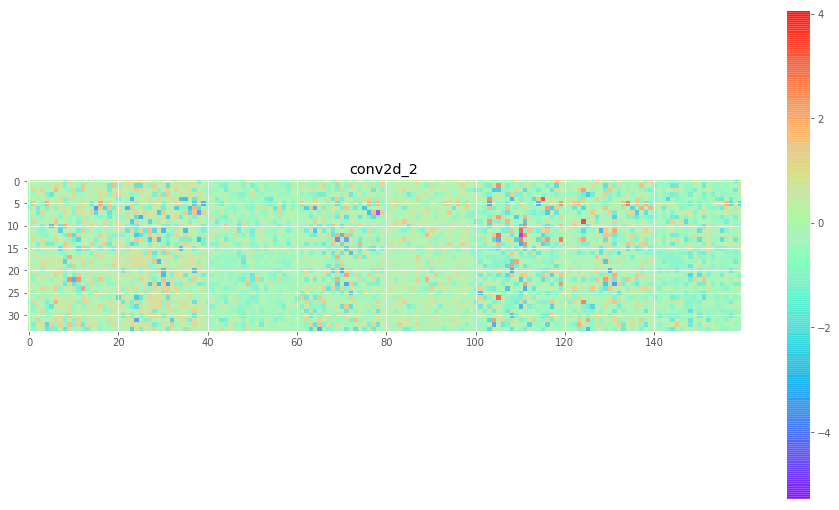

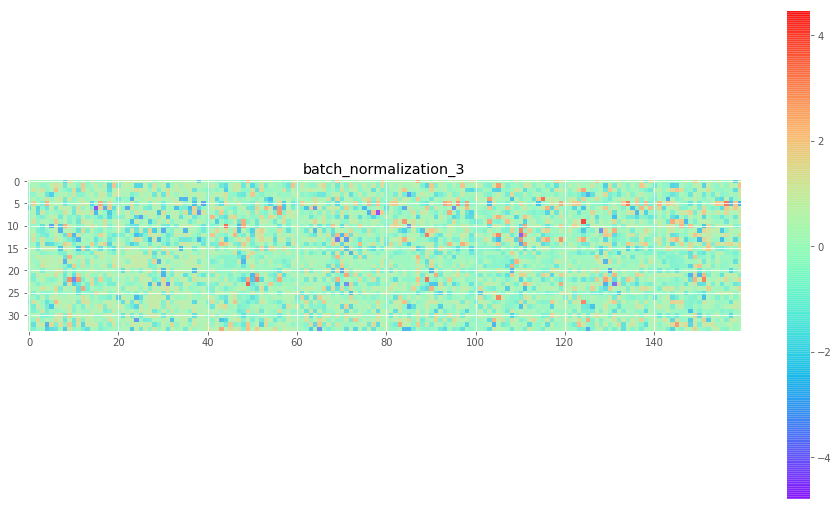

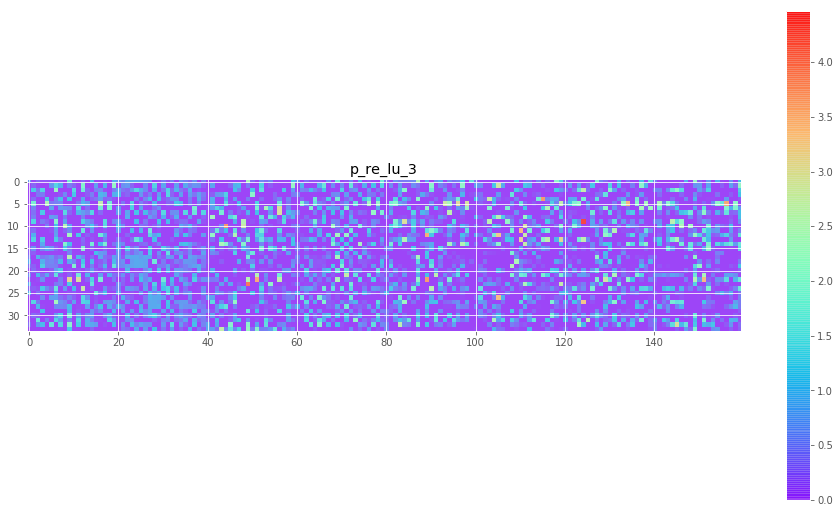

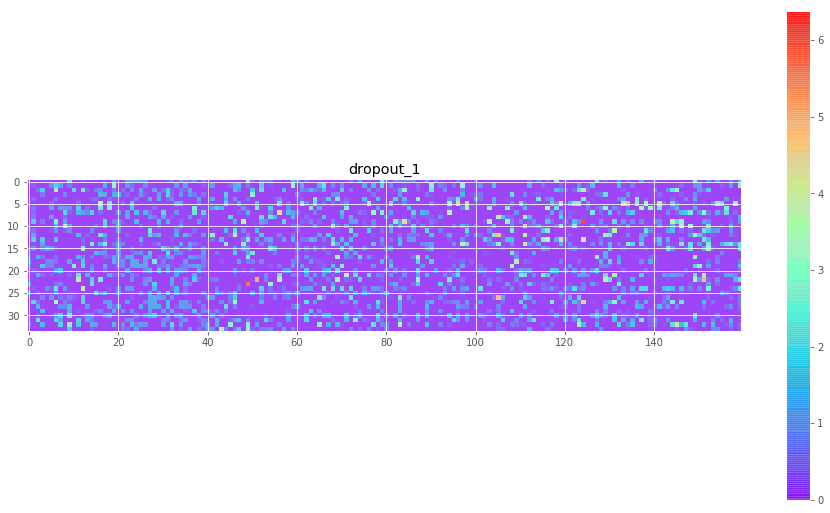

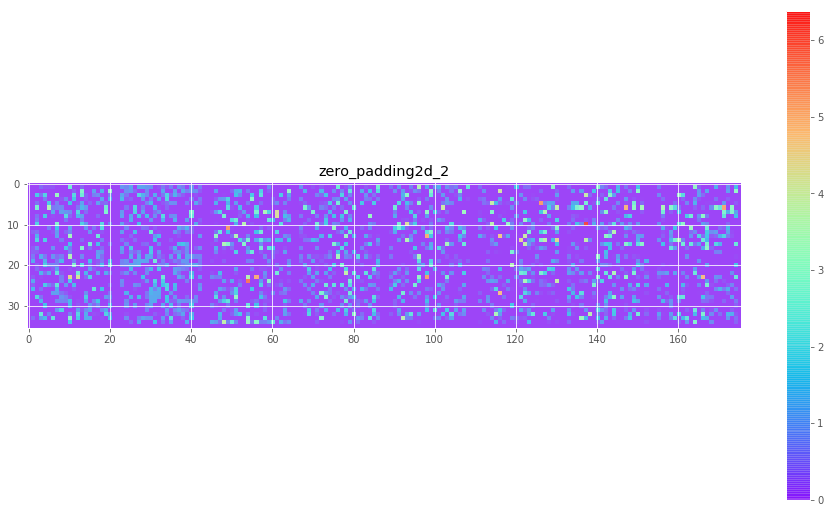

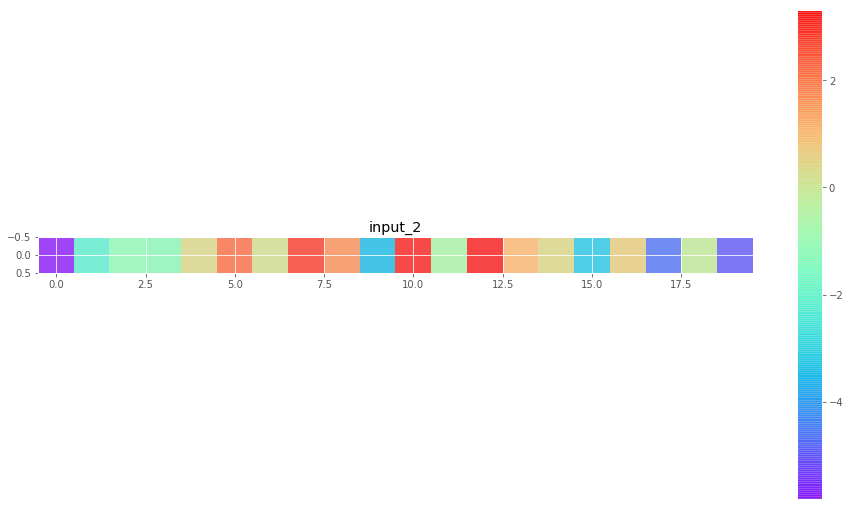

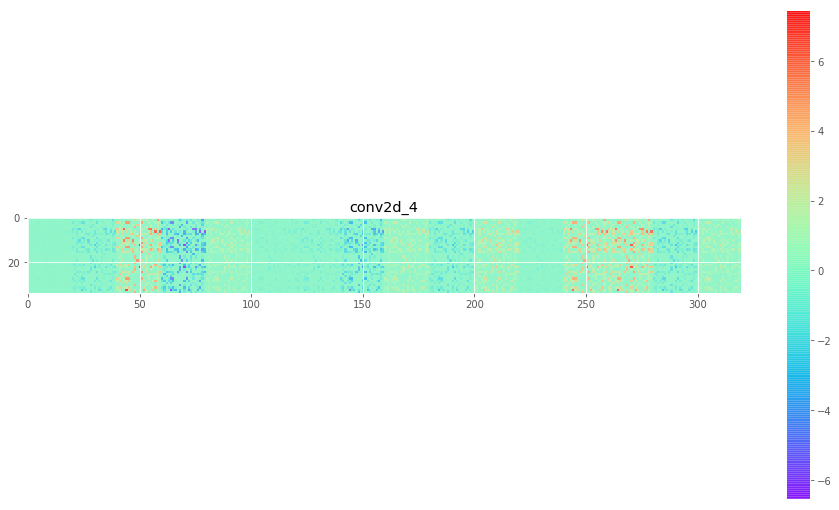

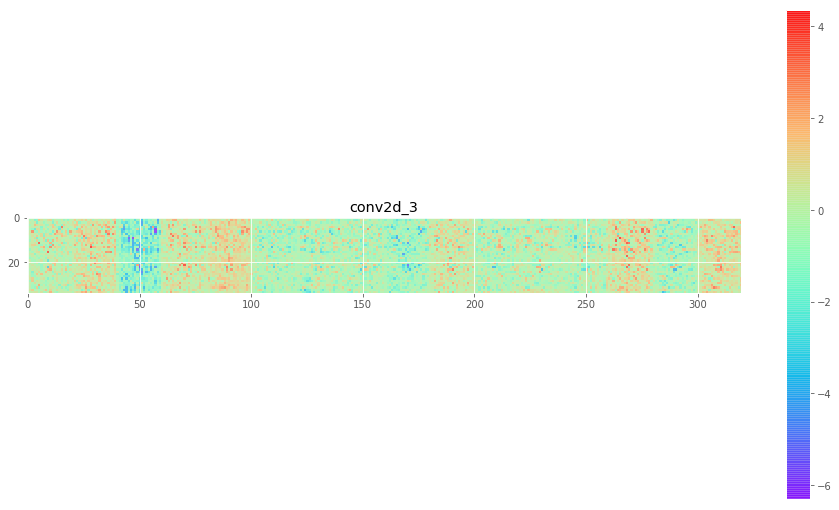

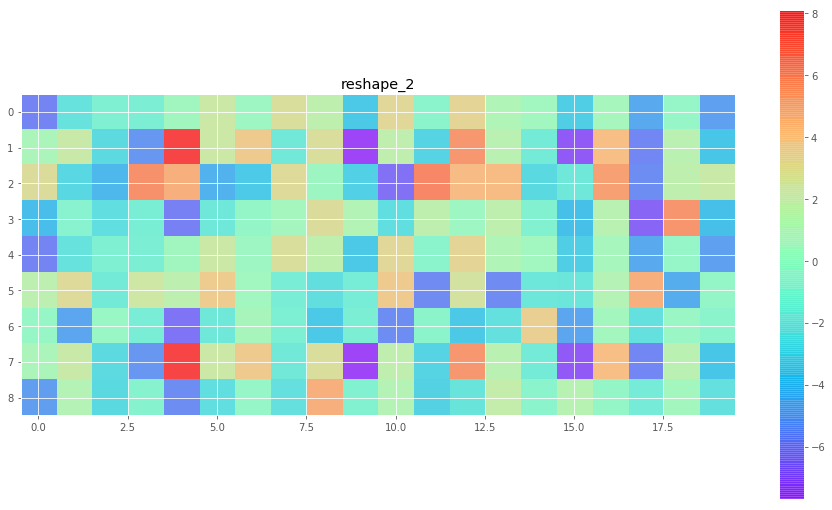

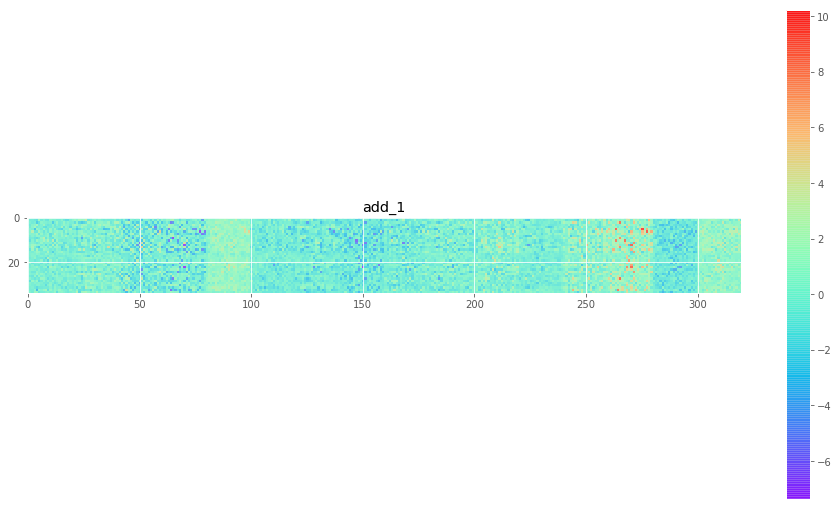

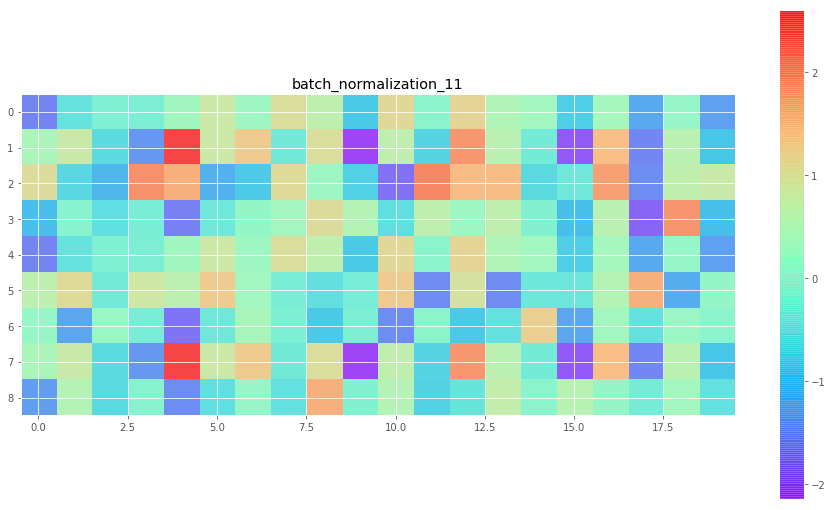

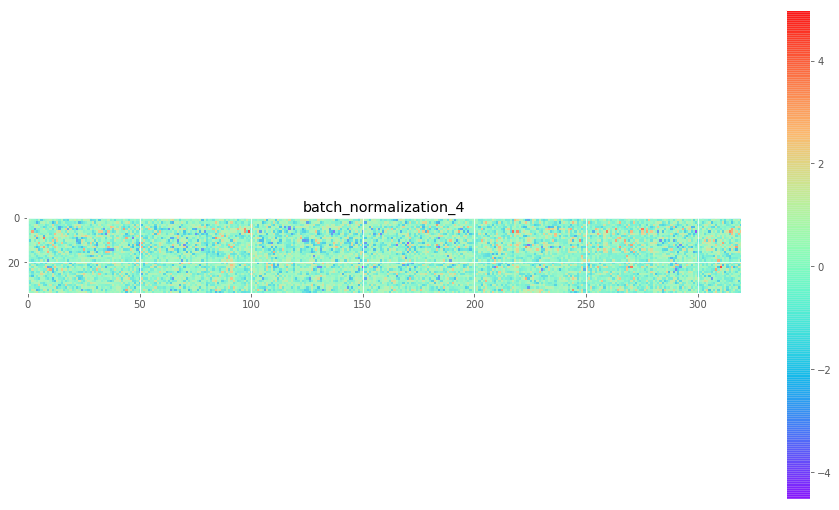

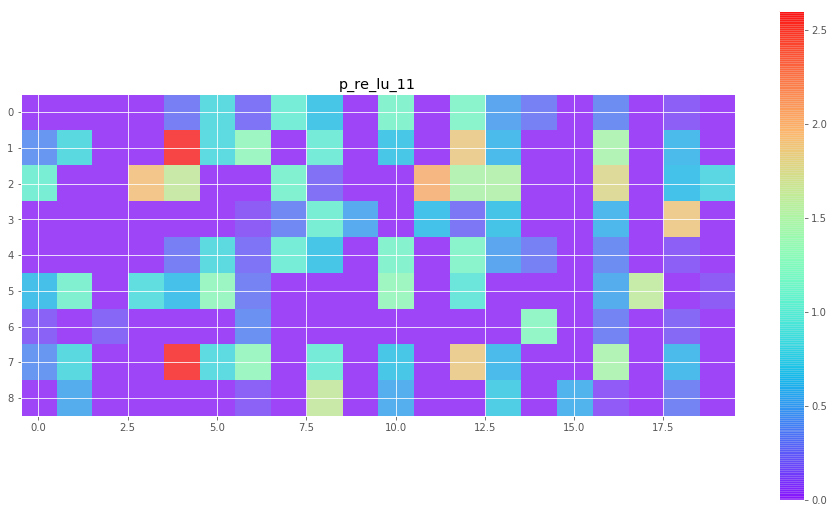

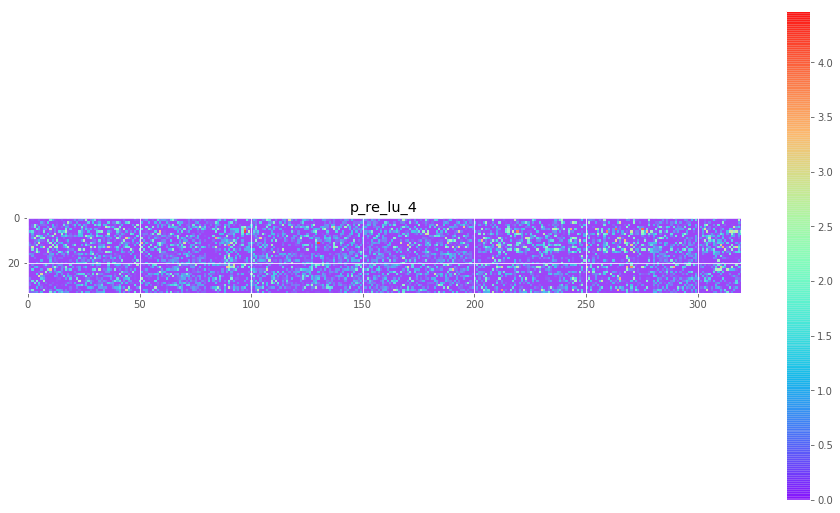

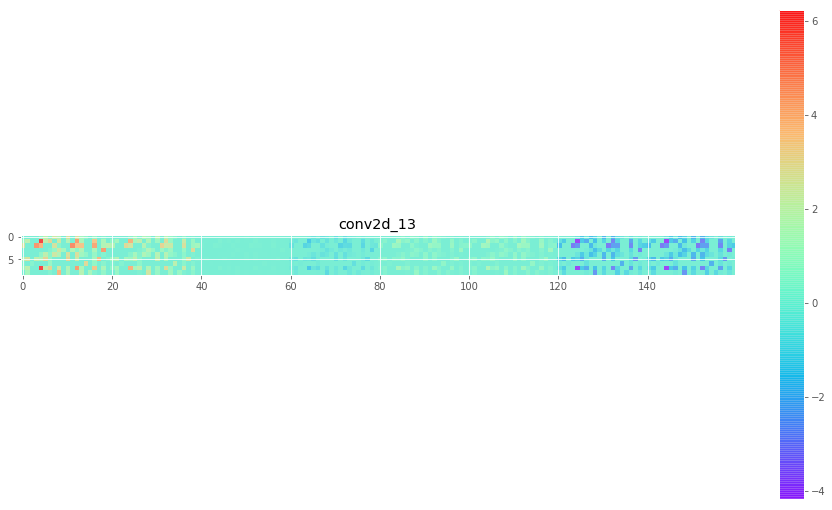

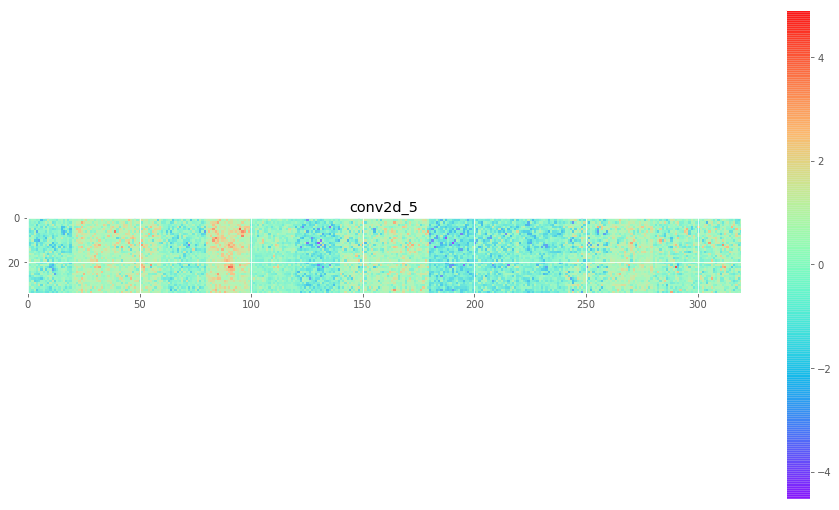

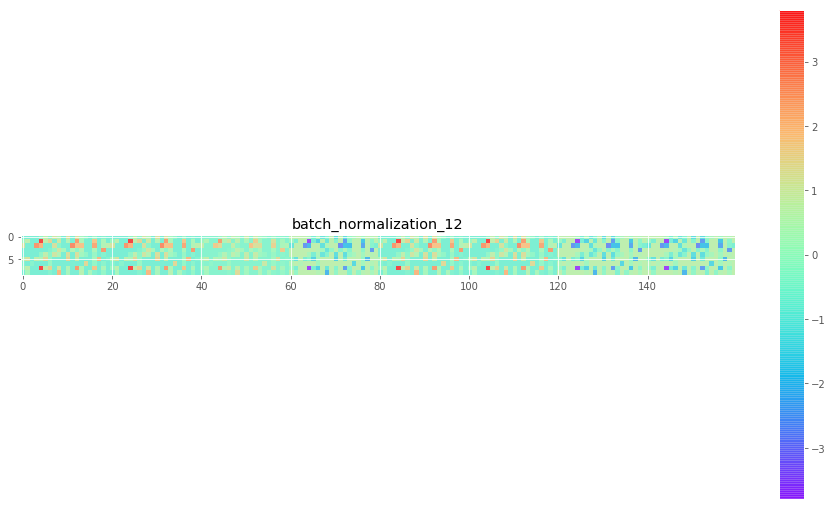

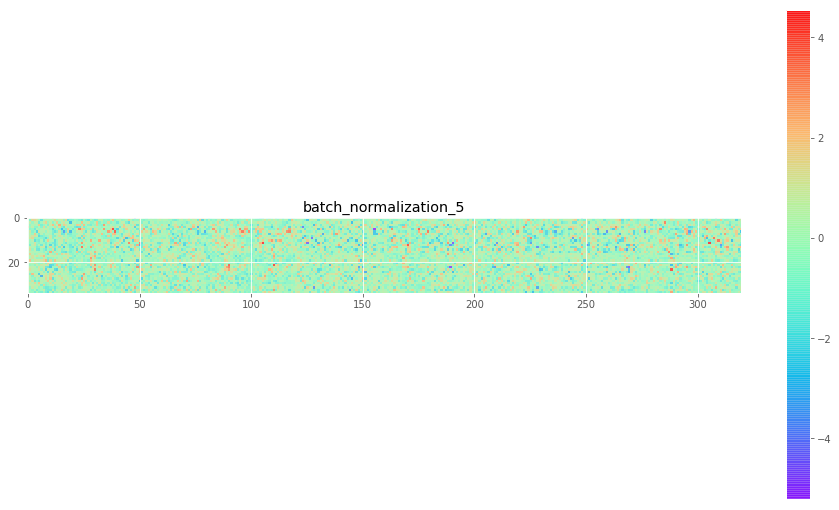

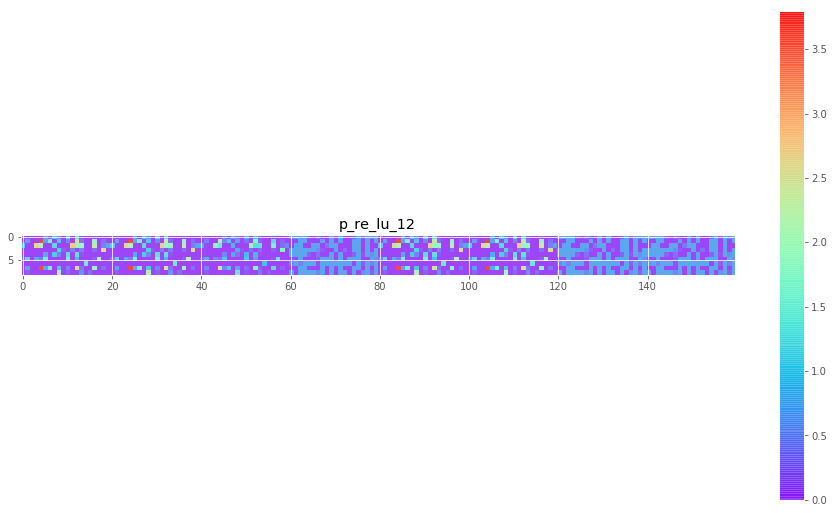

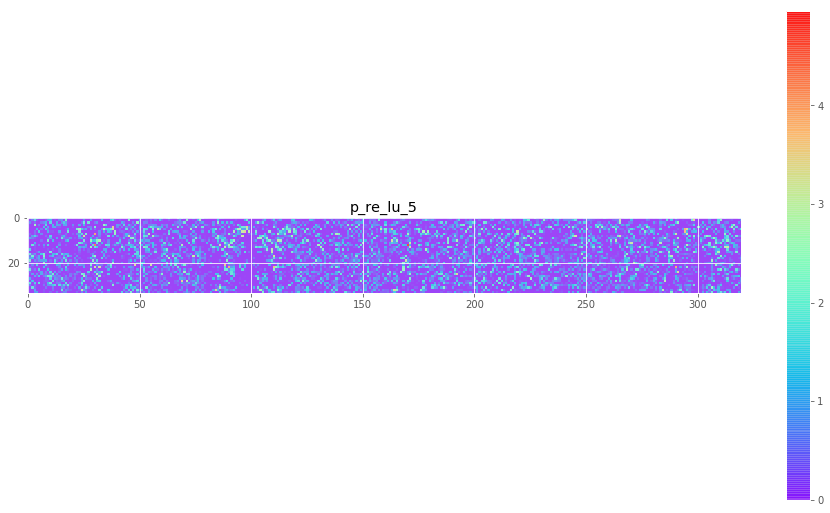

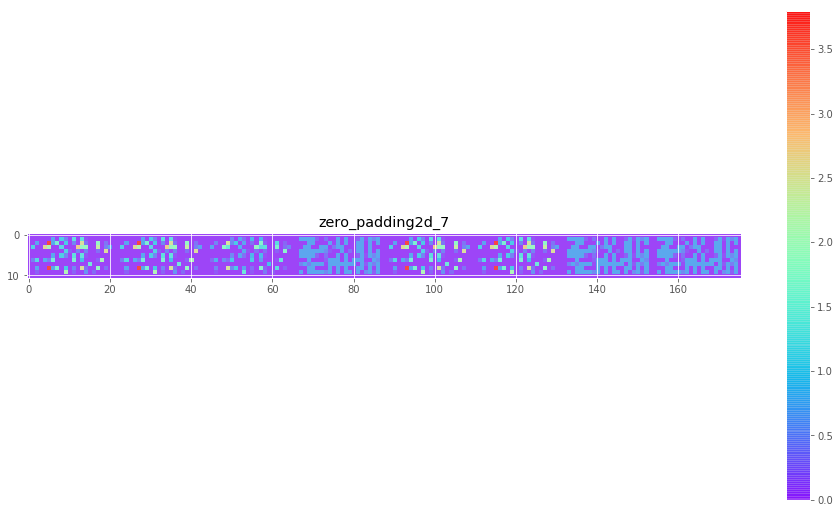

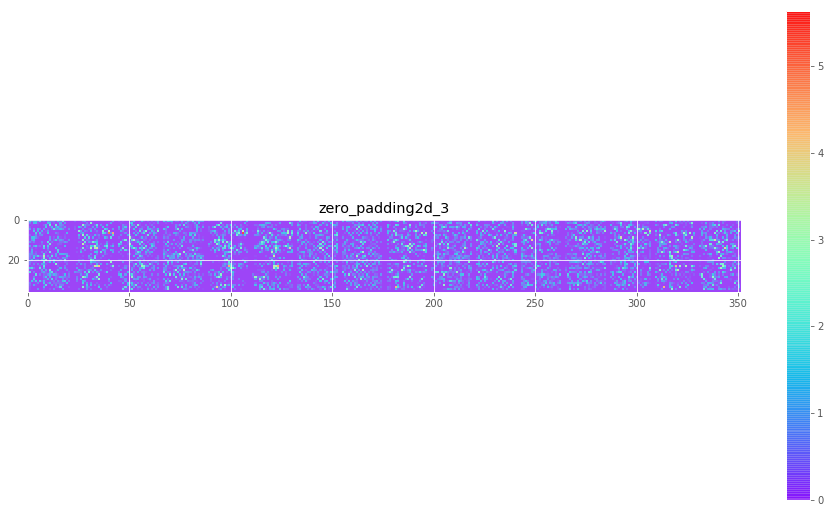

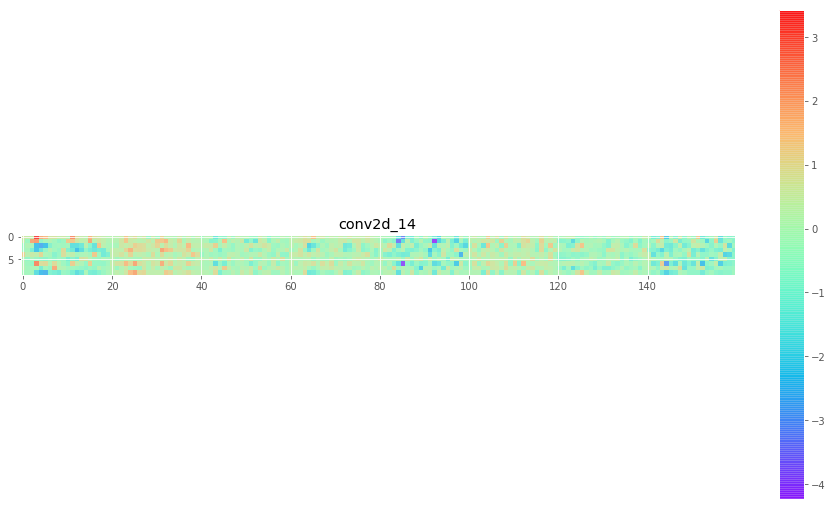

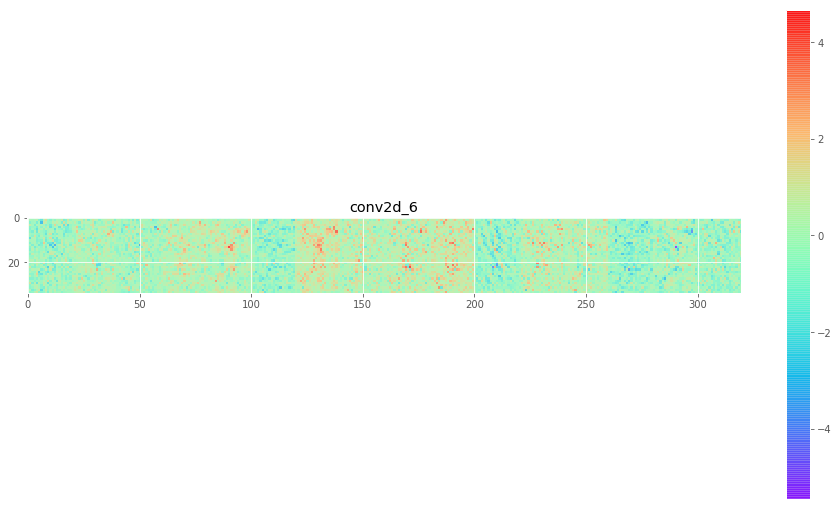

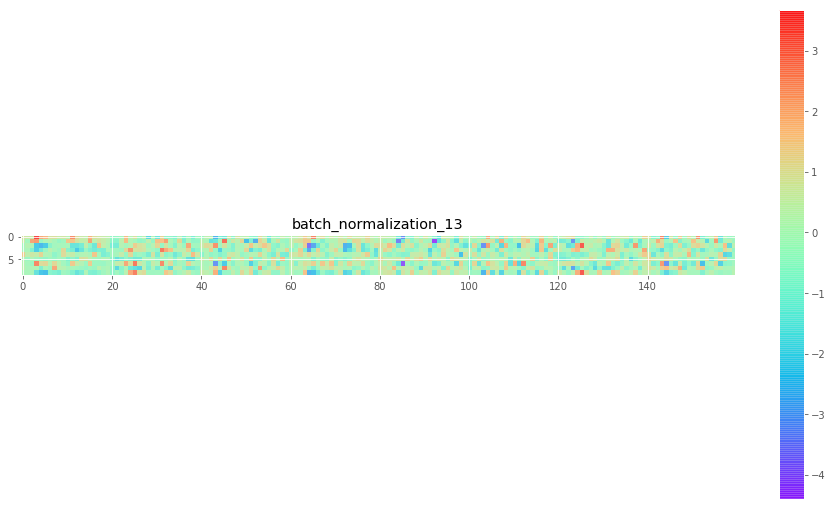

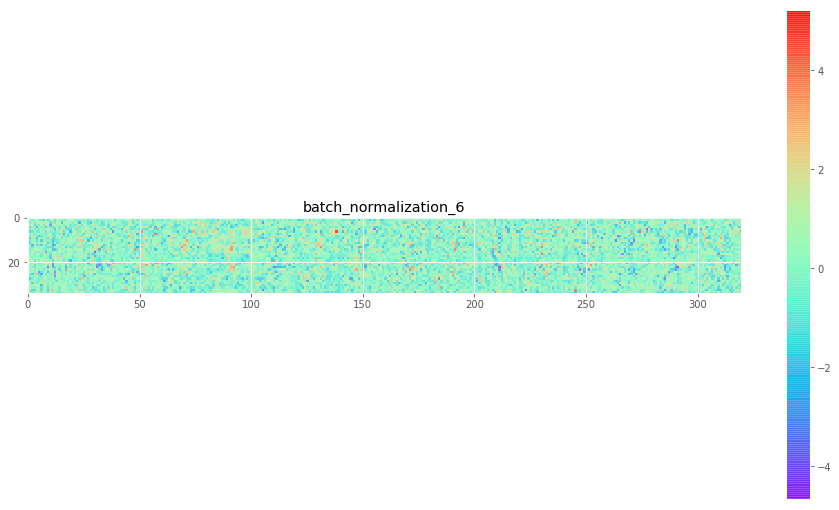

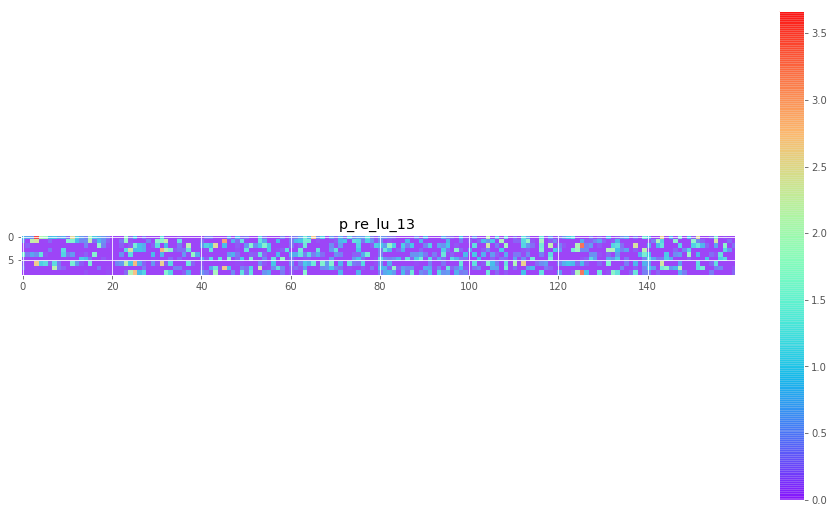

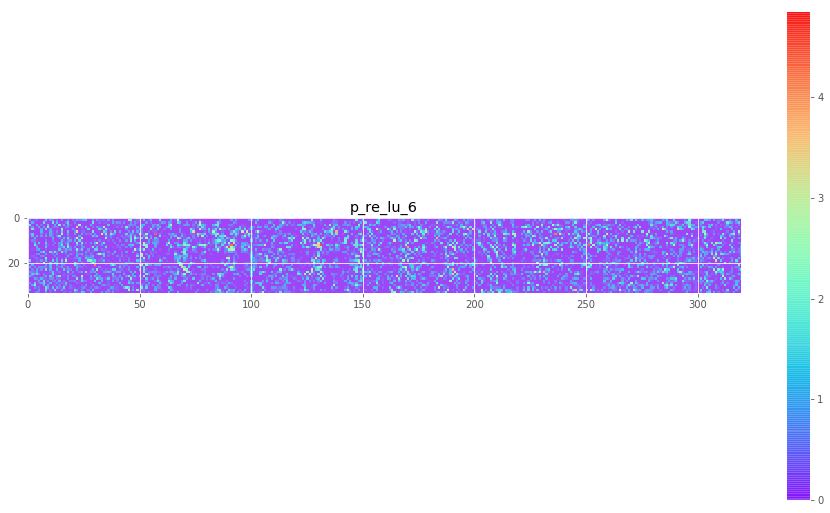

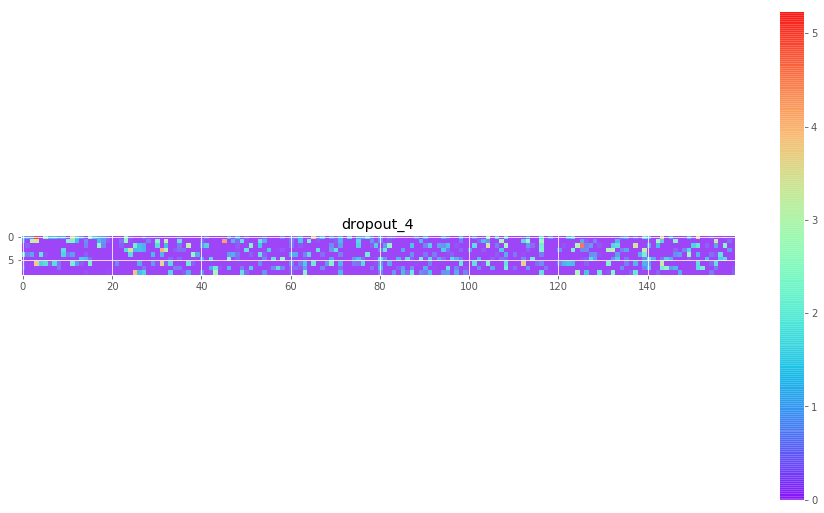

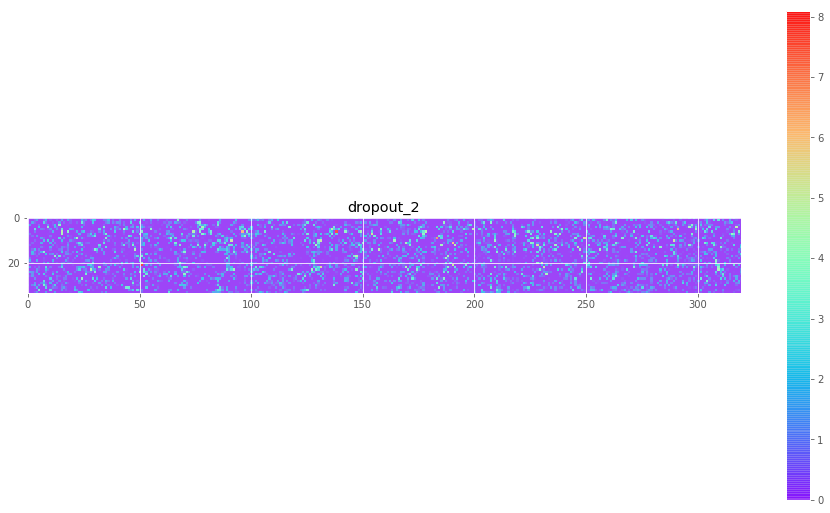

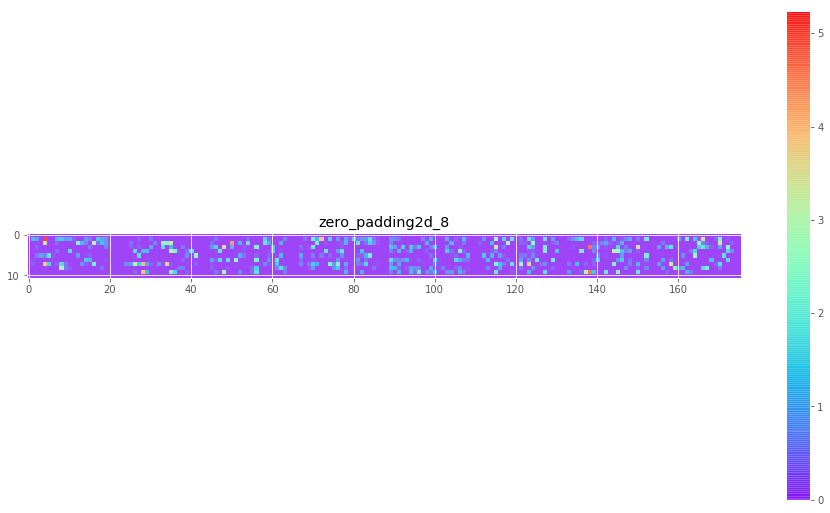

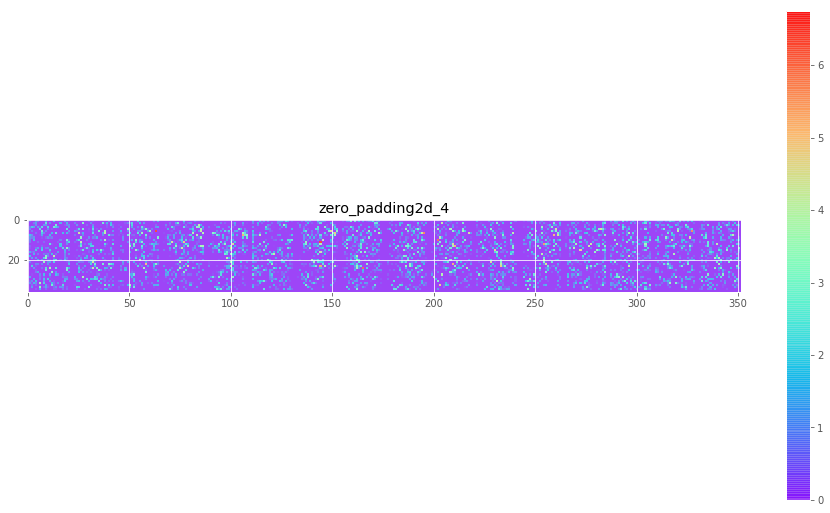

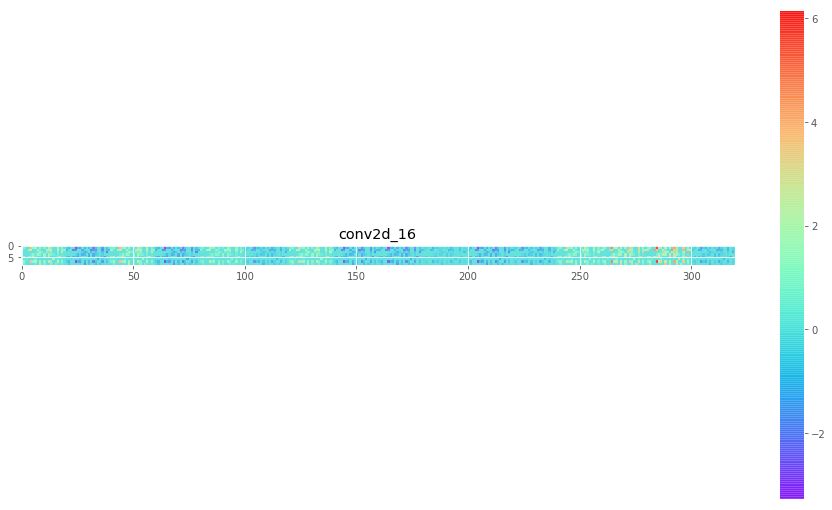

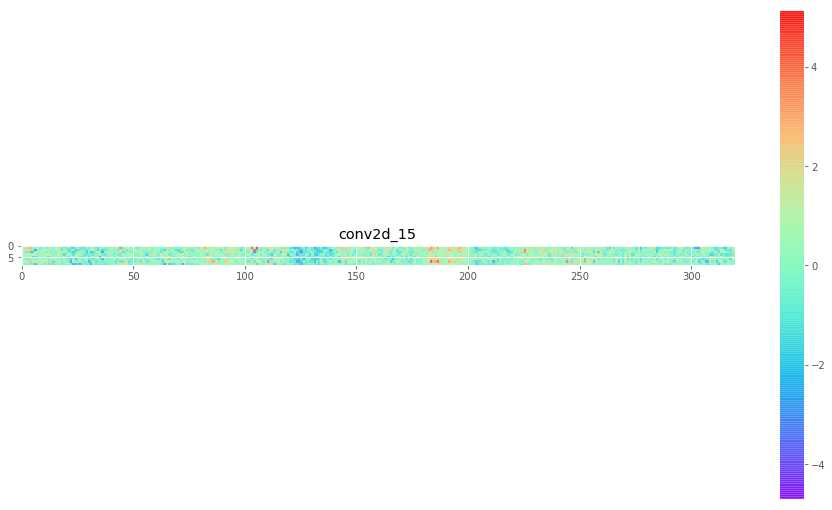

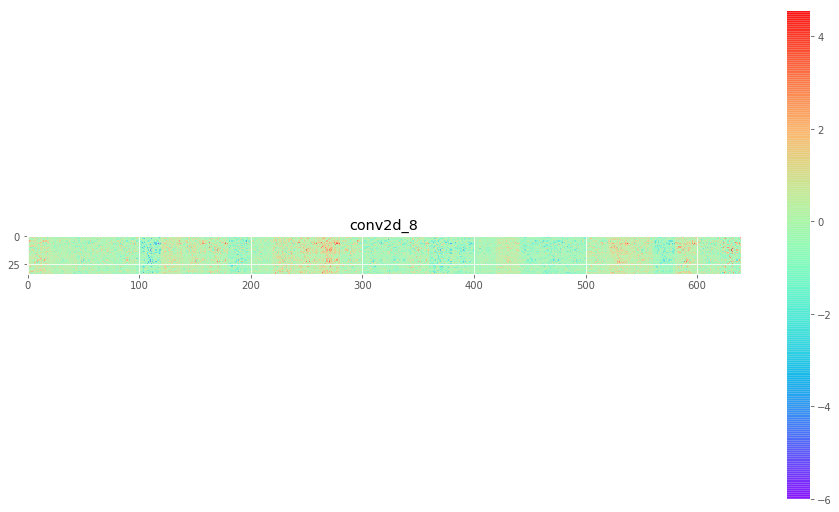

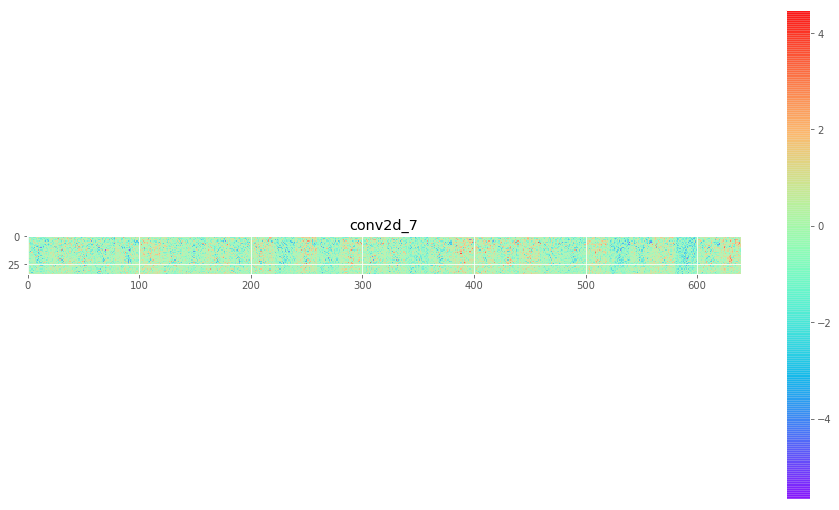

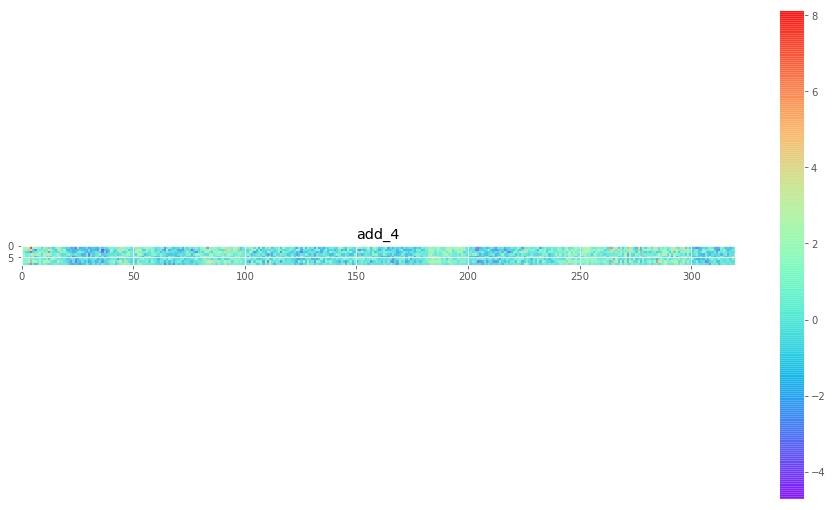

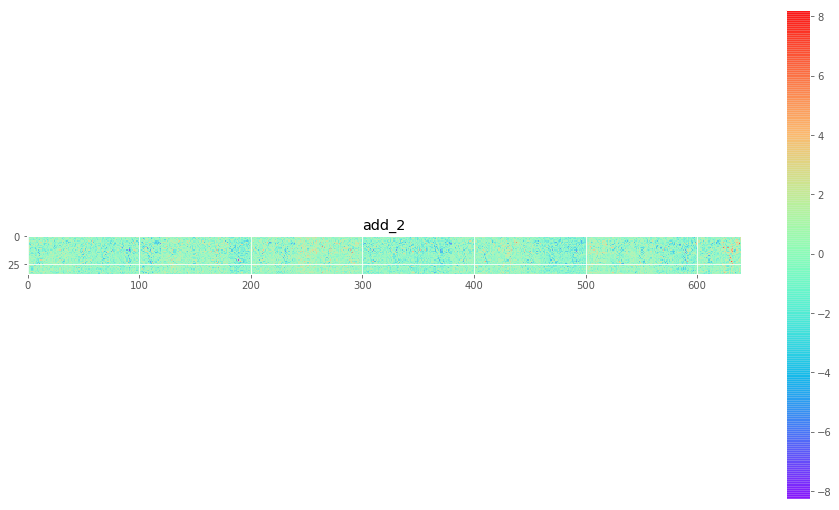

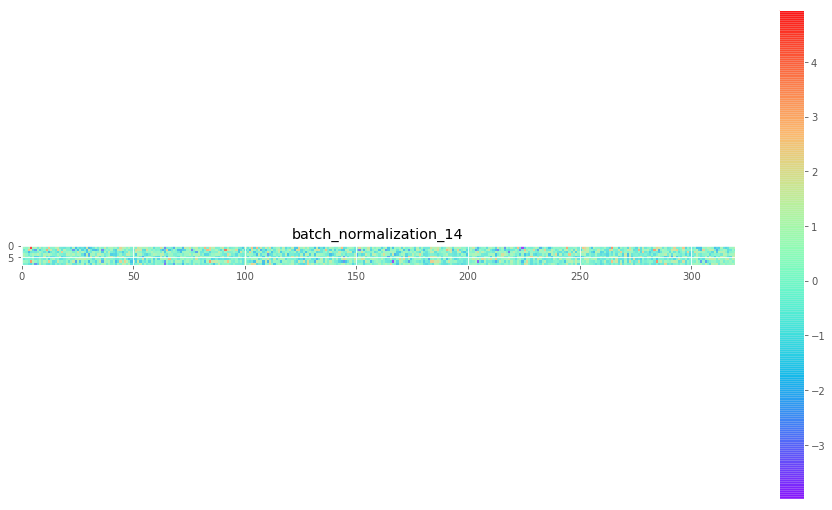

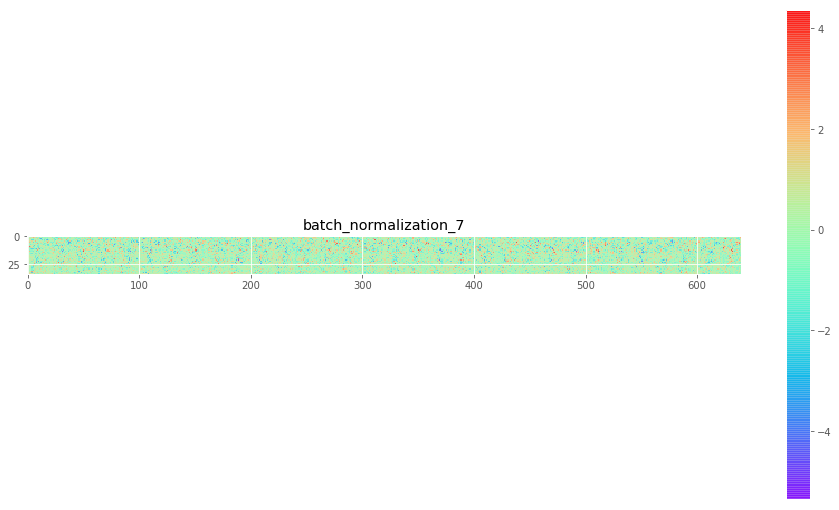

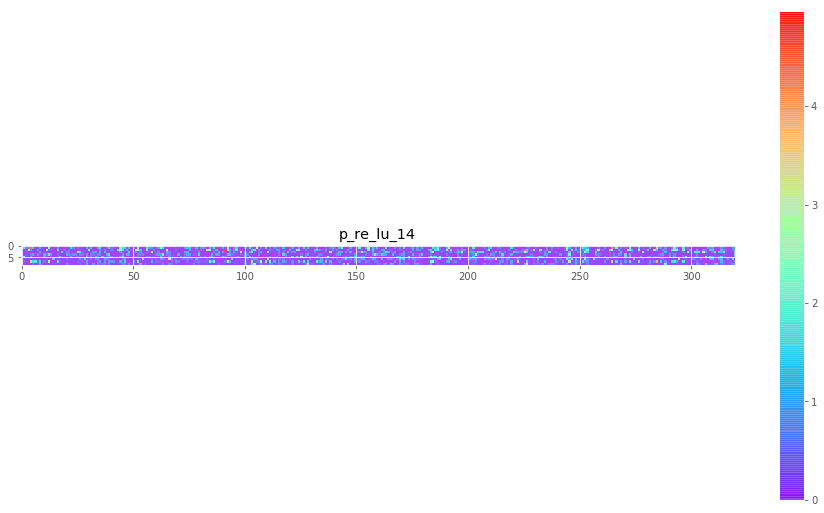

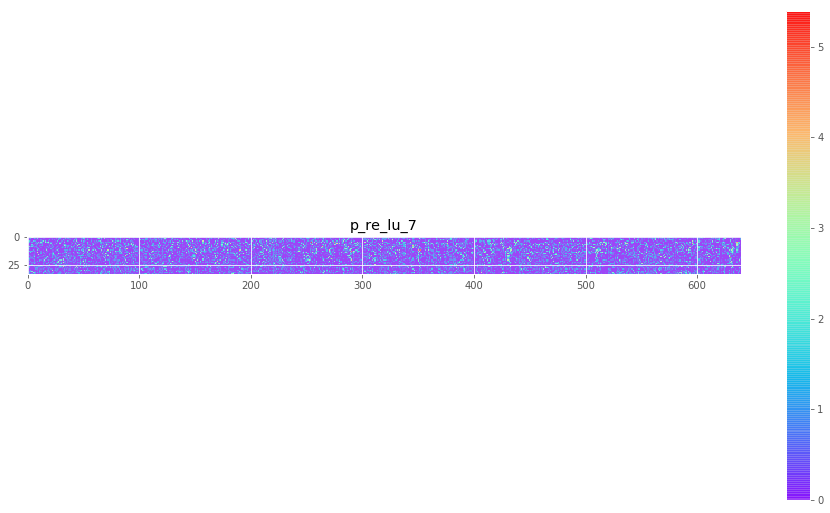

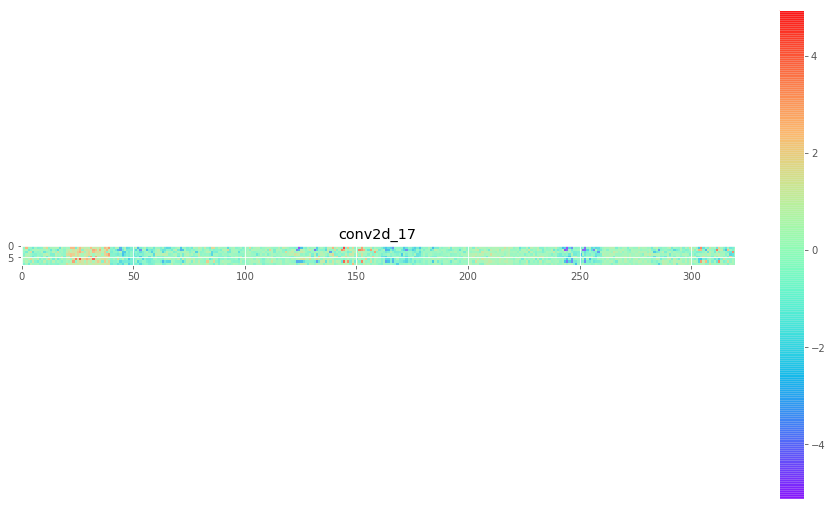

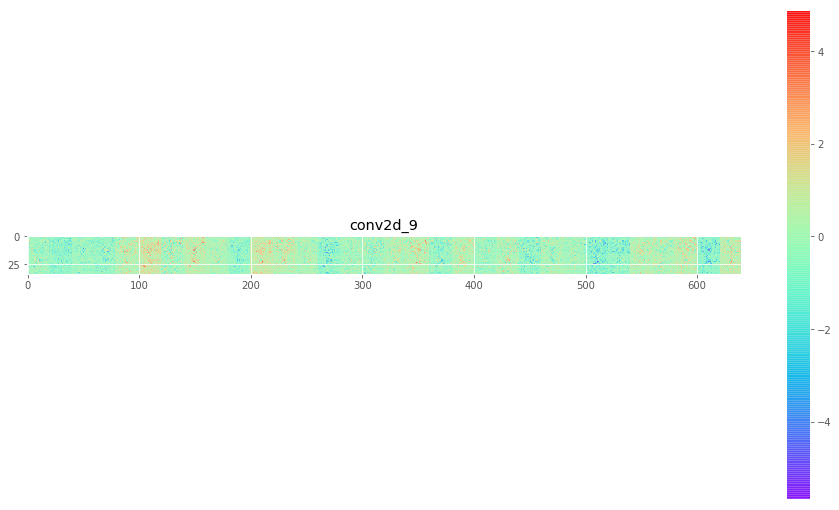

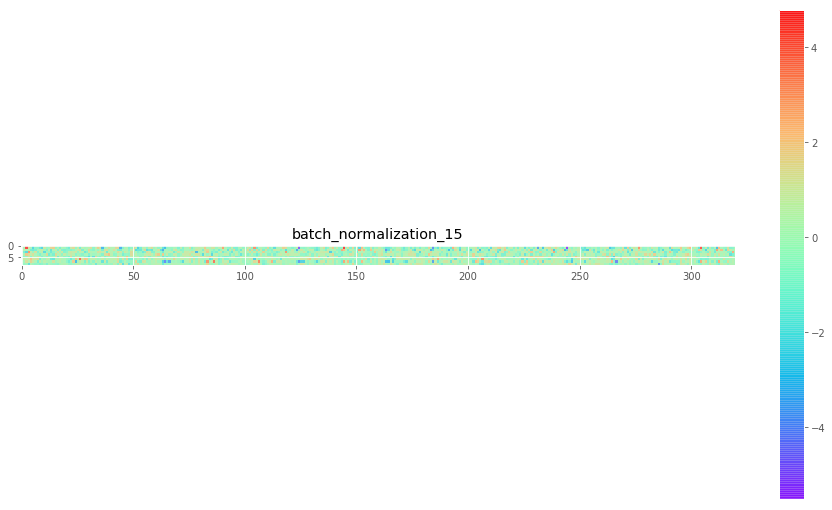

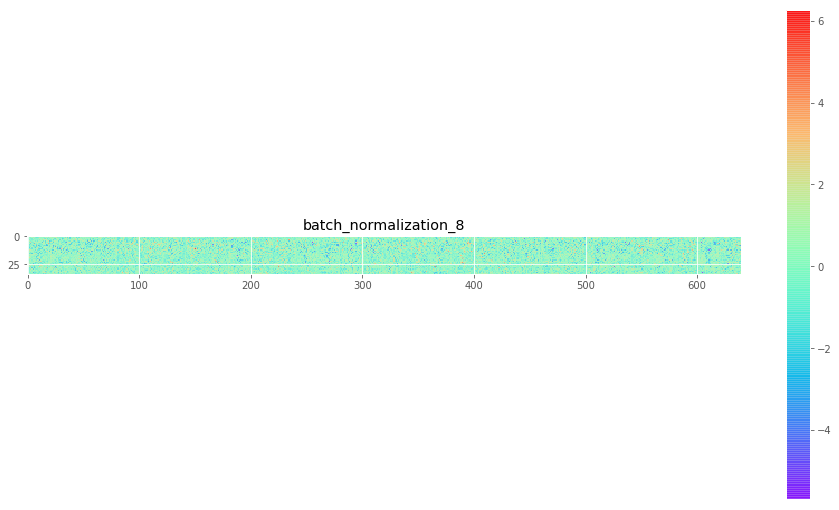

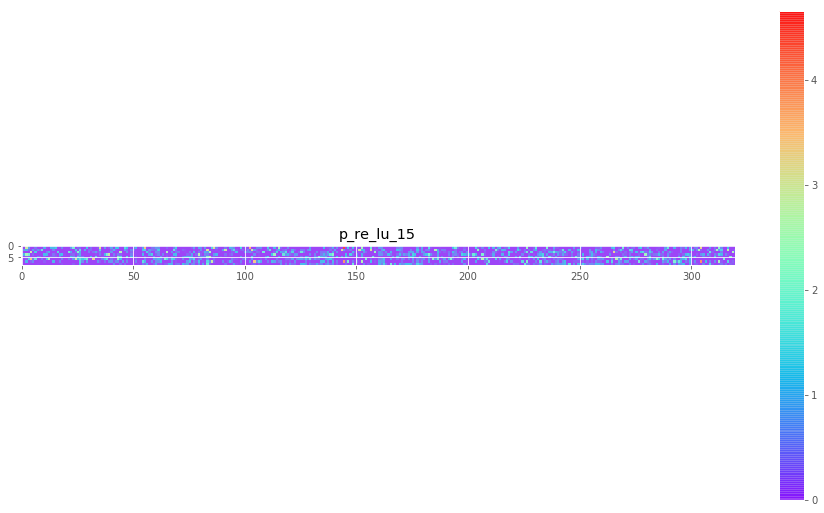

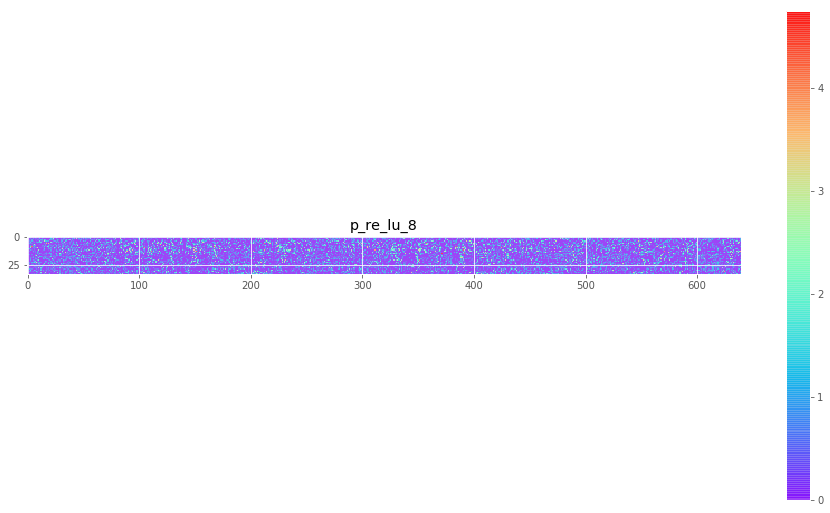

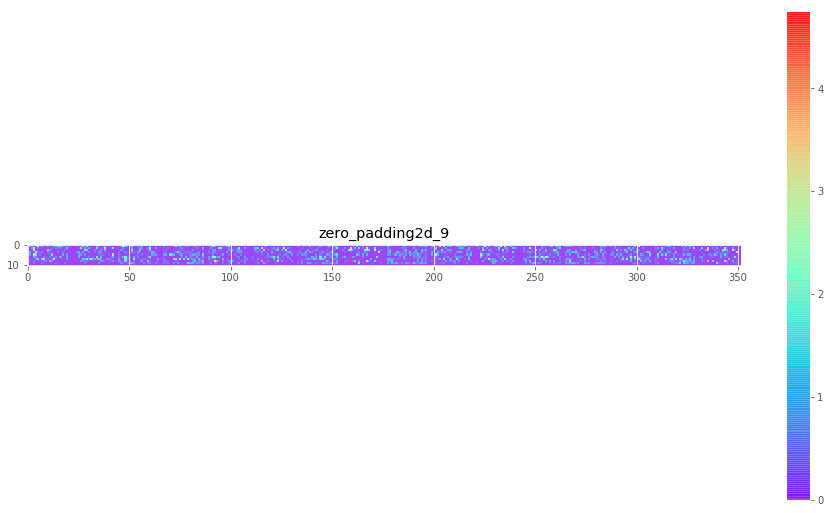

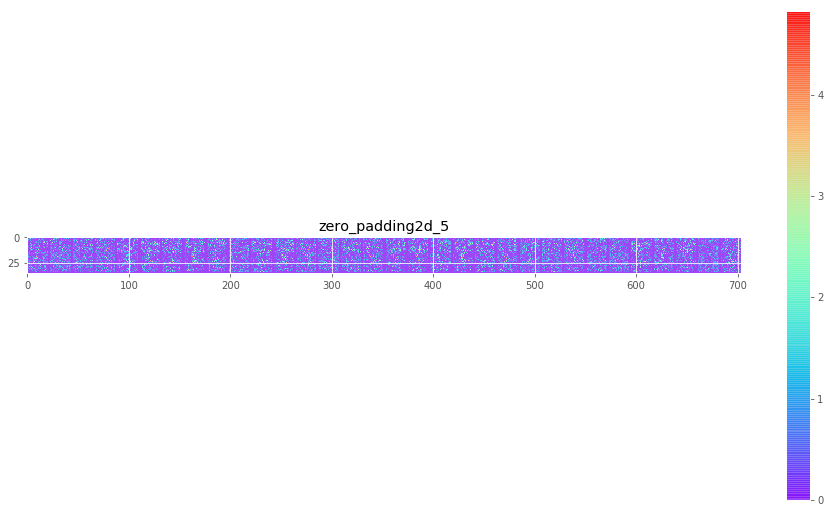

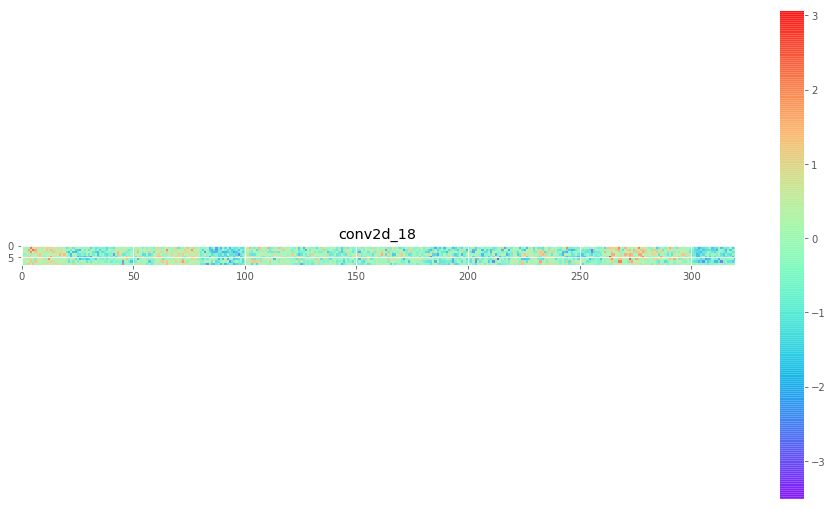

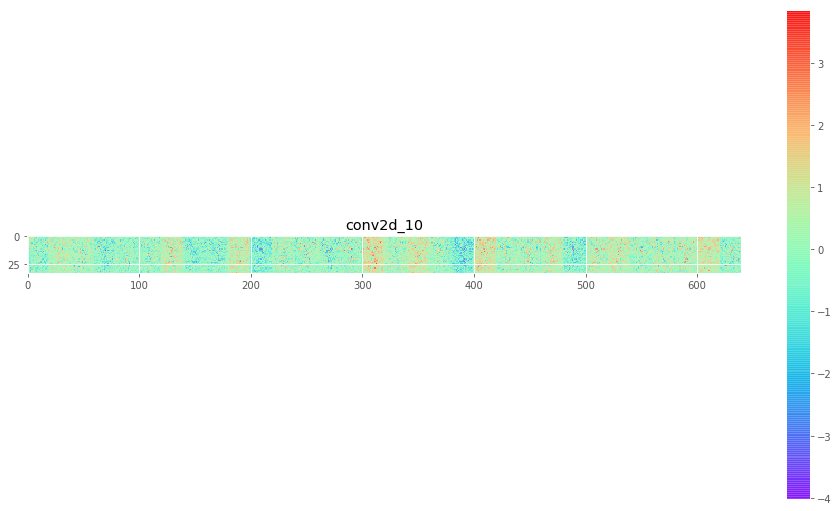

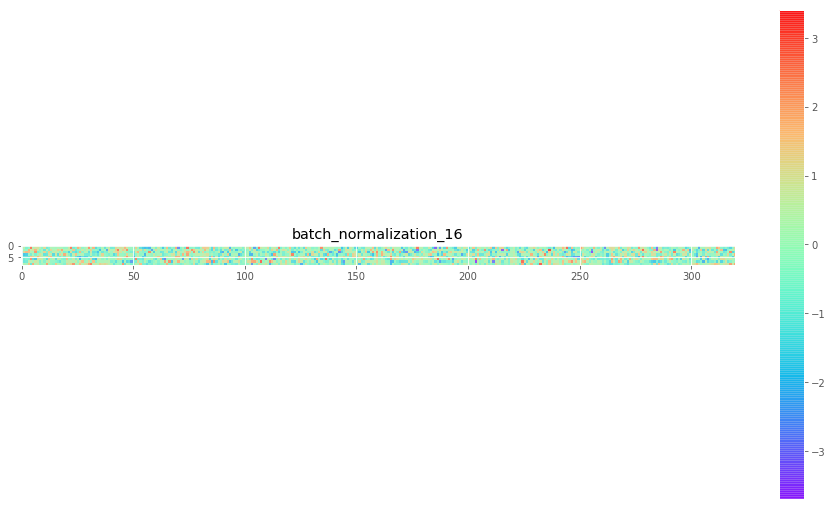

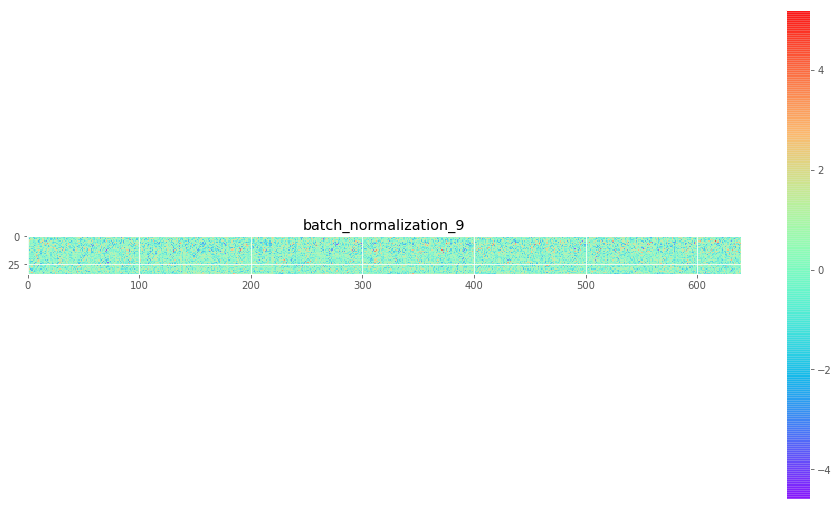

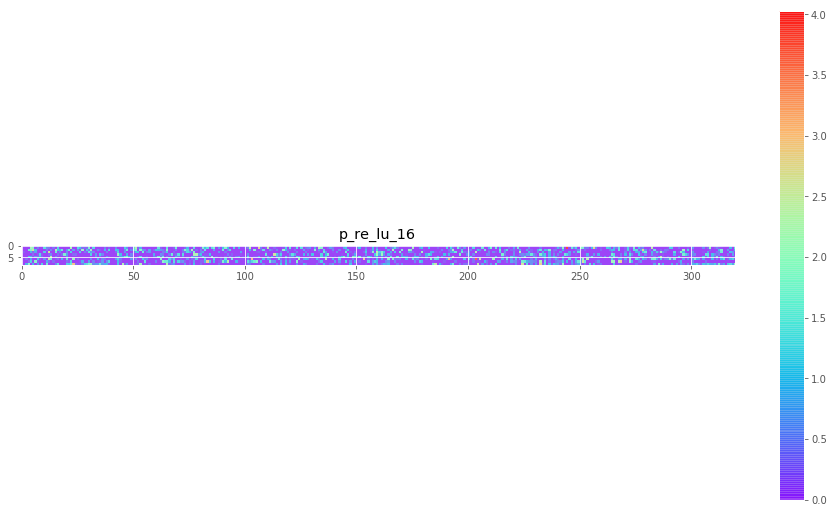

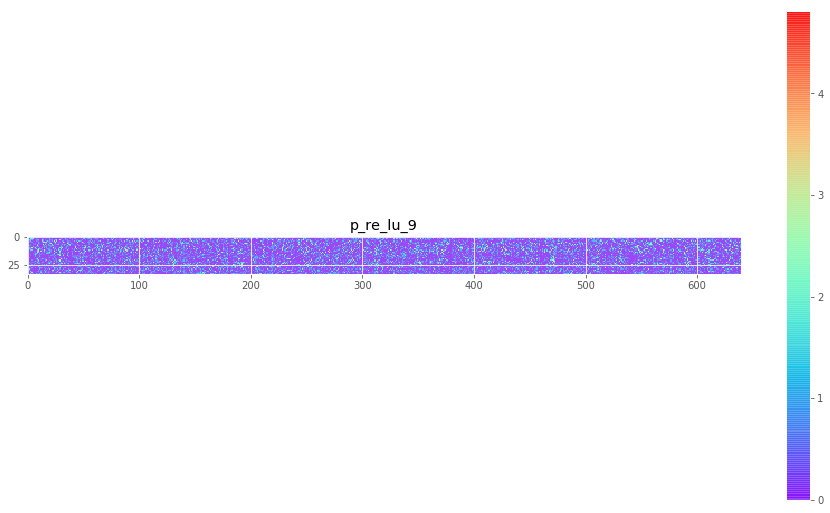

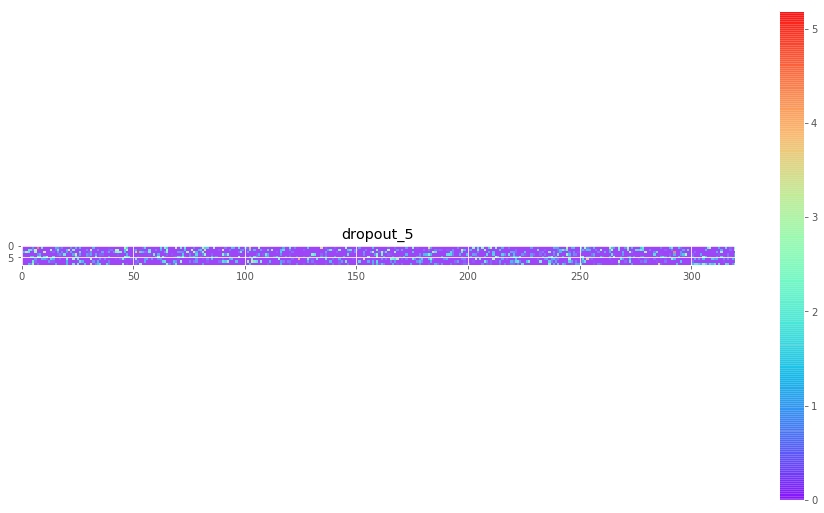

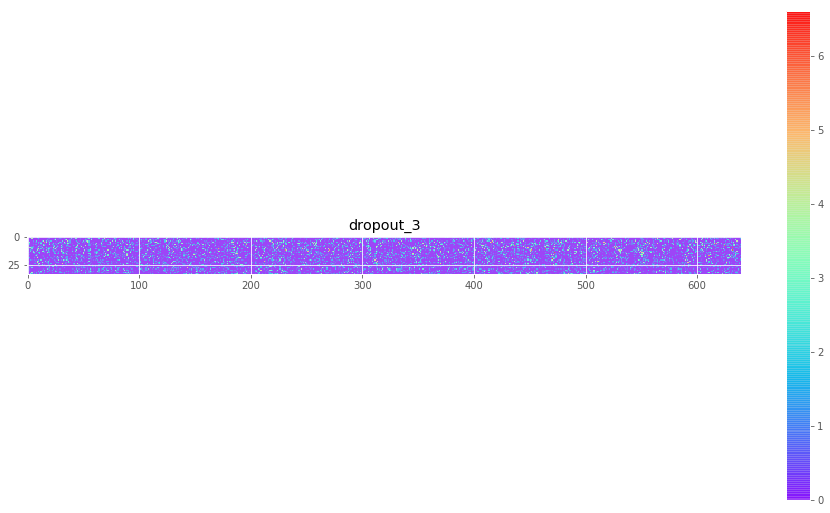

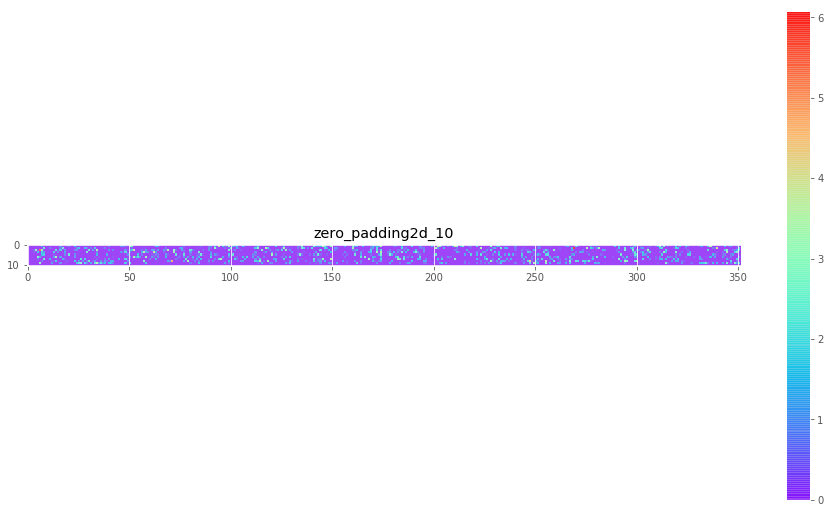

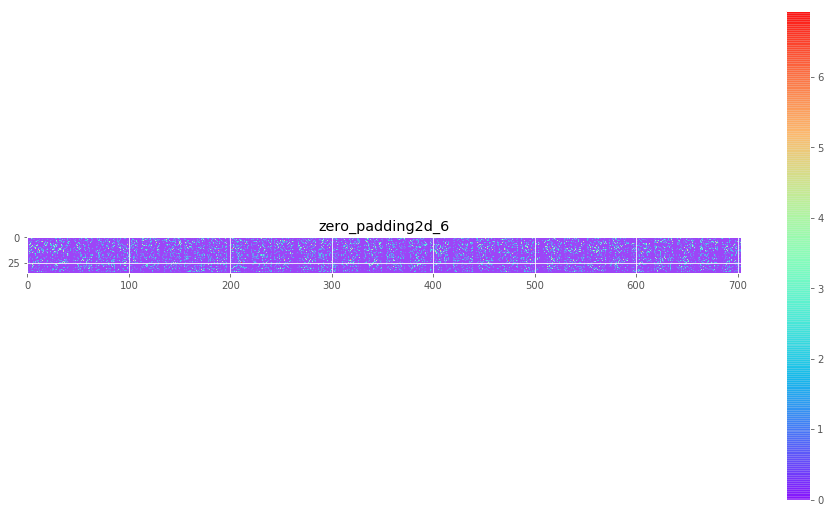

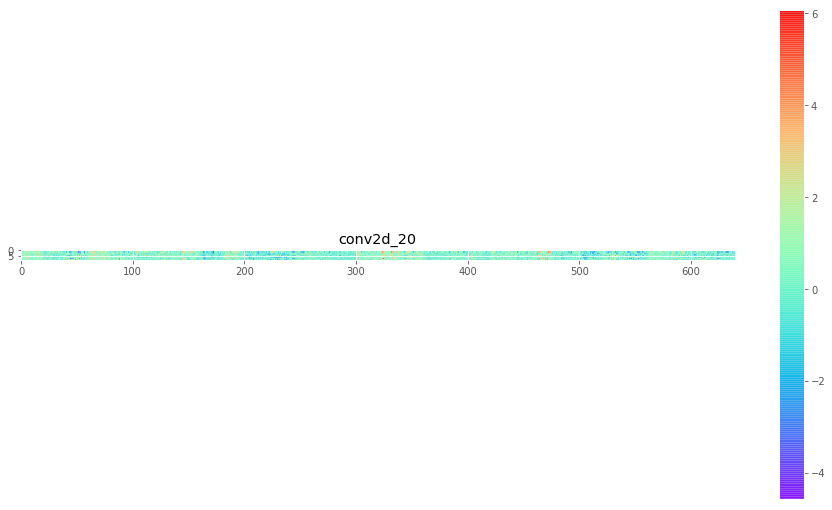

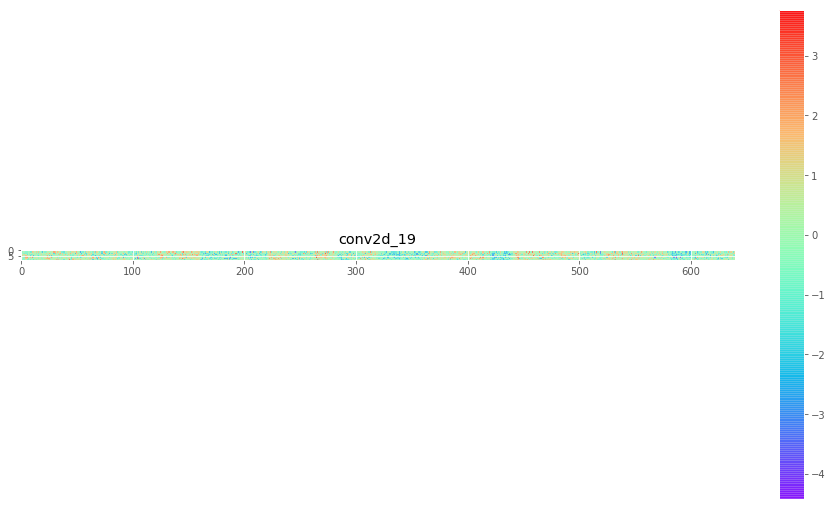

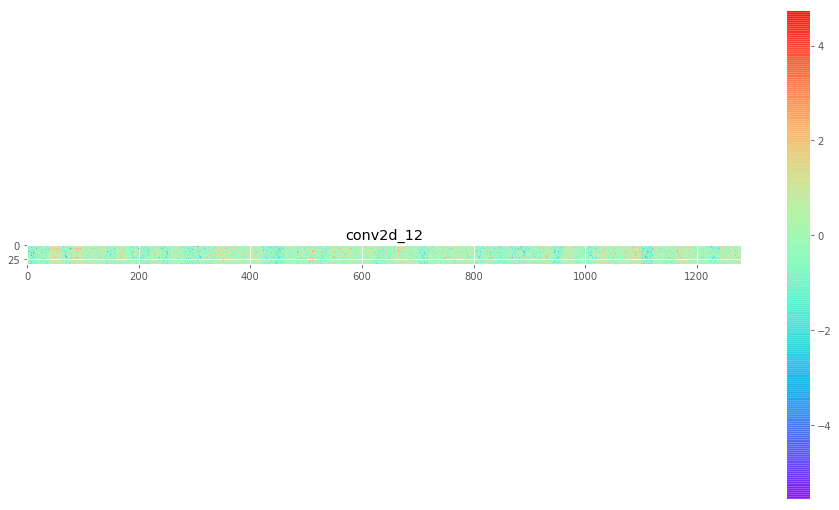

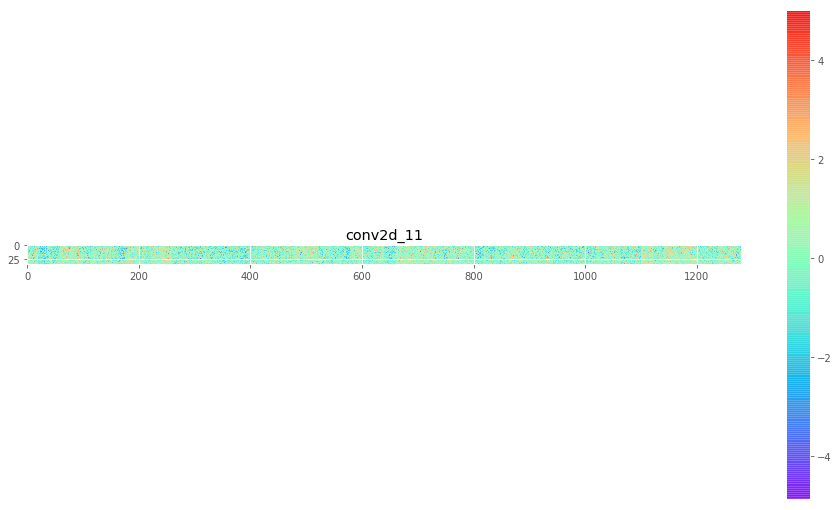

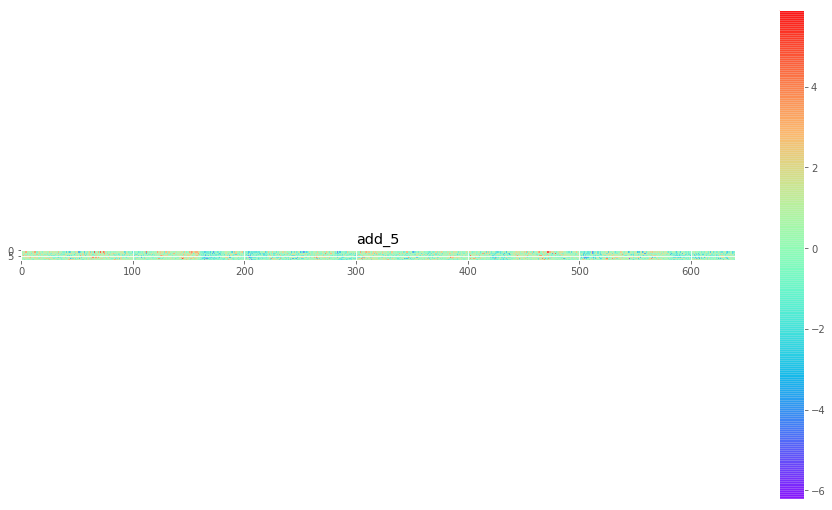

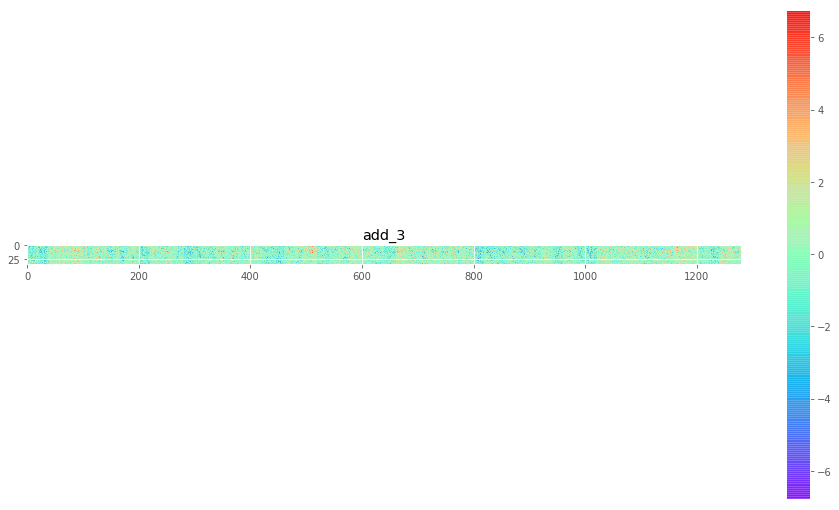

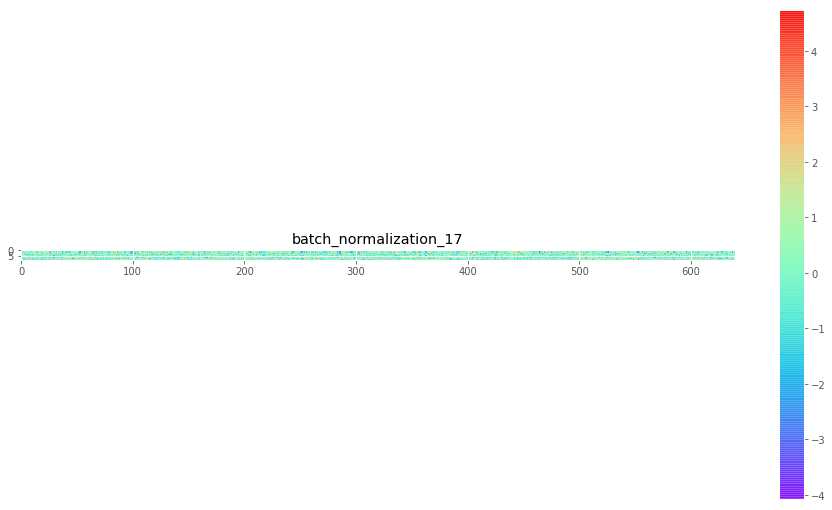

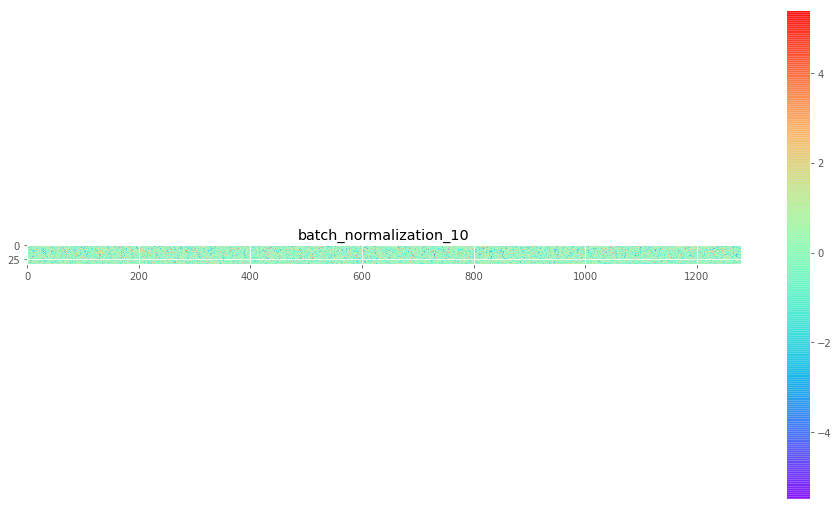

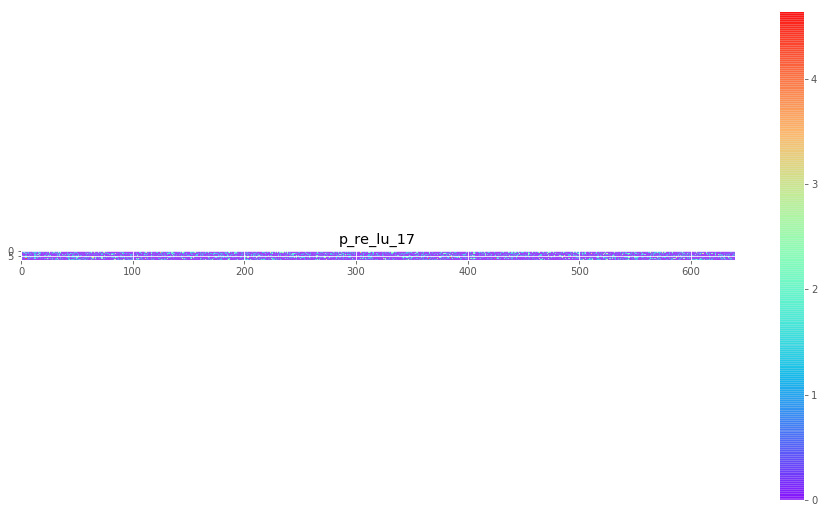

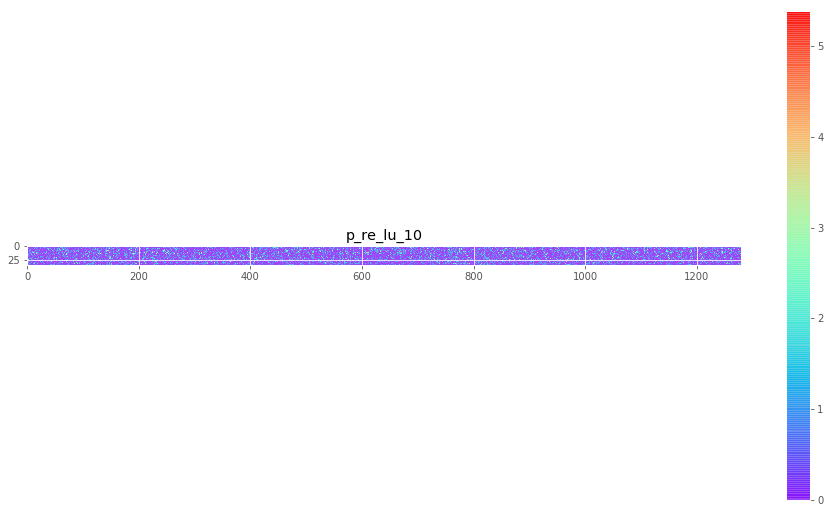

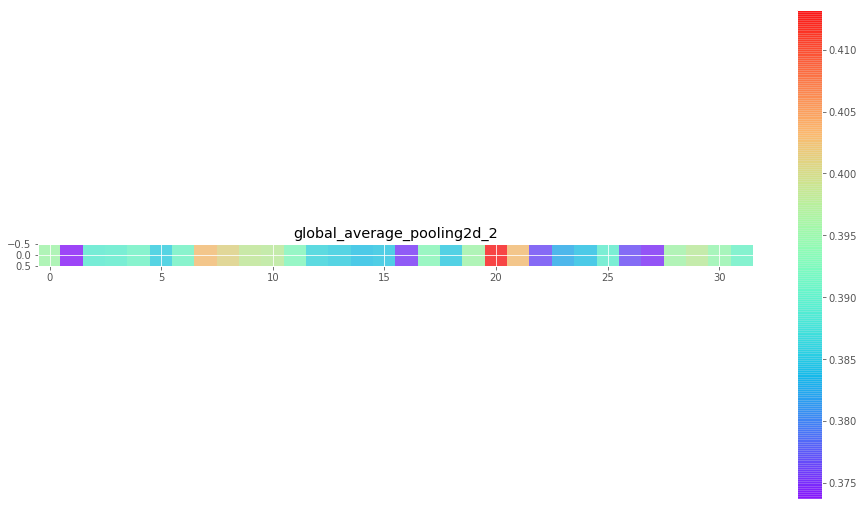

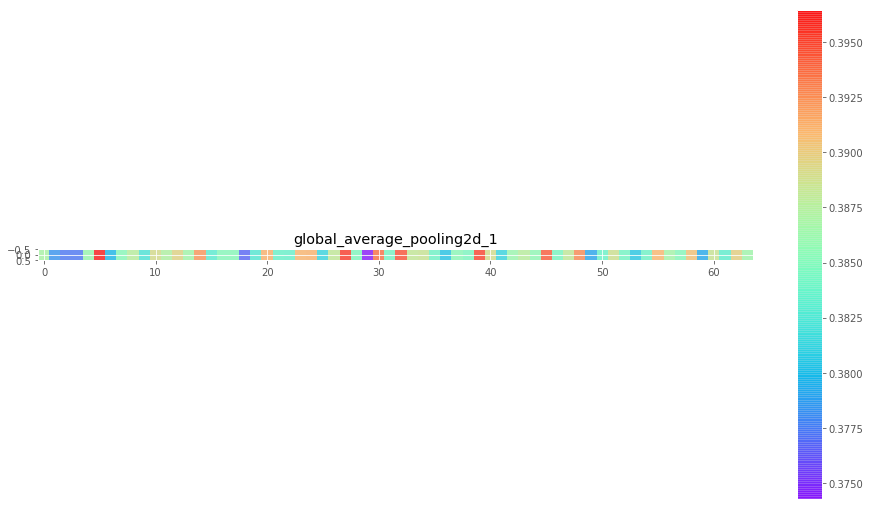

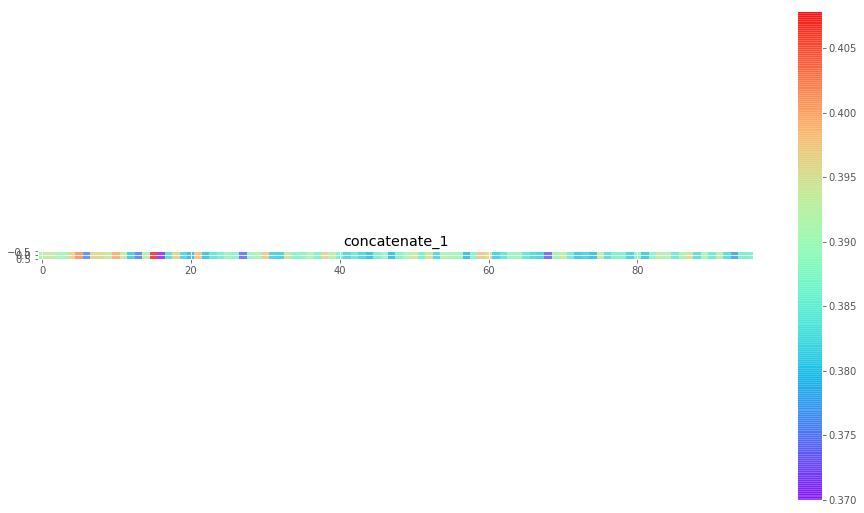

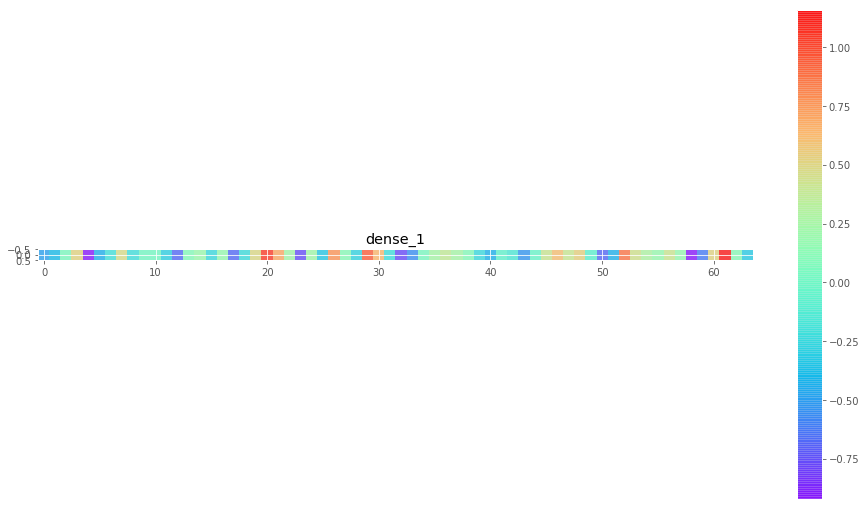

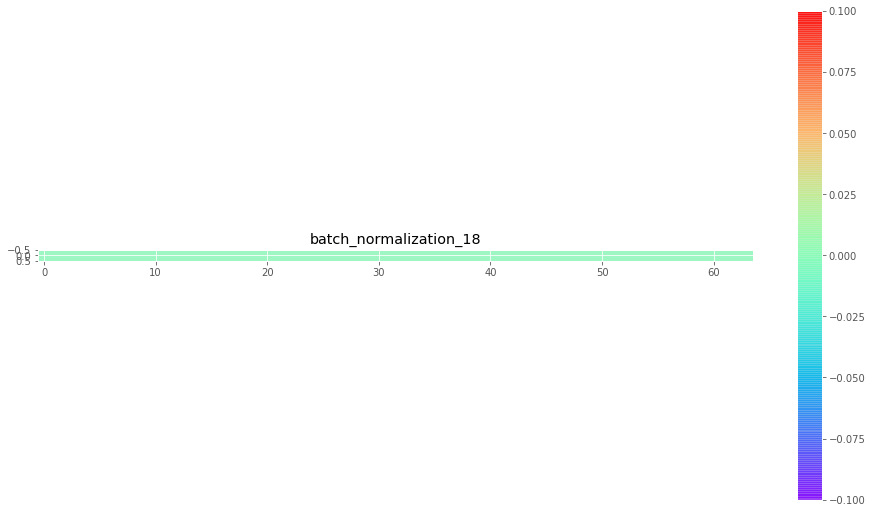

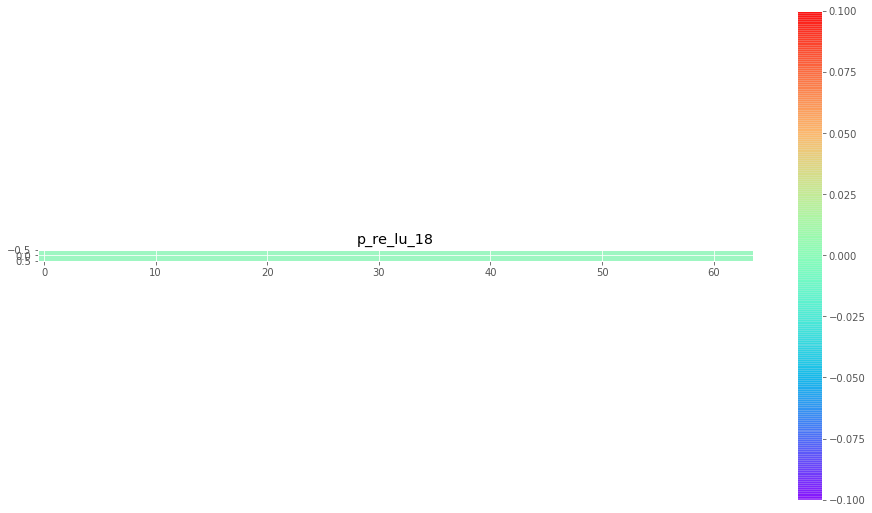

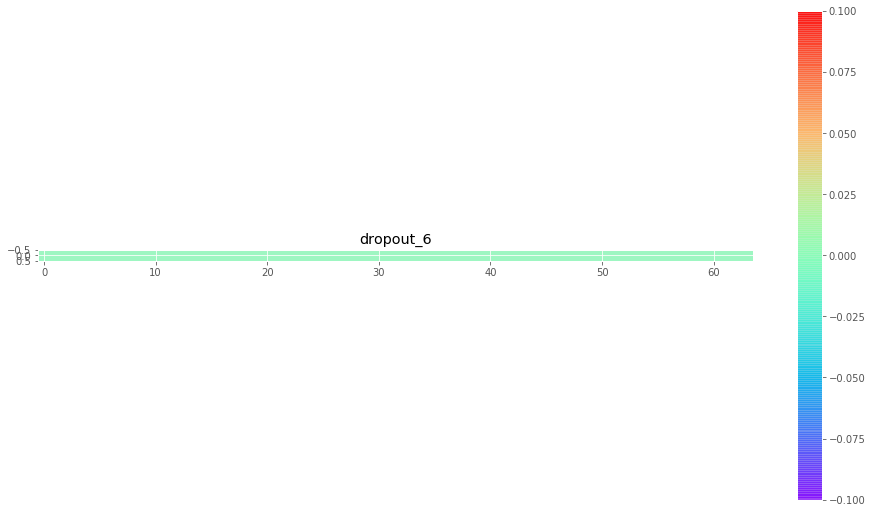

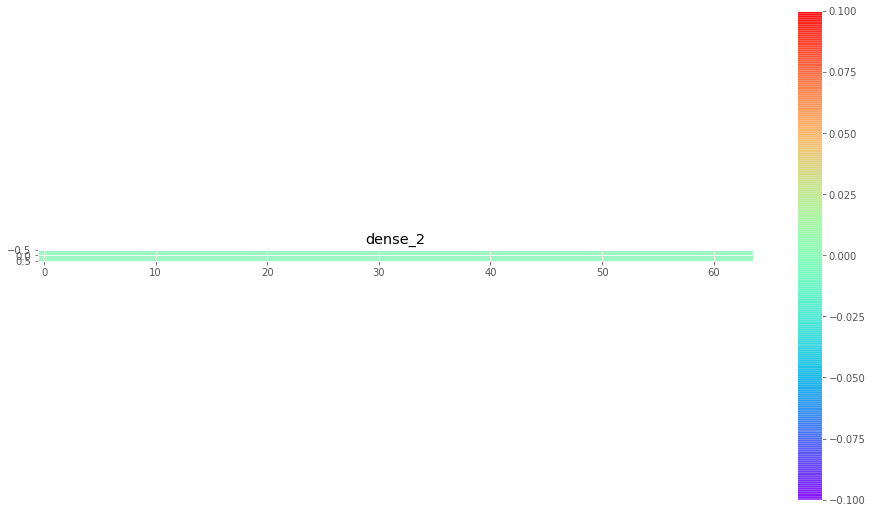

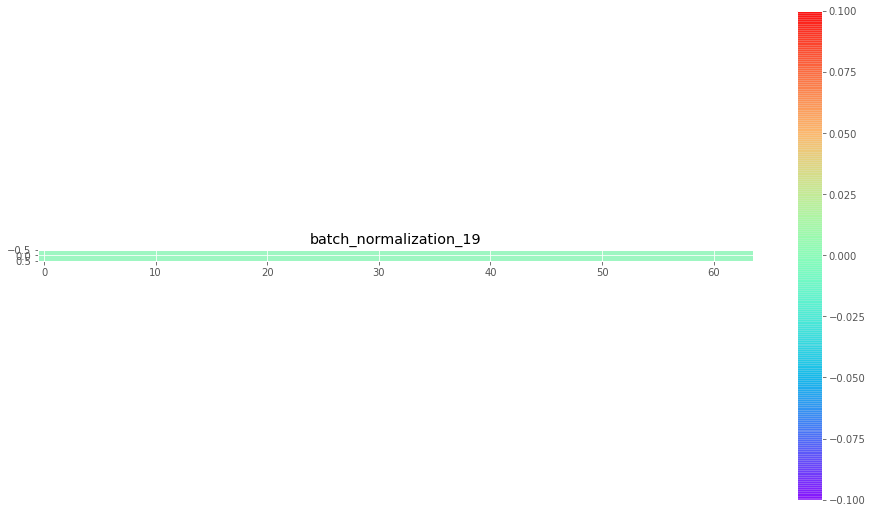

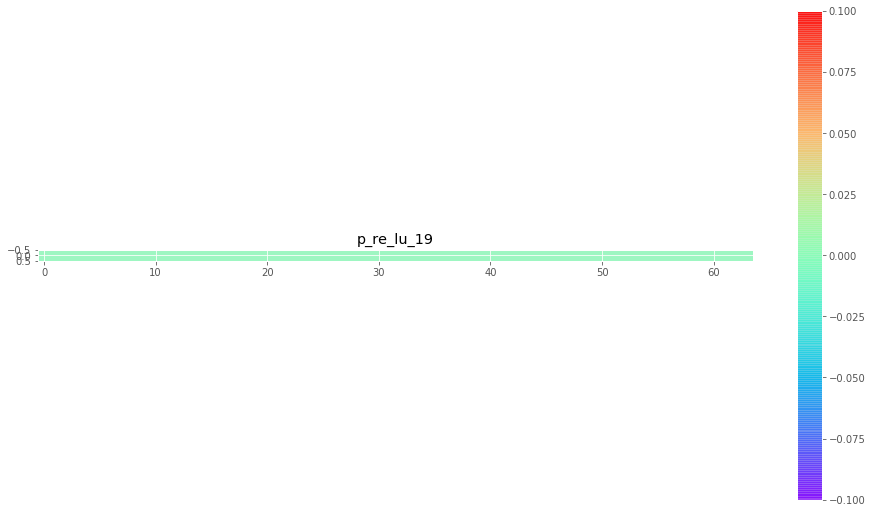

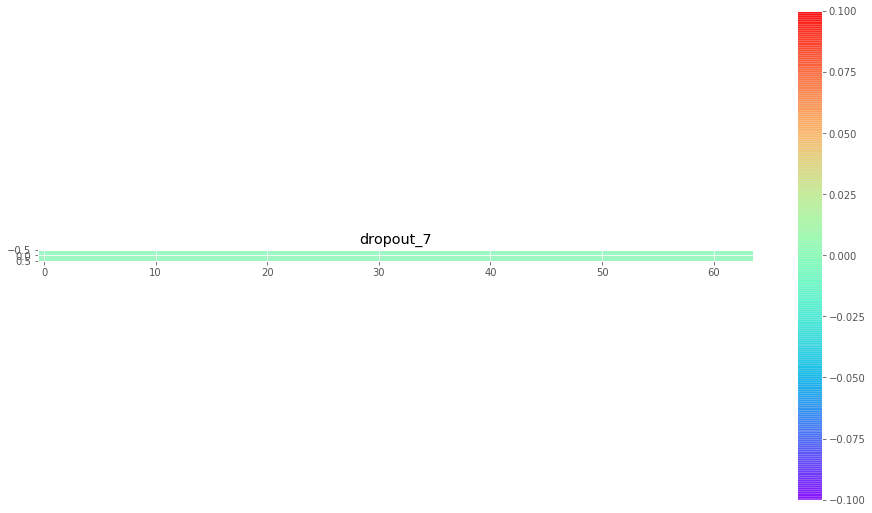

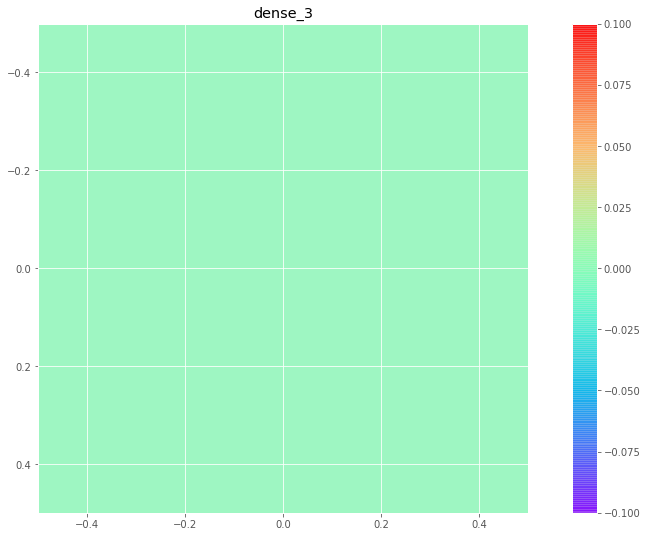

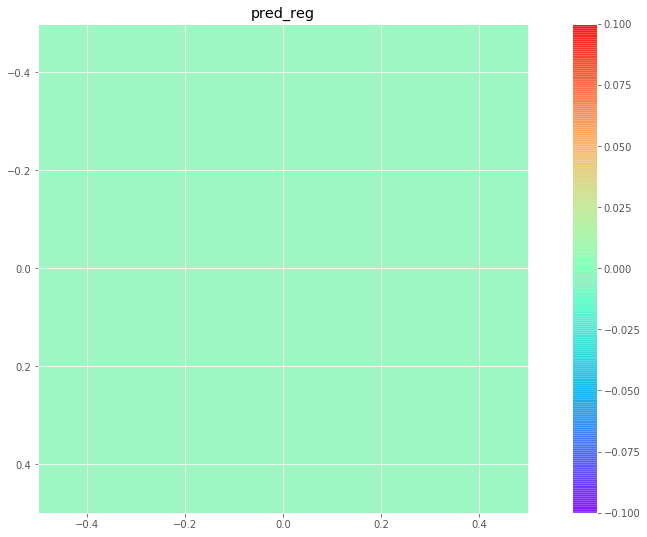

In [26]:
display_activations(weak_acts_new)

Displaying activation map 0
(34, 20)
Displaying activation map 1
(1, 34, 20, 1)
Displaying activation map 2
(1, 34, 20, 1)
Displaying activation map 3
(1, 34, 20, 1)
Displaying activation map 4
(1, 34, 20, 8)
Displaying activation map 5
(1, 34, 20, 8)
Displaying activation map 6
(1, 34, 20, 8)
Displaying activation map 7
(1, 36, 22, 8)
Displaying activation map 8
(1, 34, 20, 8)
Displaying activation map 9
(1, 34, 20, 8)
Displaying activation map 10
(1, 34, 20, 8)
Displaying activation map 11
(1, 34, 20, 8)
Displaying activation map 12
(1, 36, 22, 8)
Displaying activation map 13
(9, 20)
Displaying activation map 14
(1, 34, 20, 16)
Displaying activation map 15
(1, 34, 20, 16)
Displaying activation map 16
(1, 9, 20, 1)
Displaying activation map 17
(1, 34, 20, 16)
Displaying activation map 18
(1, 9, 20, 1)
Displaying activation map 19
(1, 34, 20, 16)
Displaying activation map 20
(1, 9, 20, 1)
Displaying activation map 21
(1, 34, 20, 16)
Displaying activation map 22
(1, 9, 20, 8)


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Displaying activation map 23
(1, 34, 20, 16)
Displaying activation map 24
(1, 9, 20, 8)
Displaying activation map 25
(1, 34, 20, 16)
Displaying activation map 26
(1, 9, 20, 8)
Displaying activation map 27
(1, 34, 20, 16)
Displaying activation map 28
(1, 11, 22, 8)
Displaying activation map 29
(1, 36, 22, 16)
Displaying activation map 30
(1, 9, 20, 8)
Displaying activation map 31
(1, 34, 20, 16)
Displaying activation map 32
(1, 9, 20, 8)
Displaying activation map 33
(1, 34, 20, 16)
Displaying activation map 34
(1, 9, 20, 8)
Displaying activation map 35
(1, 34, 20, 16)
Displaying activation map 36
(1, 9, 20, 8)
Displaying activation map 37
(1, 34, 20, 16)
Displaying activation map 38
(1, 11, 22, 8)
Displaying activation map 39
(1, 36, 22, 16)
Displaying activation map 40
(1, 9, 20, 16)
Displaying activation map 41
(1, 9, 20, 16)
Displaying activation map 42
(1, 34, 20, 32)
Displaying activation map 43
(1, 34, 20, 32)
Displaying activation map 44
(1, 9, 20, 16)
Displaying activation map 4

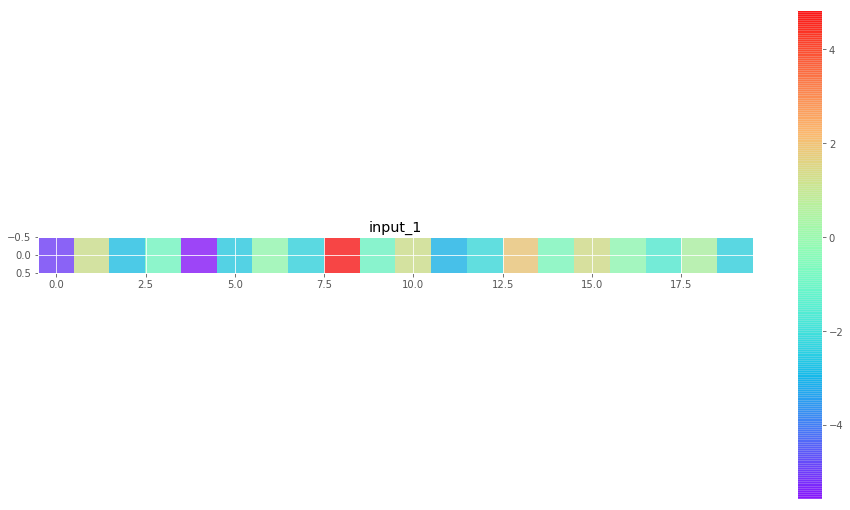

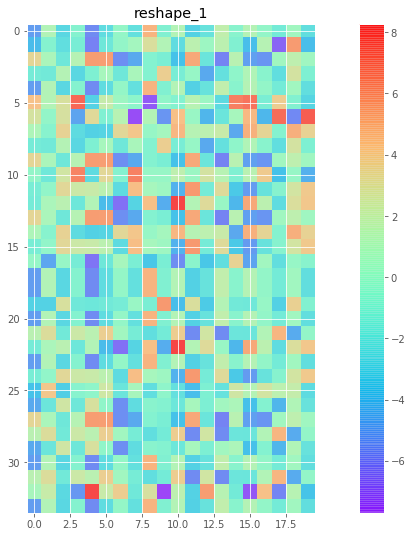

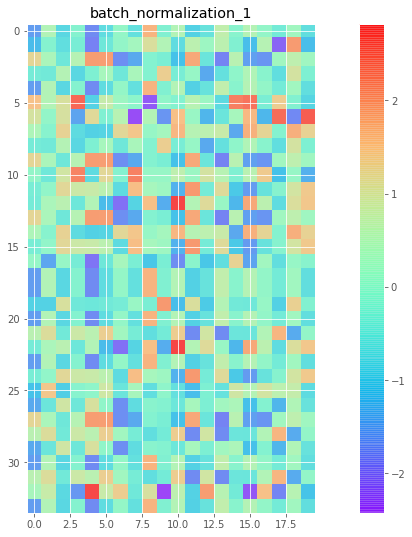

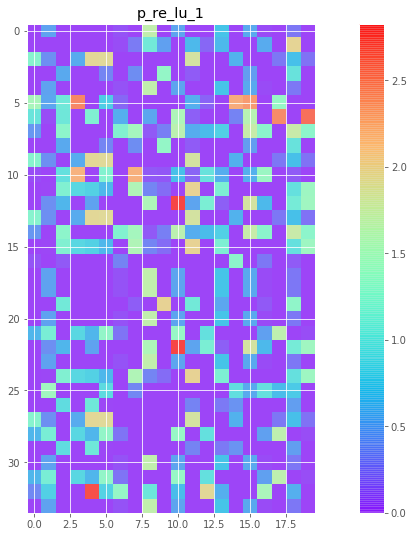

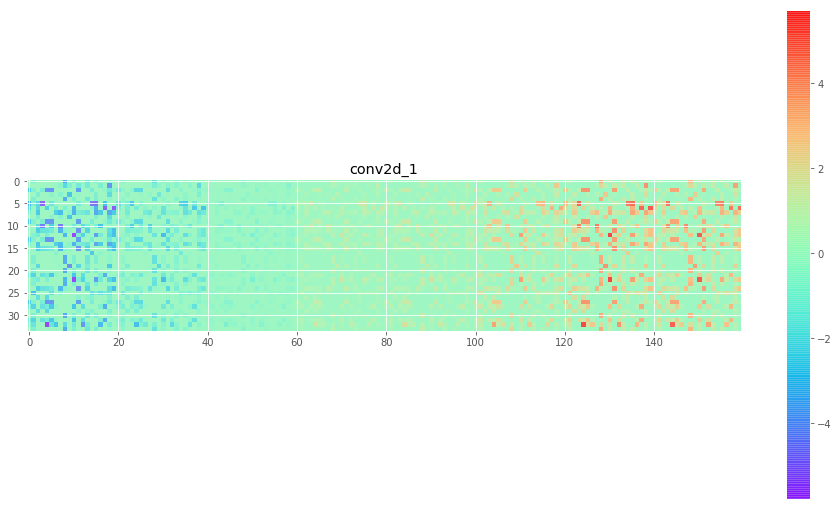

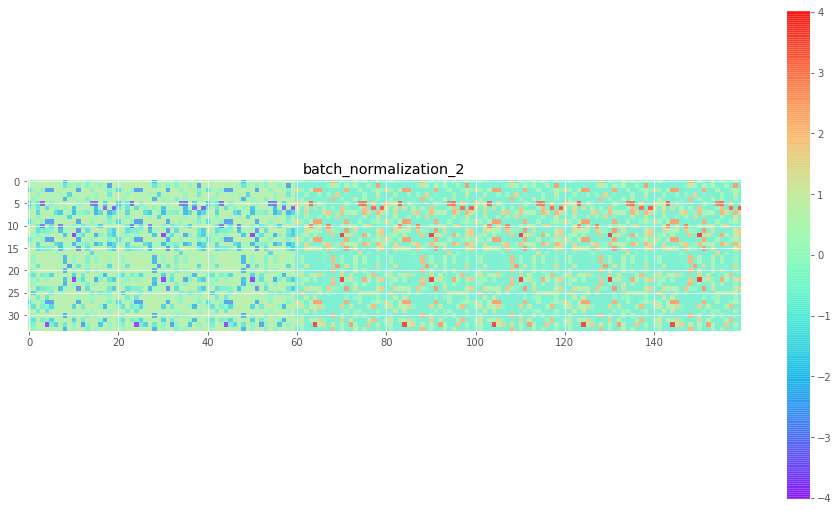

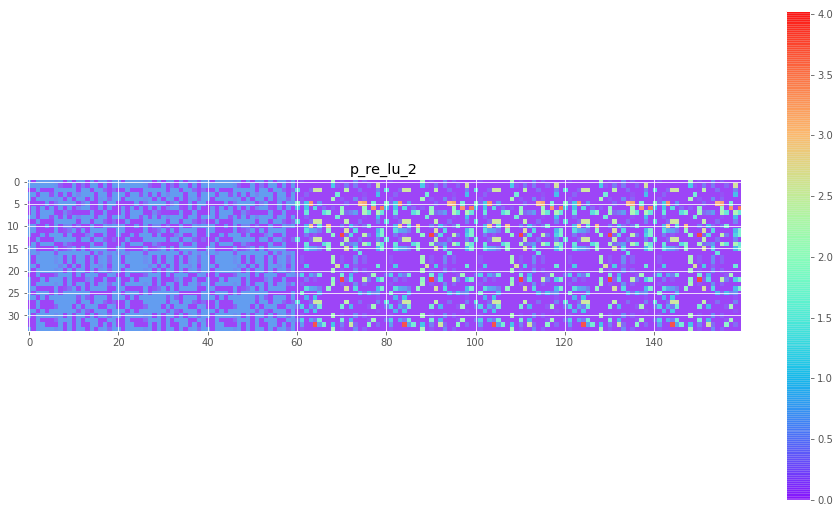

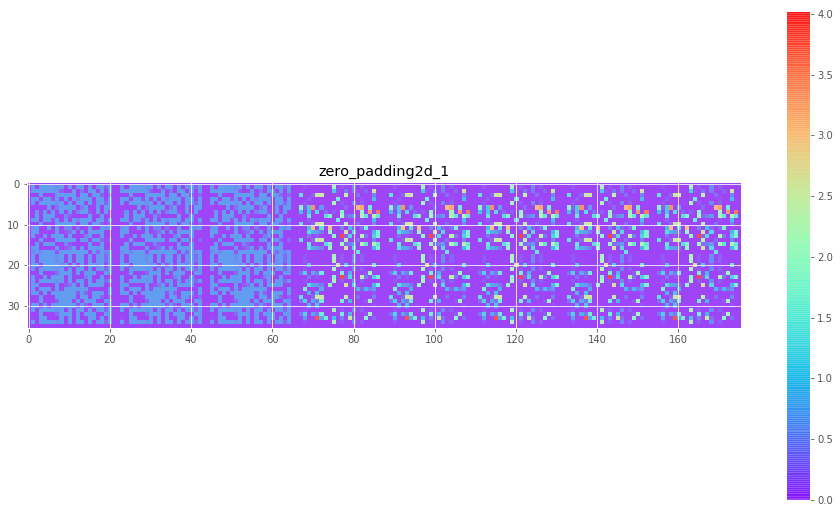

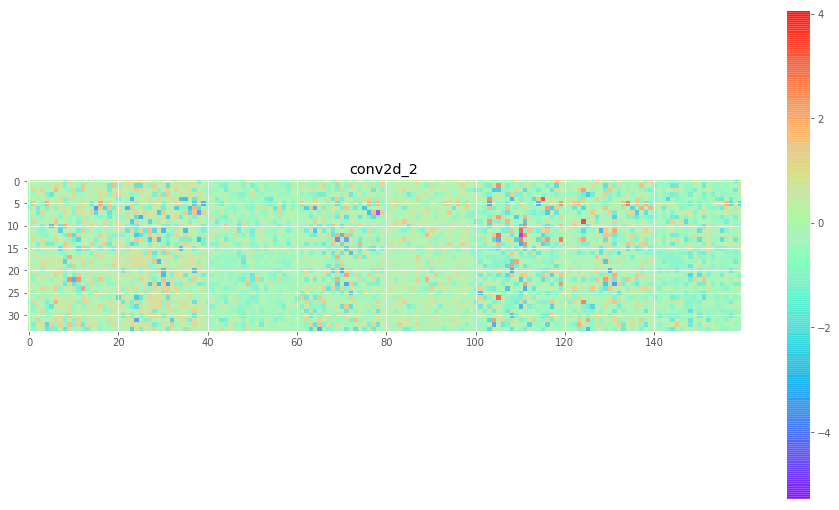

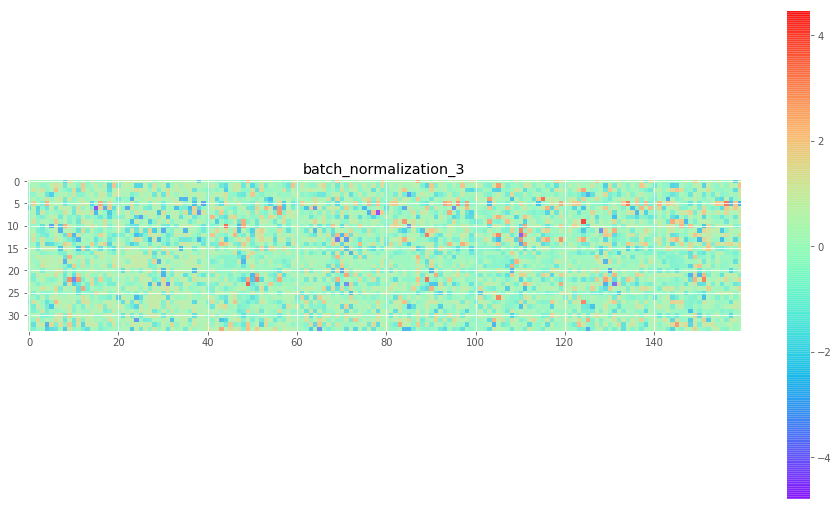

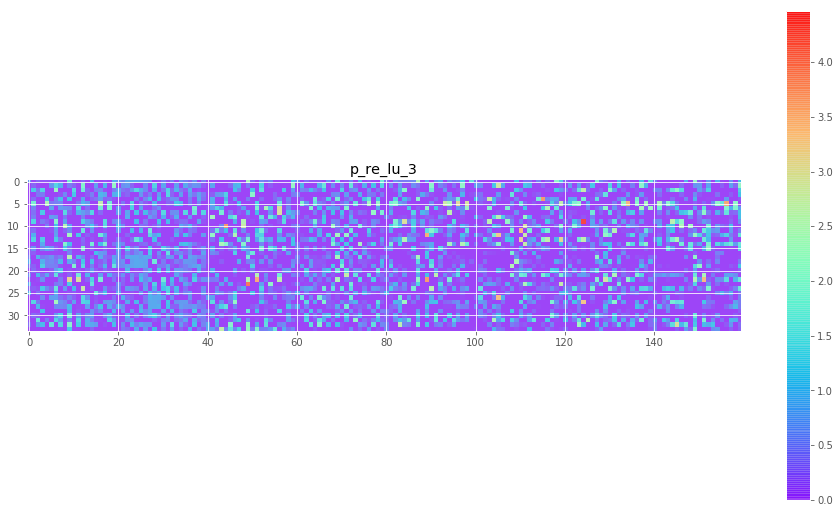

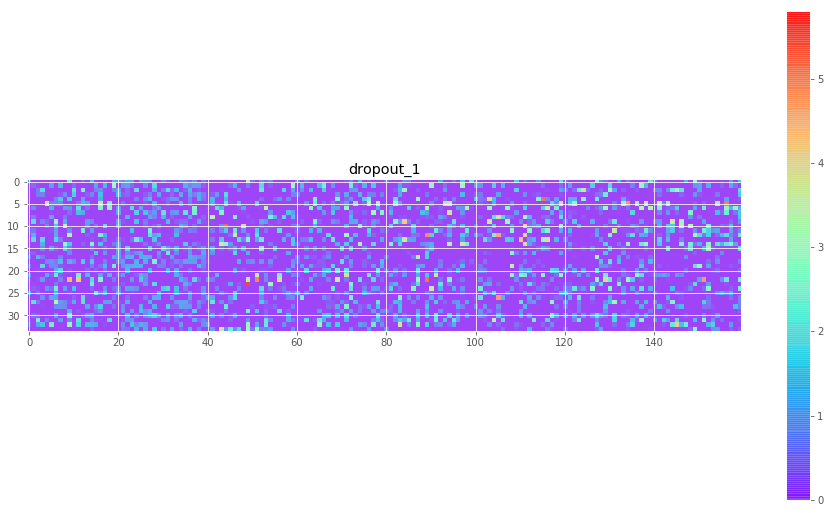

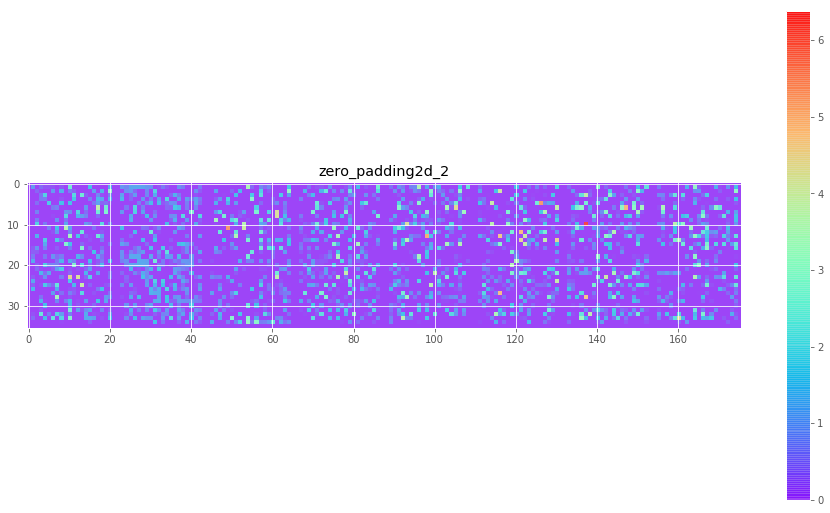

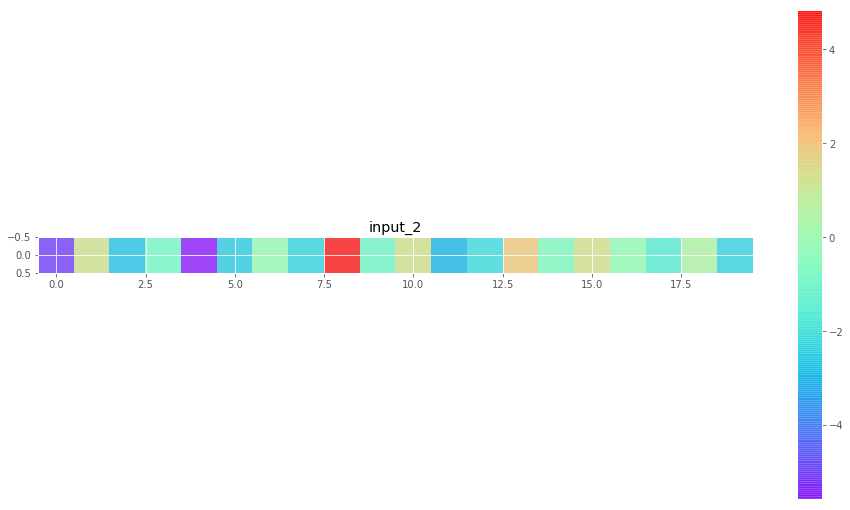

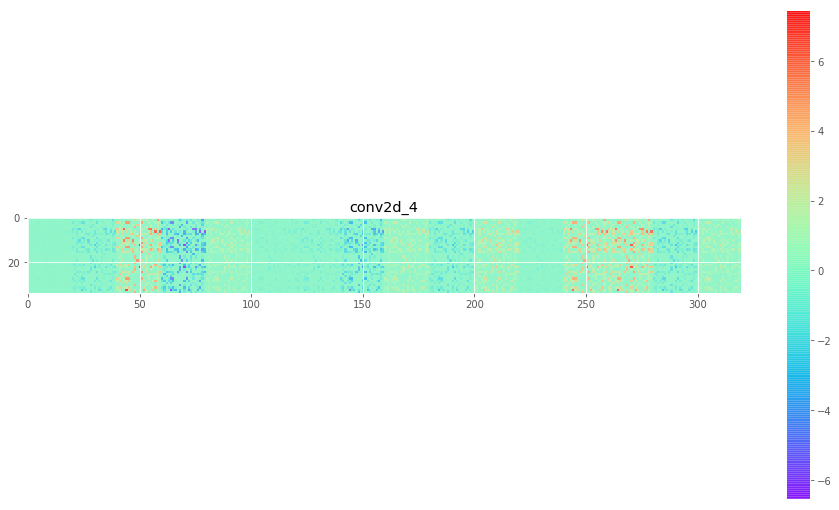

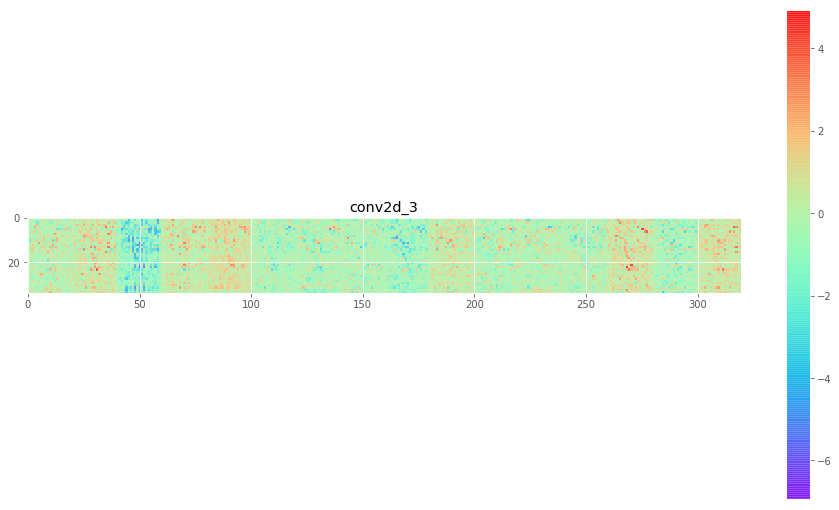

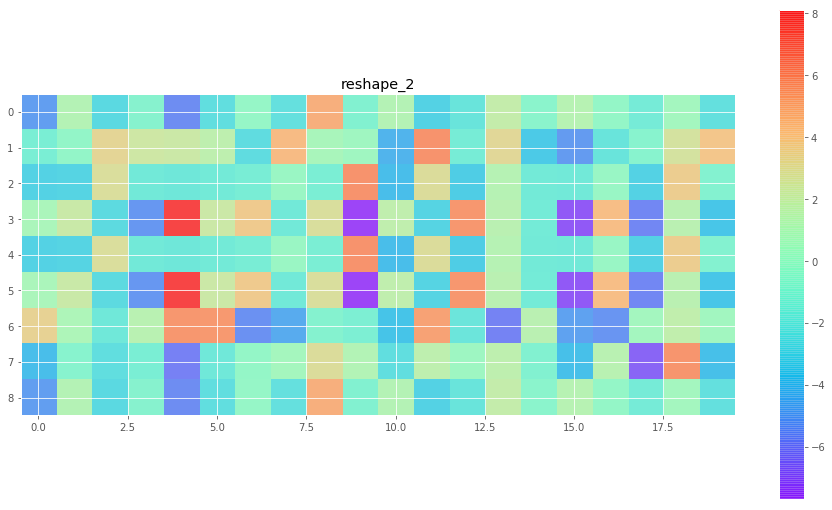

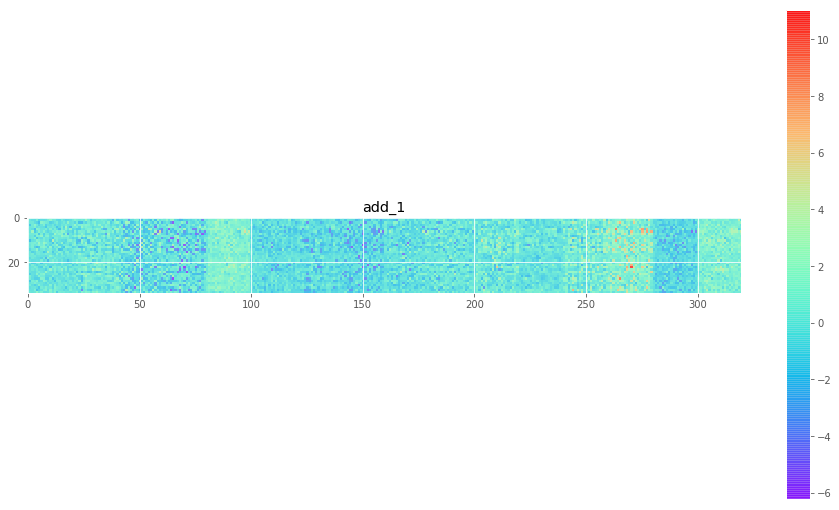

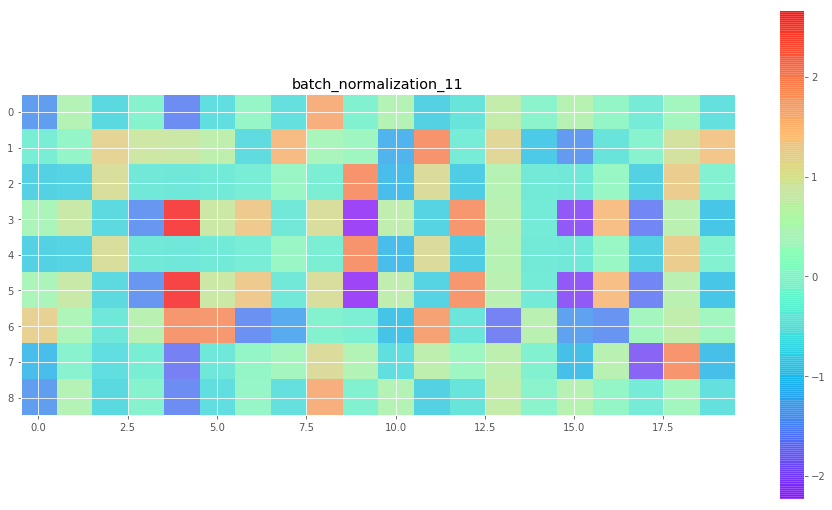

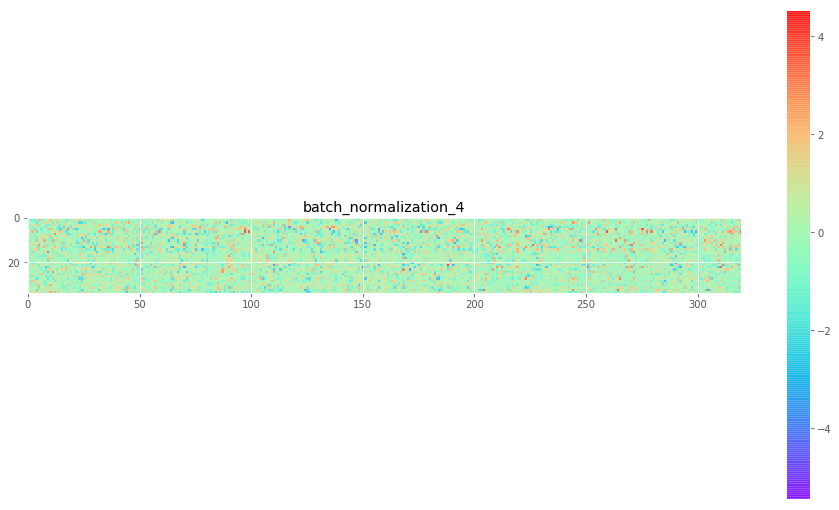

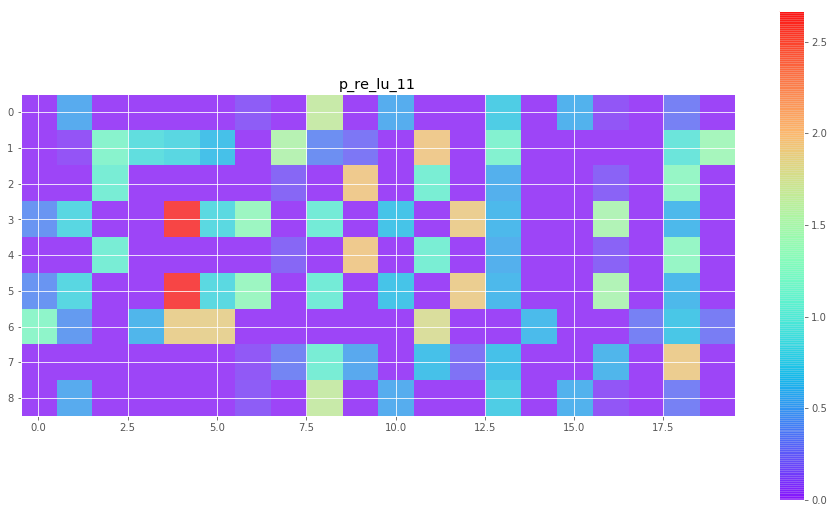

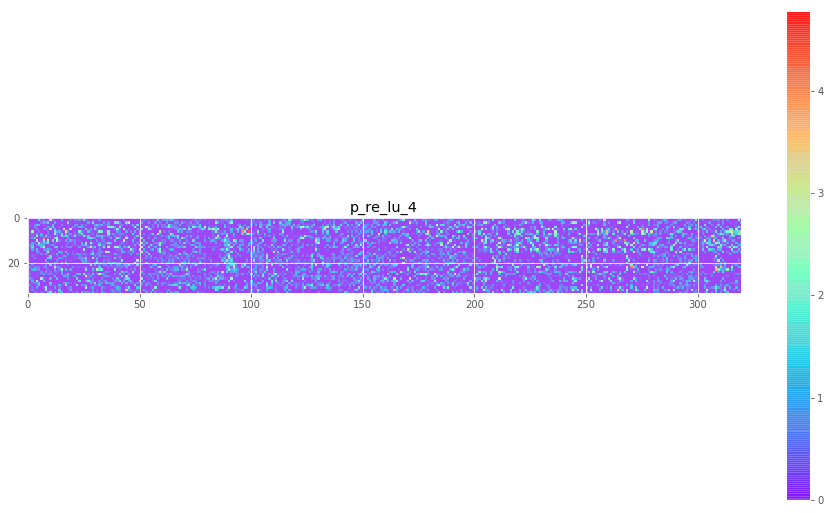

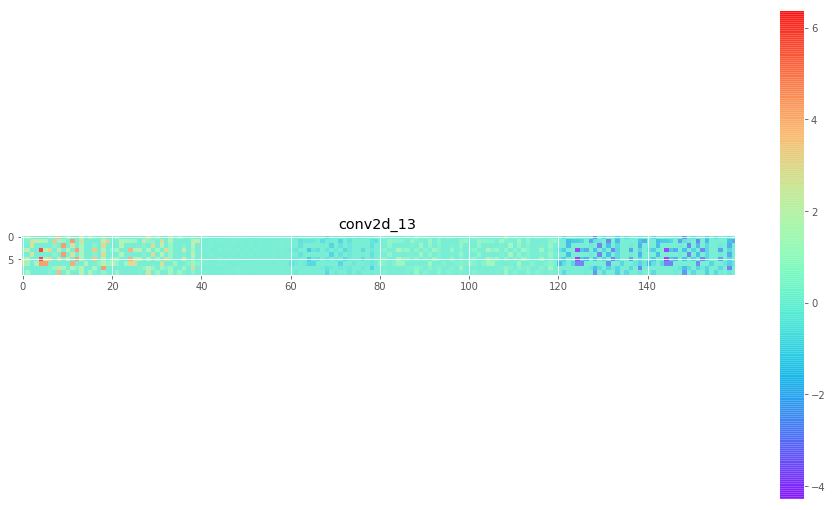

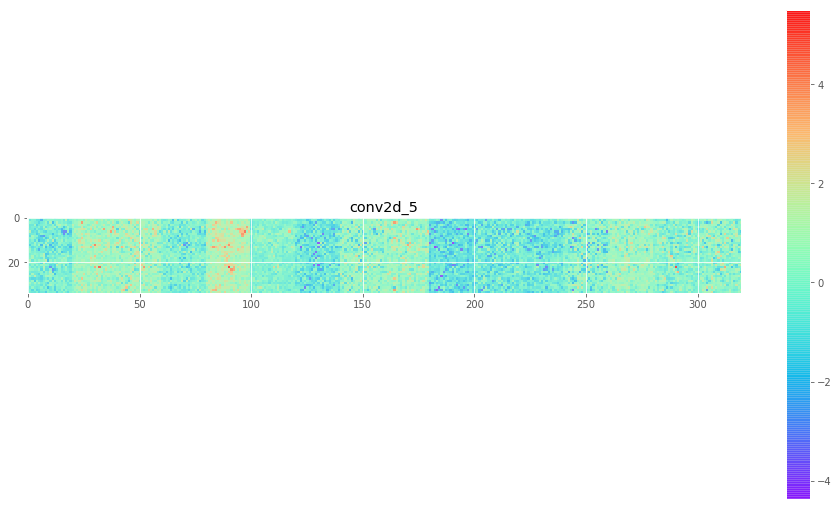

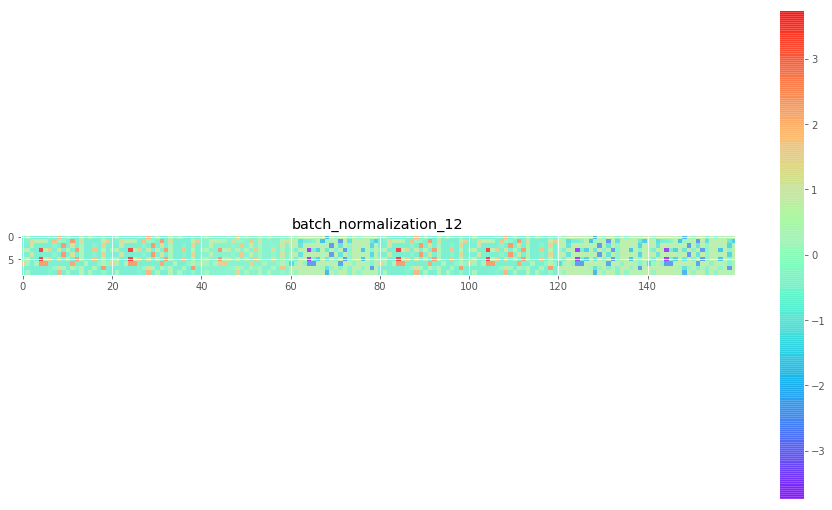

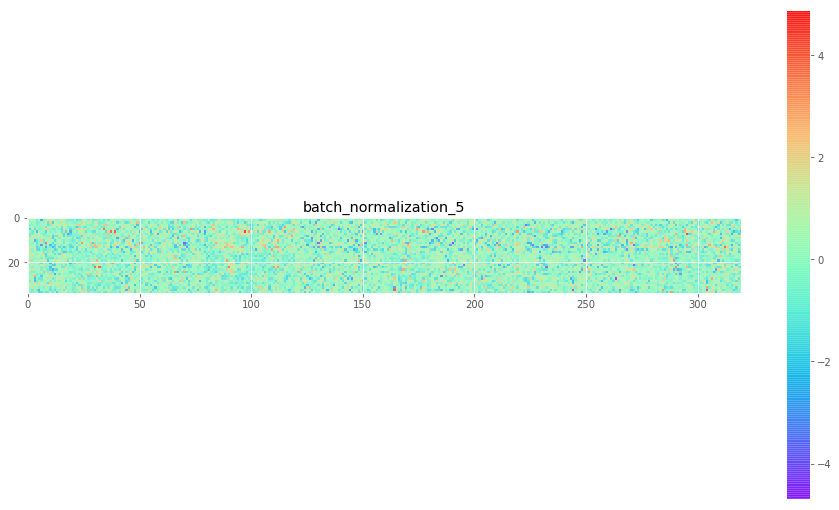

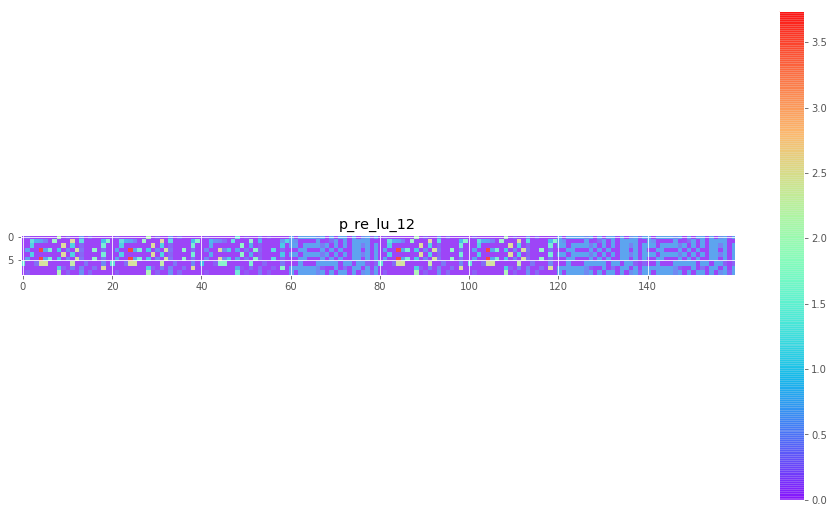

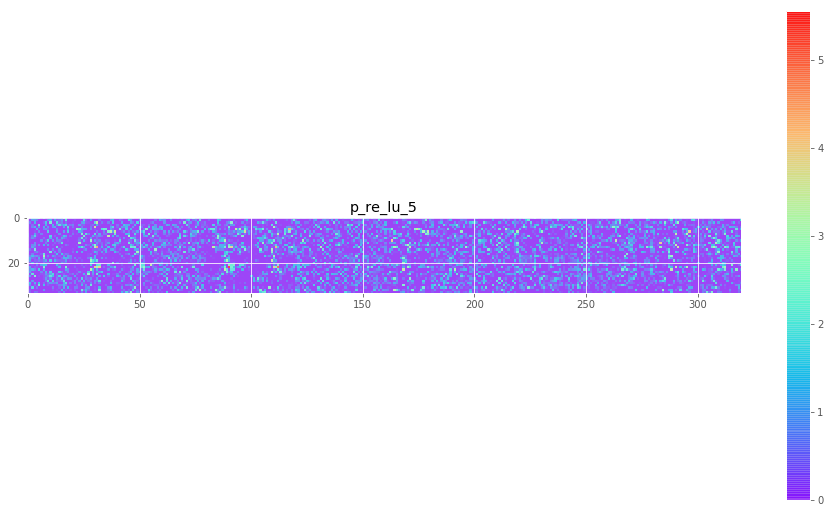

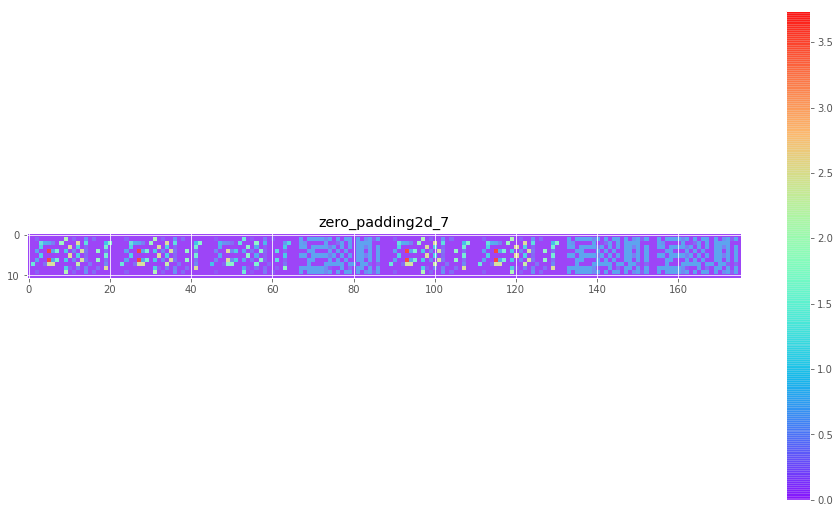

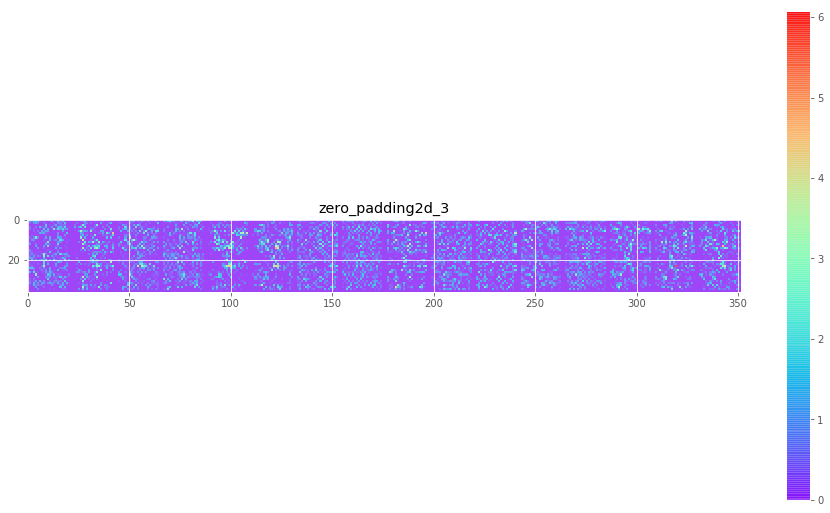

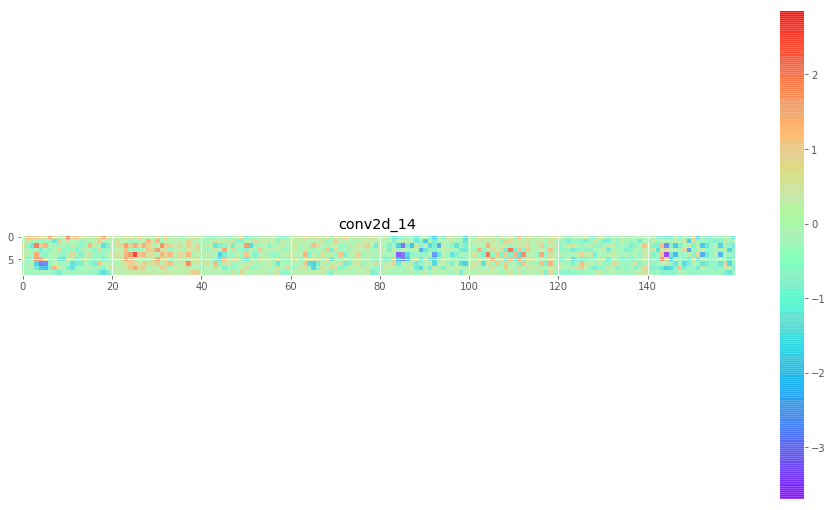

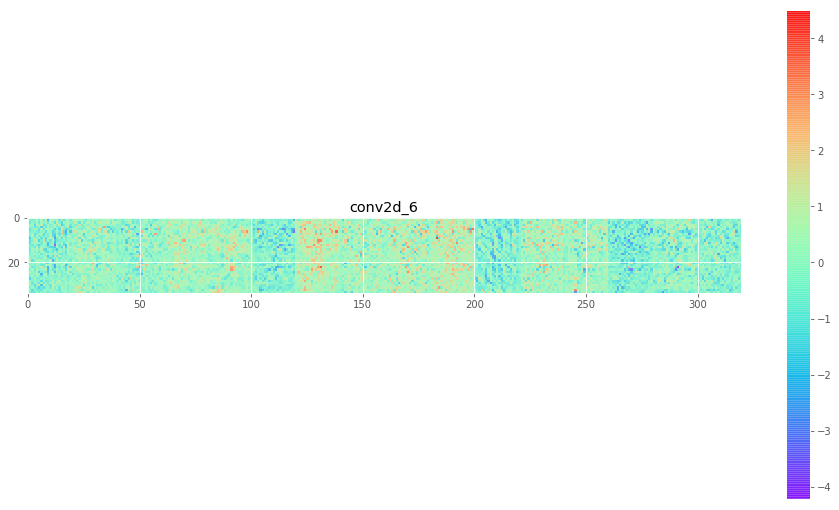

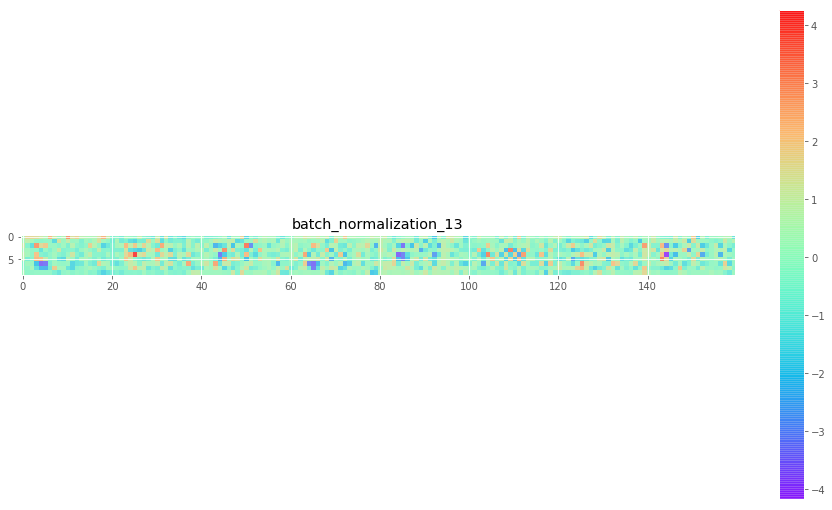

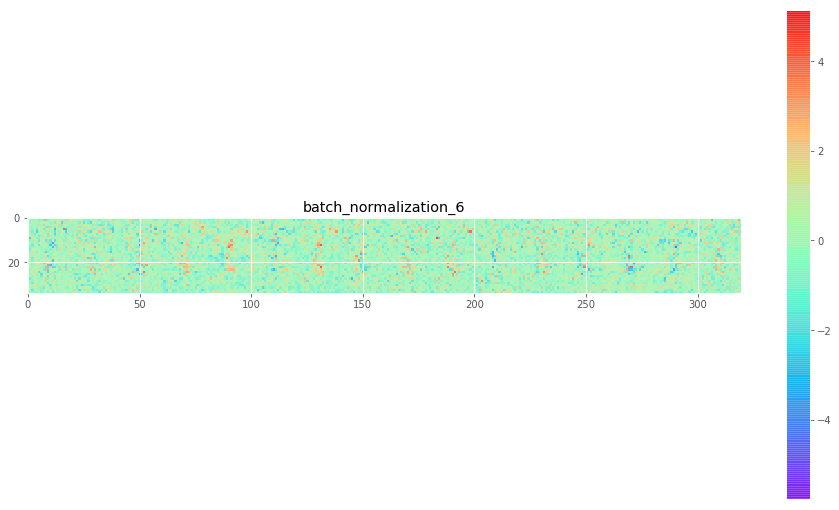

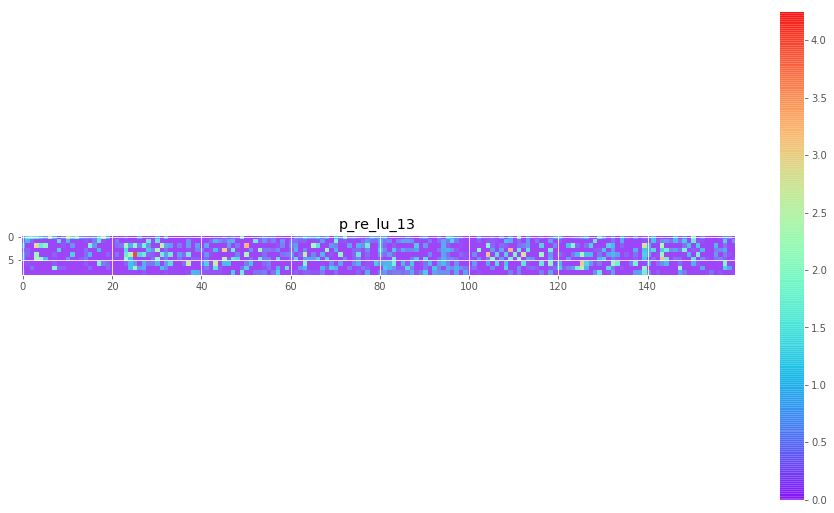

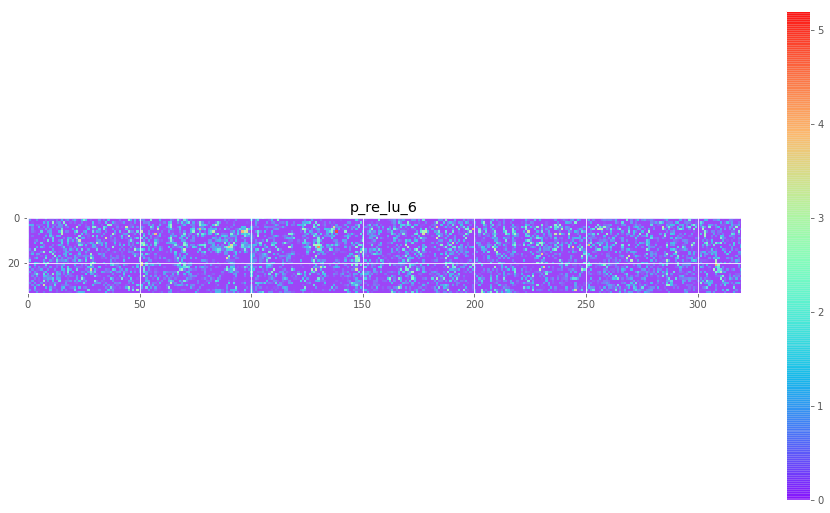

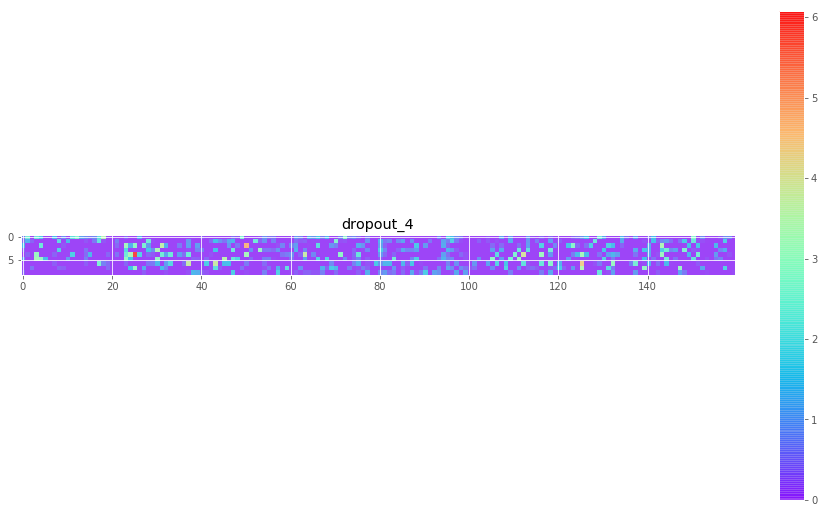

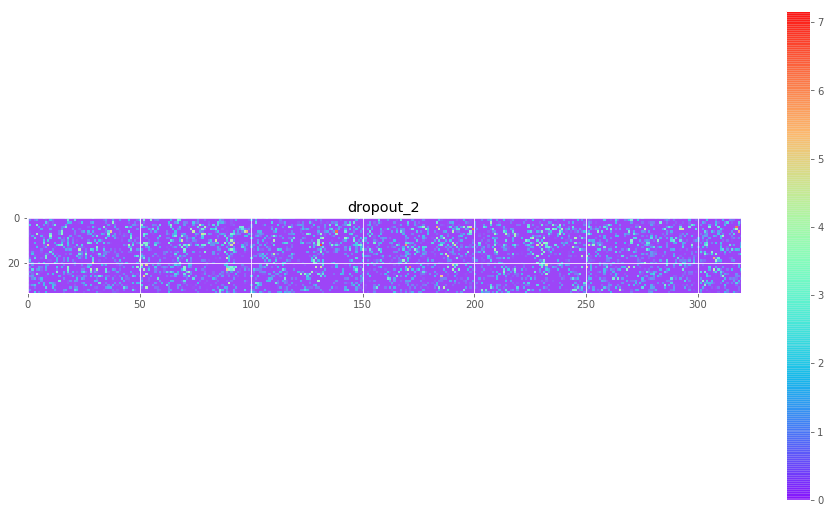

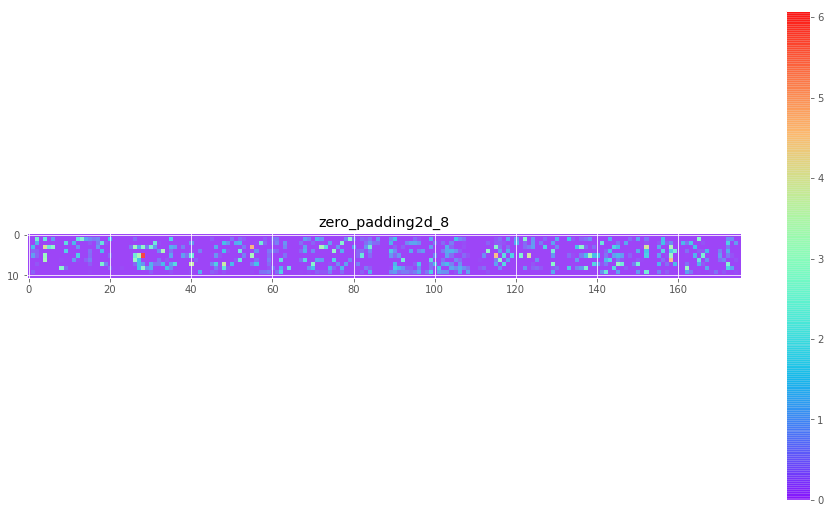

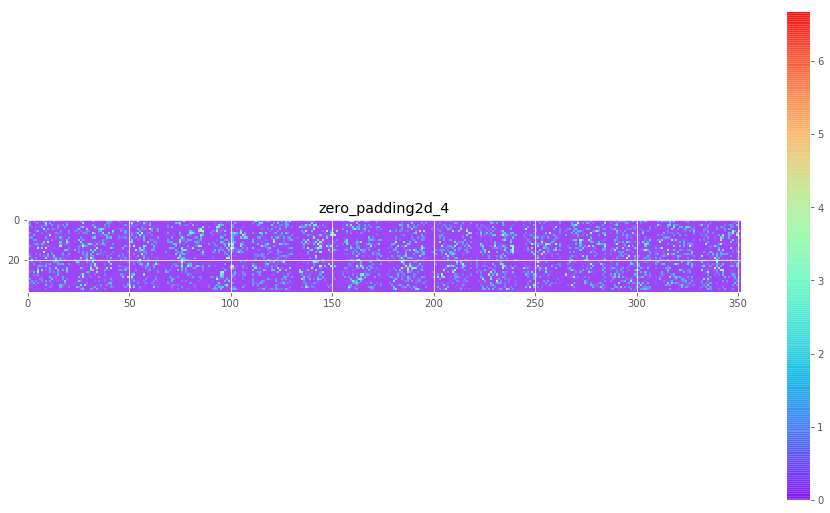

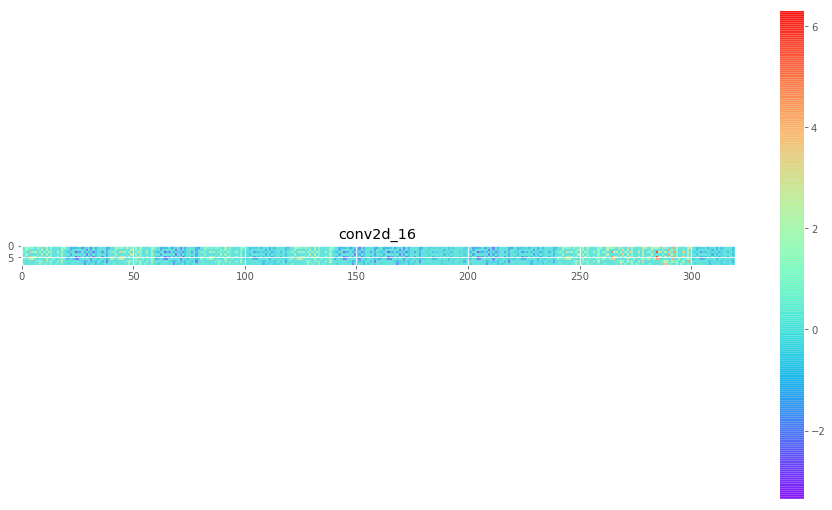

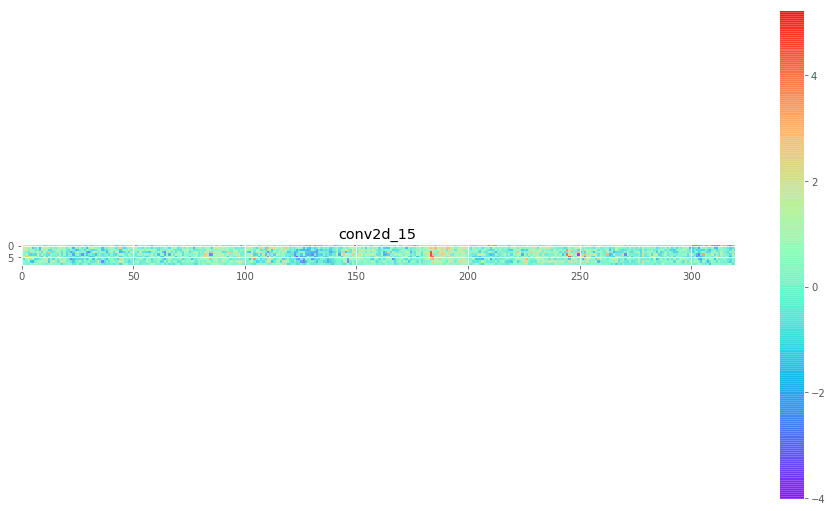

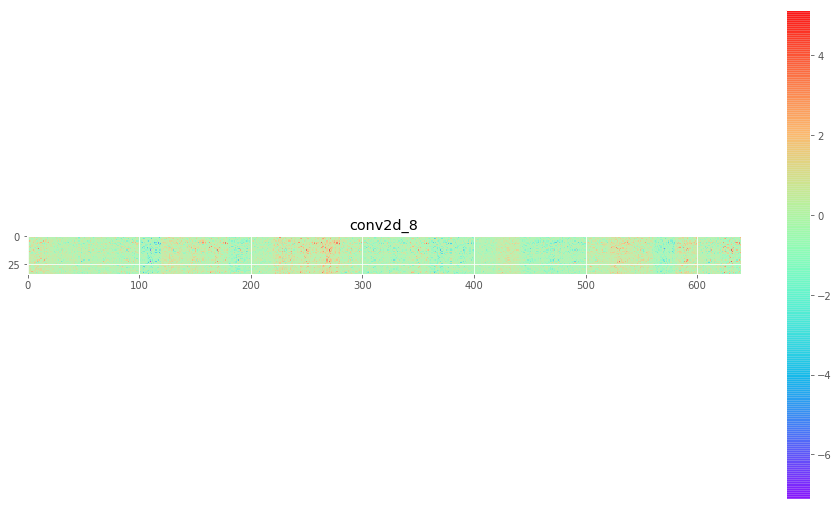

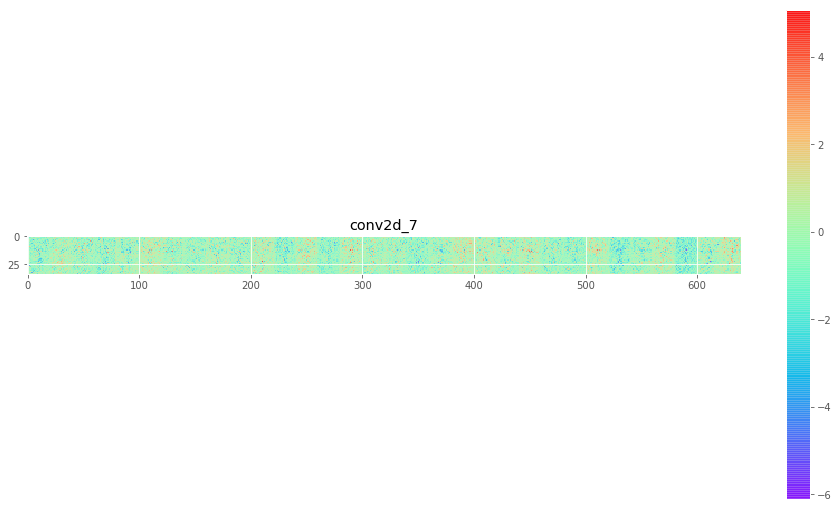

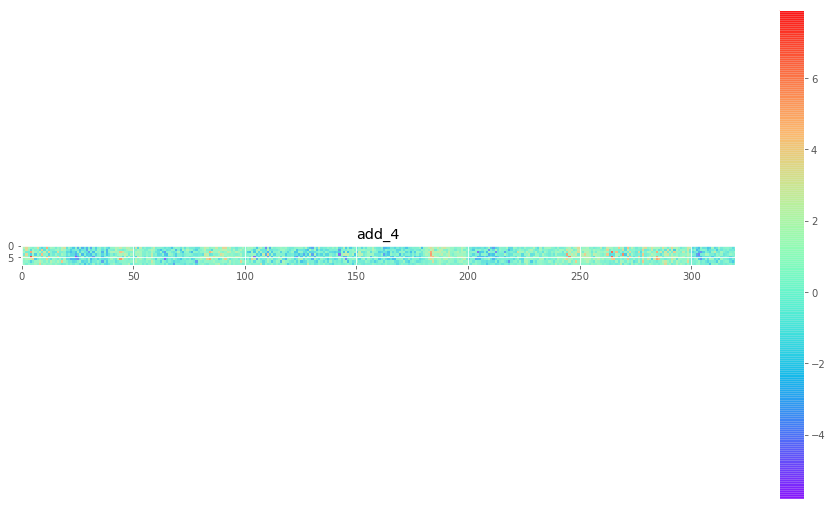

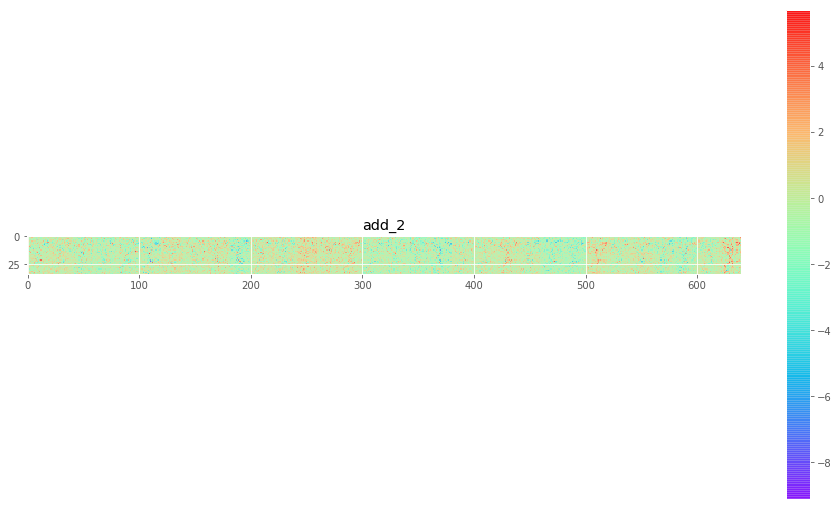

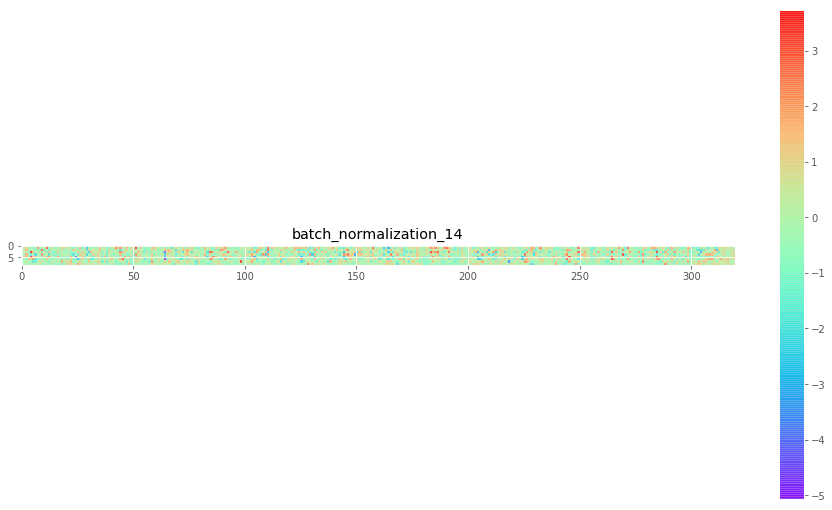

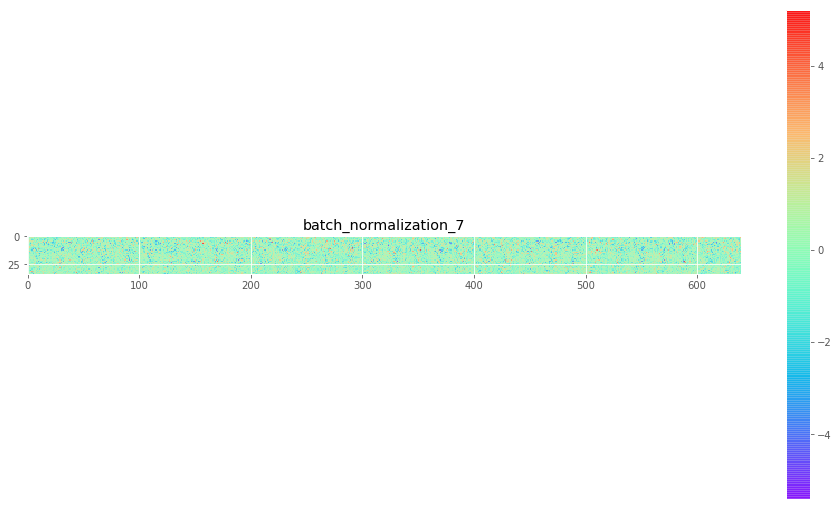

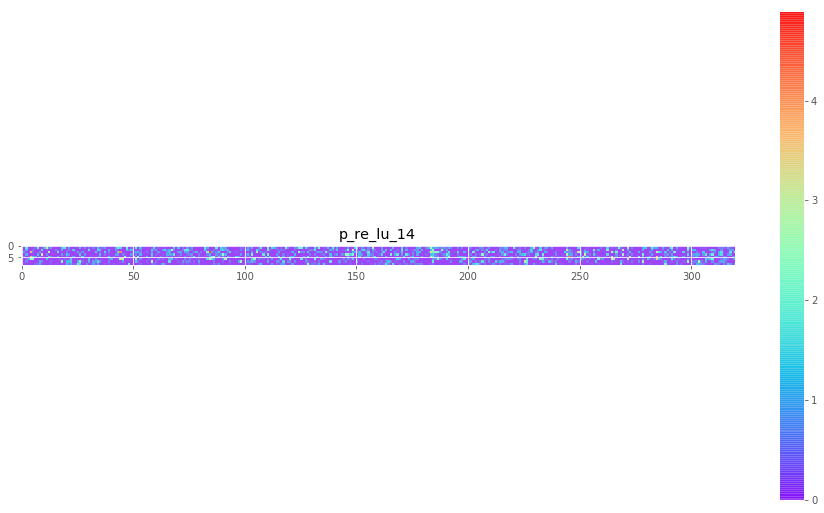

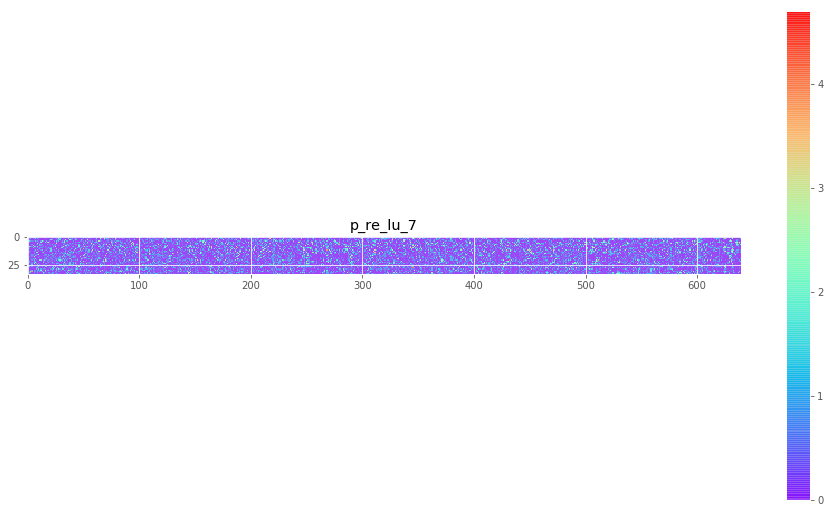

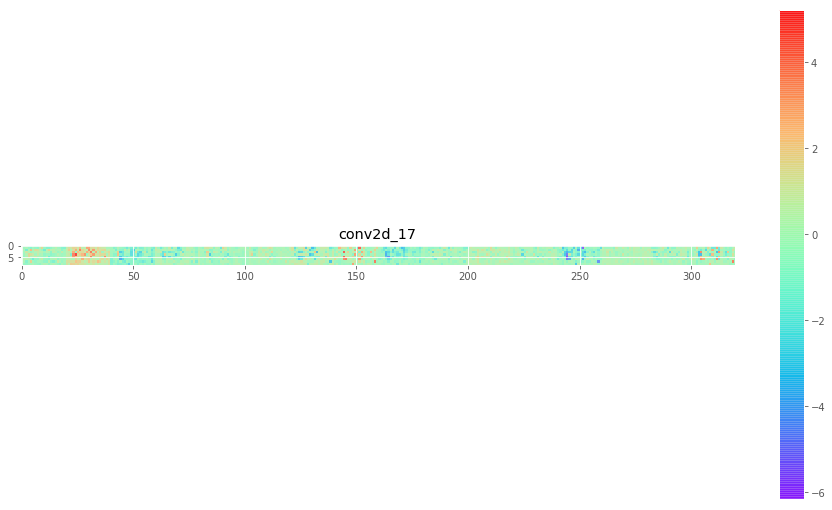

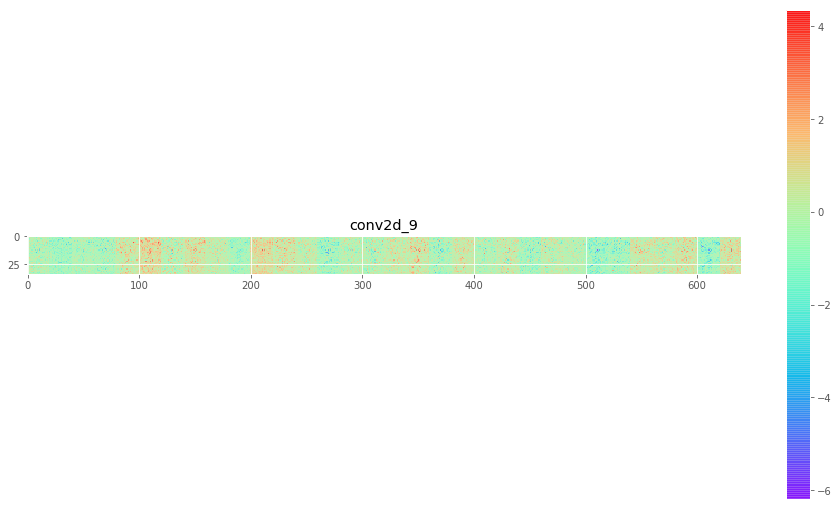

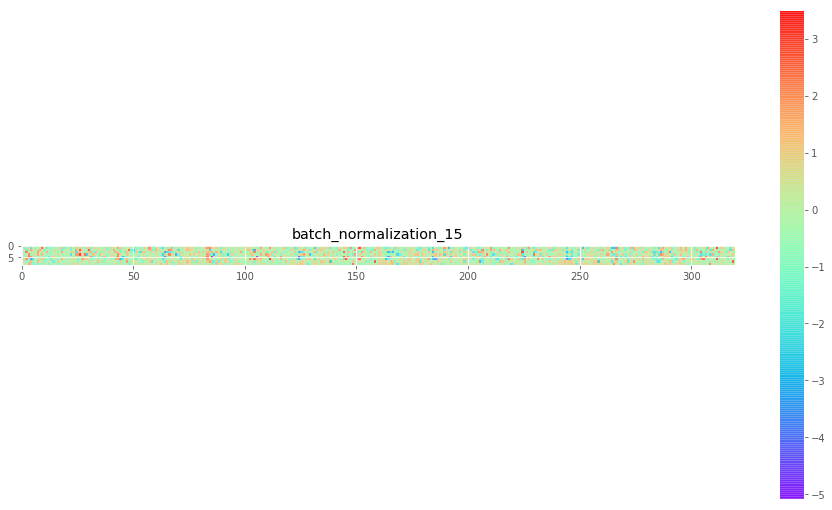

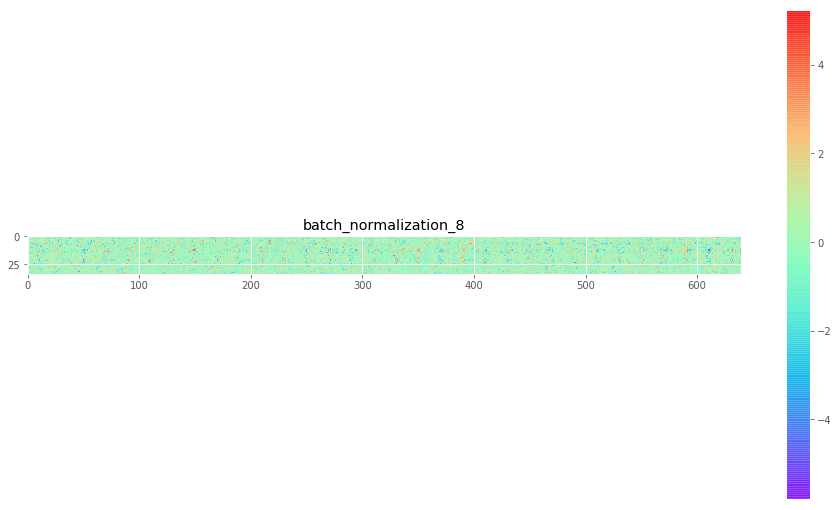

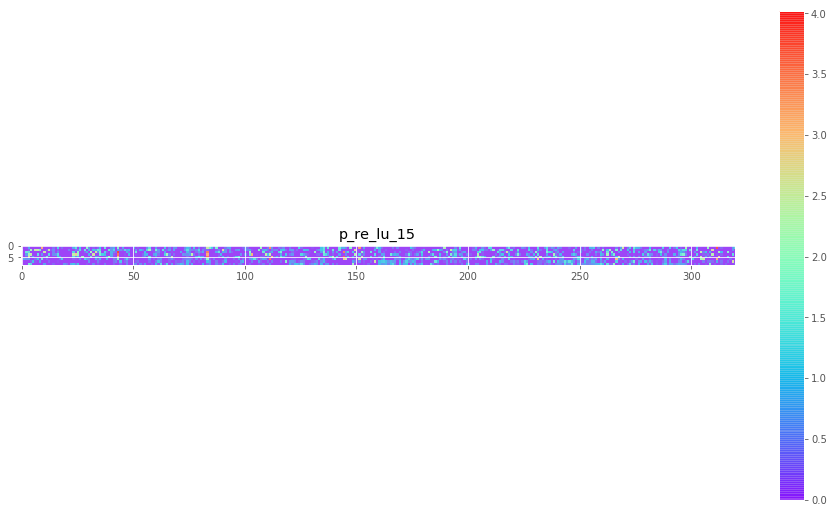

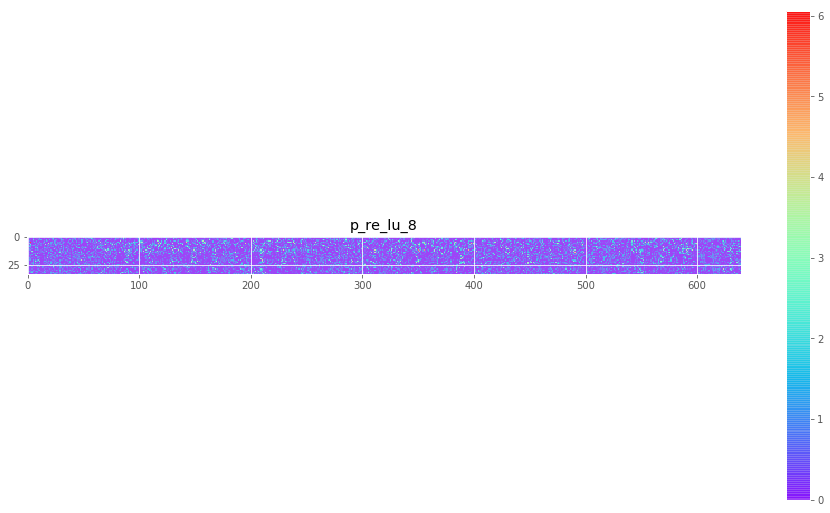

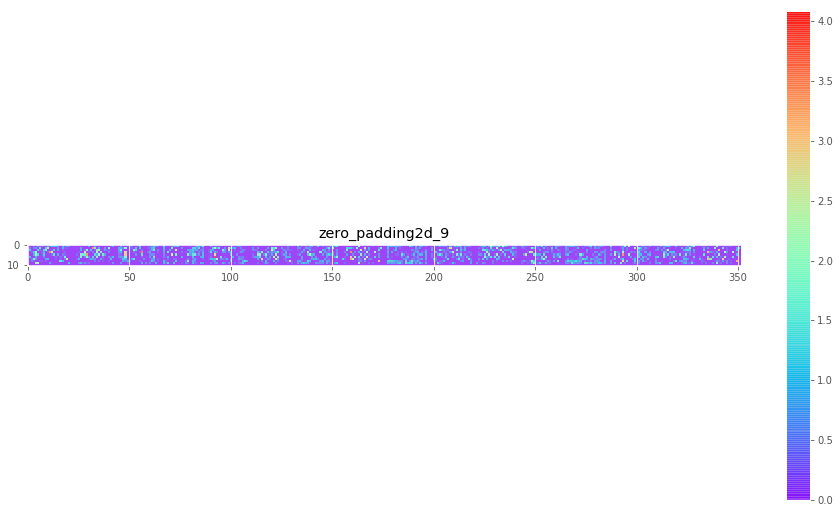

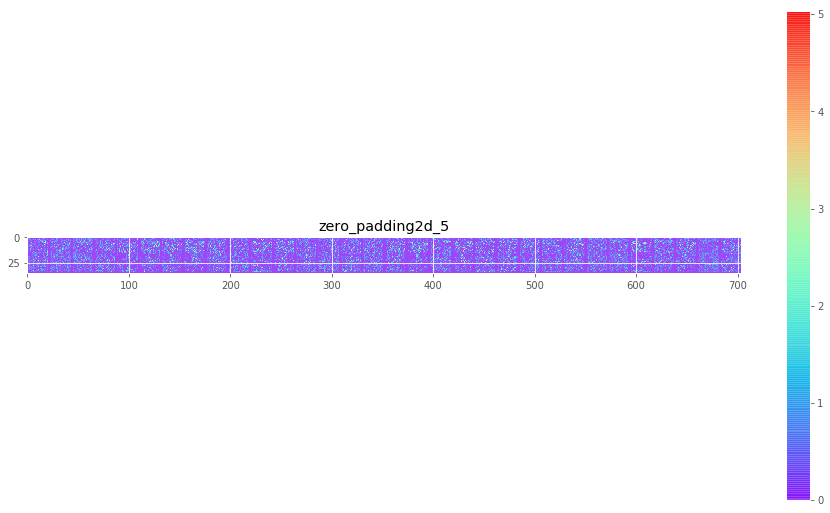

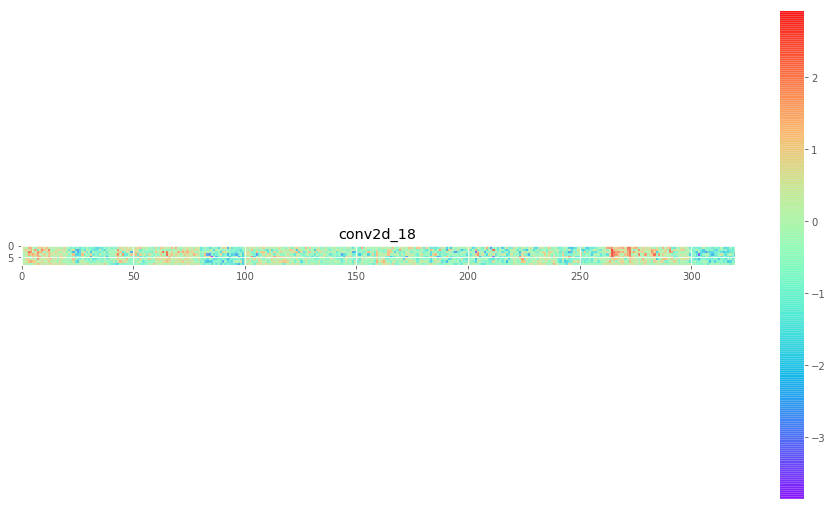

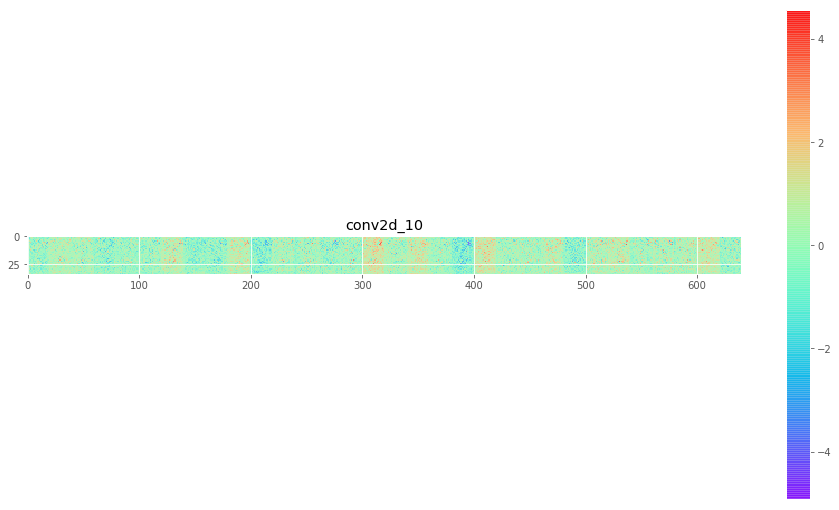

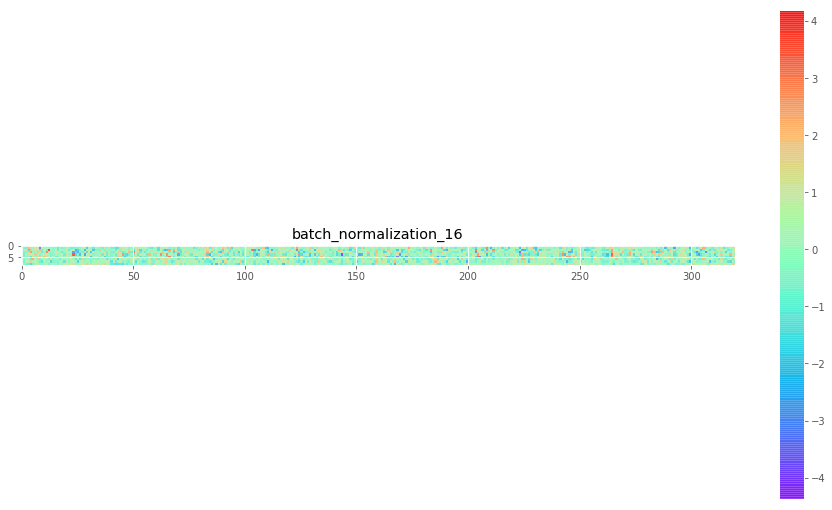

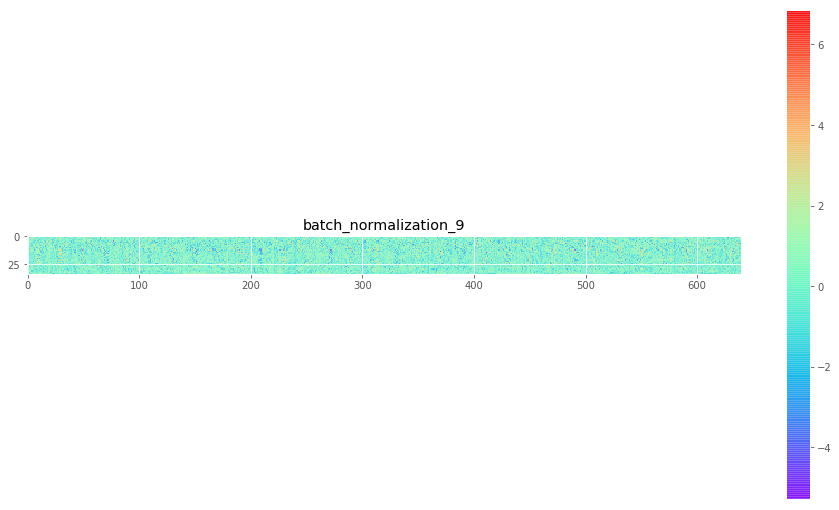

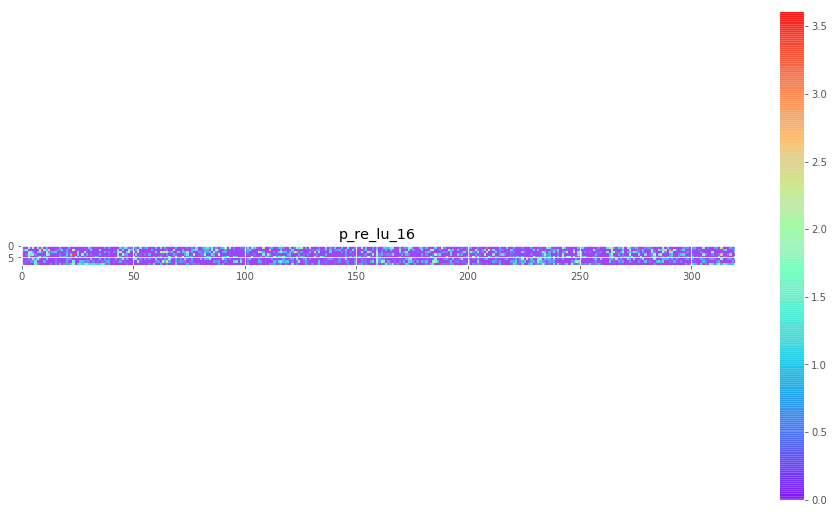

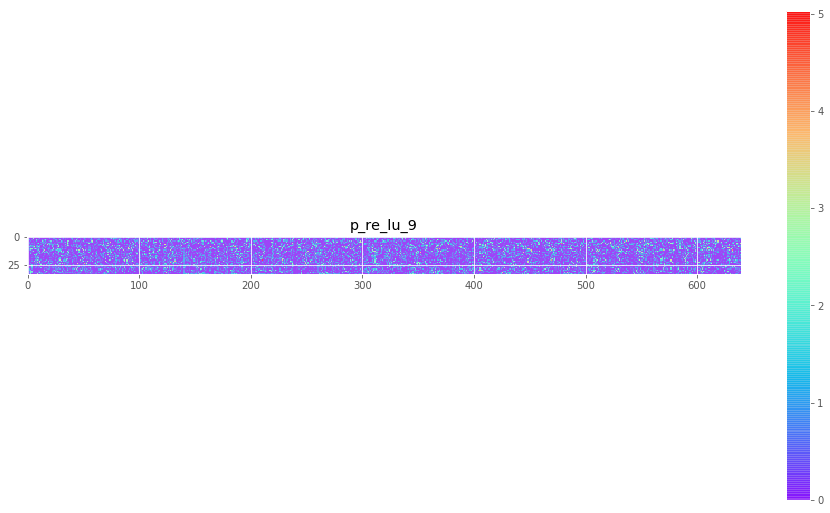

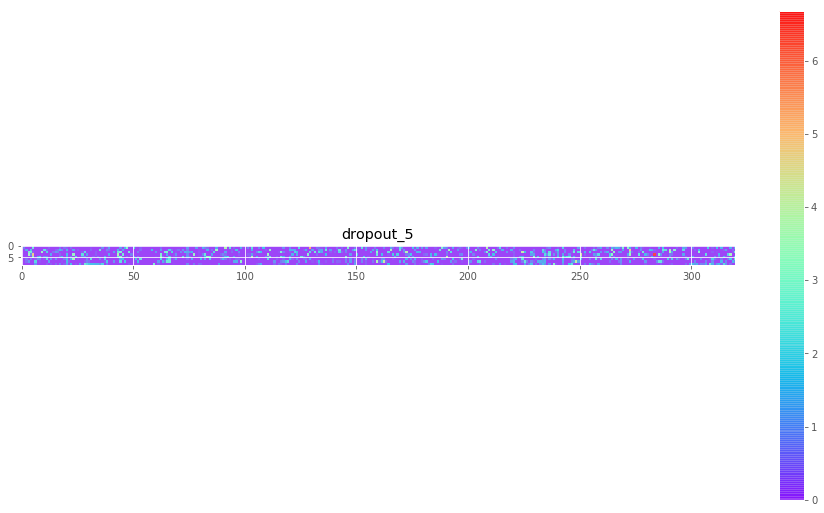

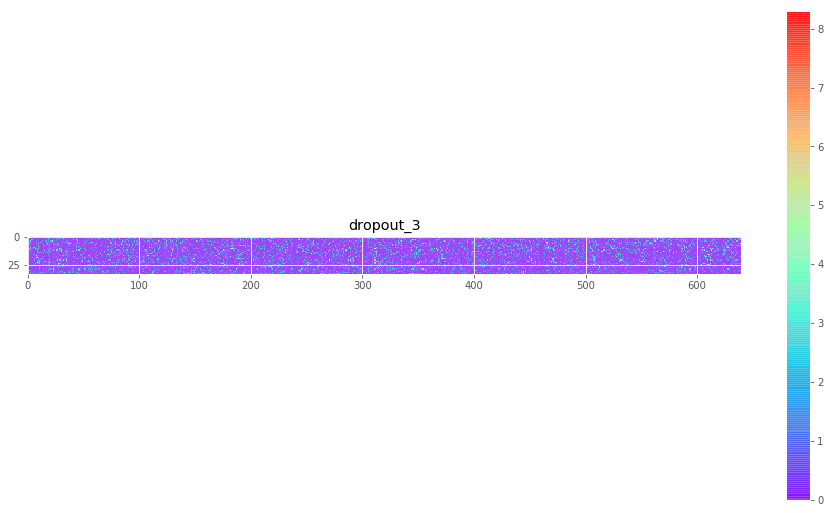

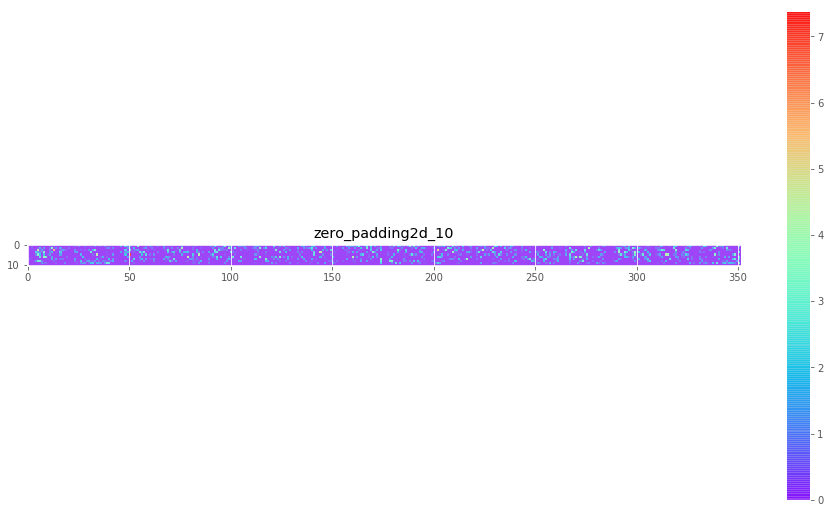

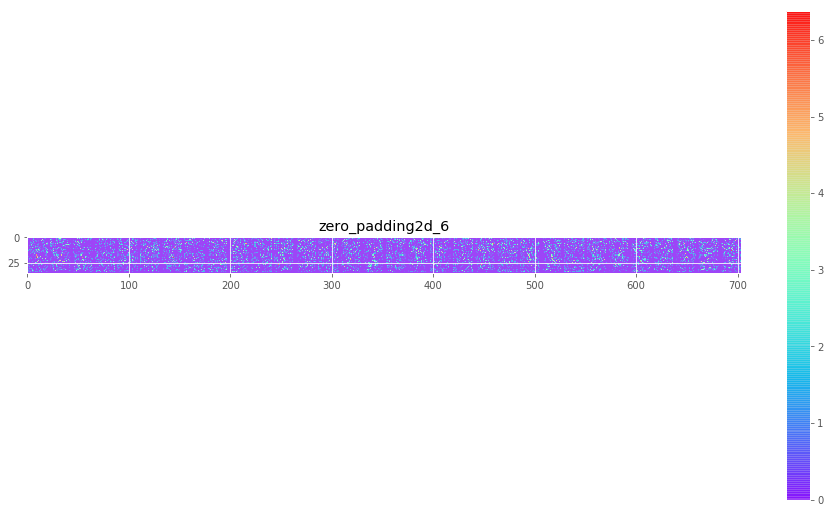

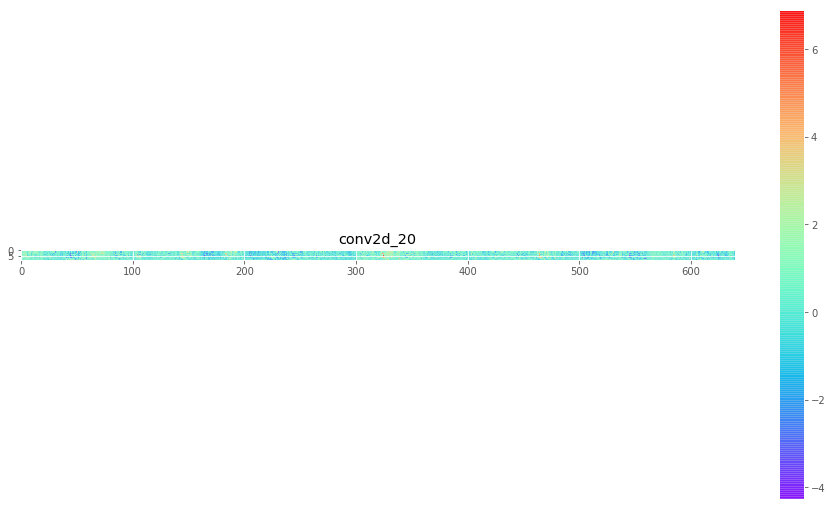

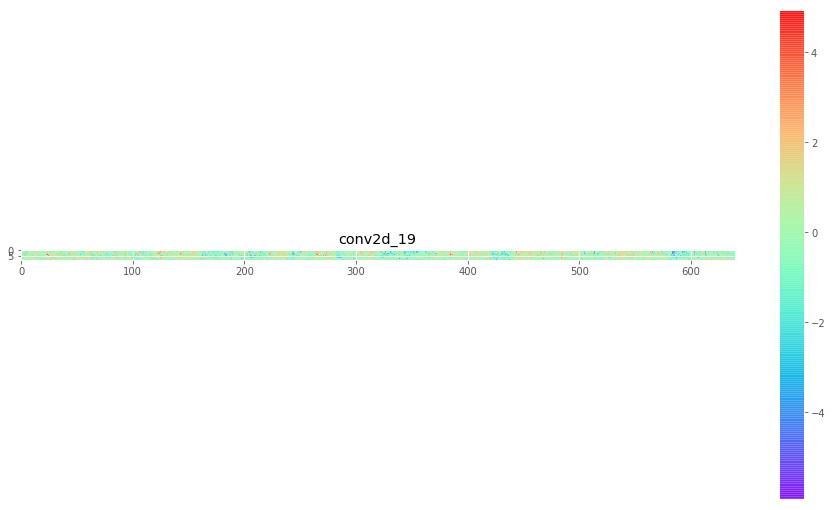

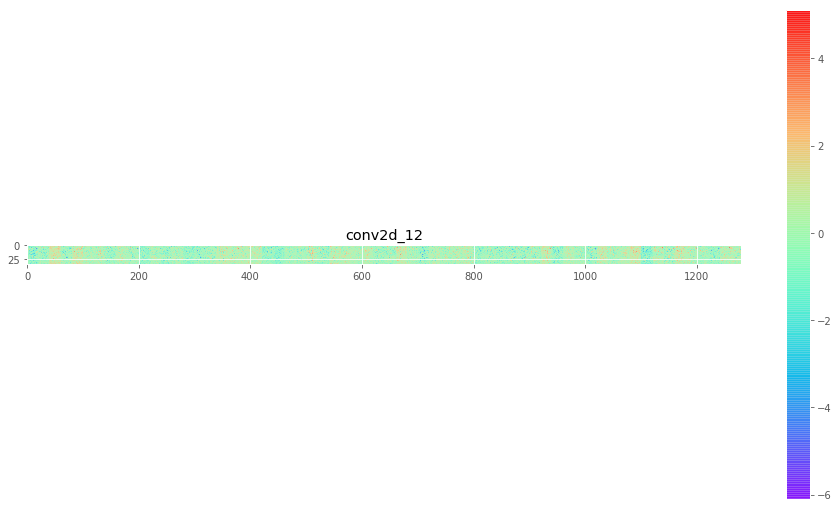

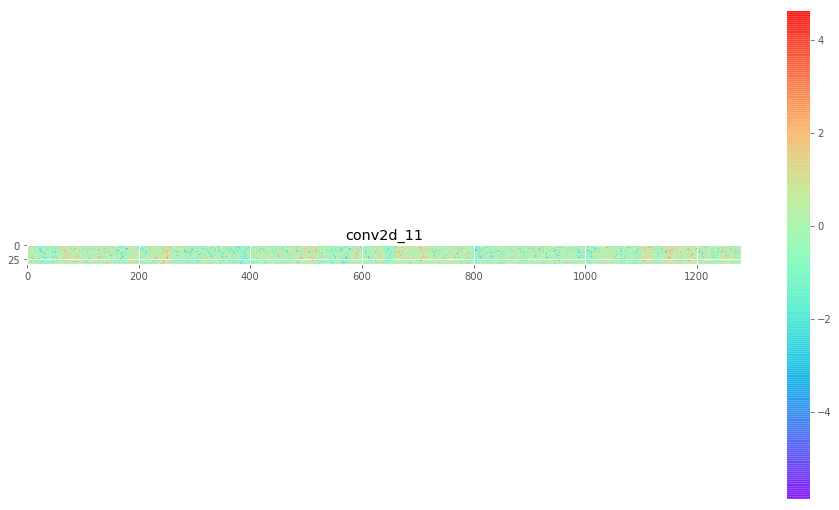

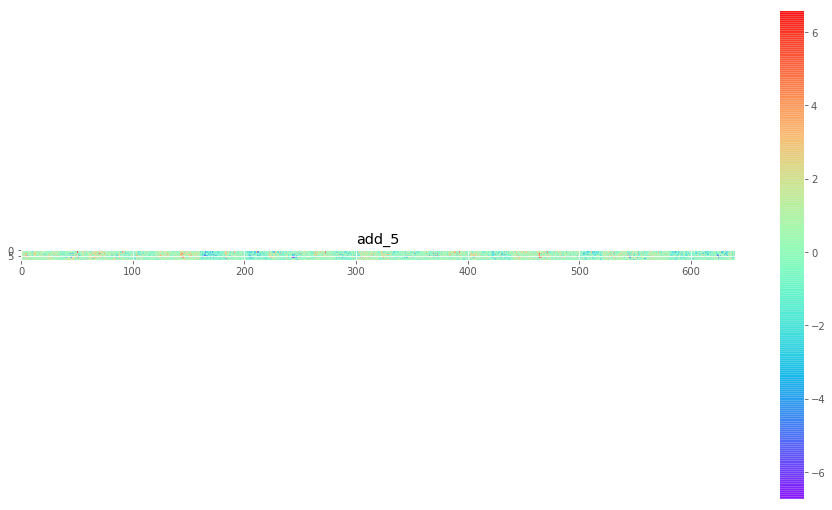

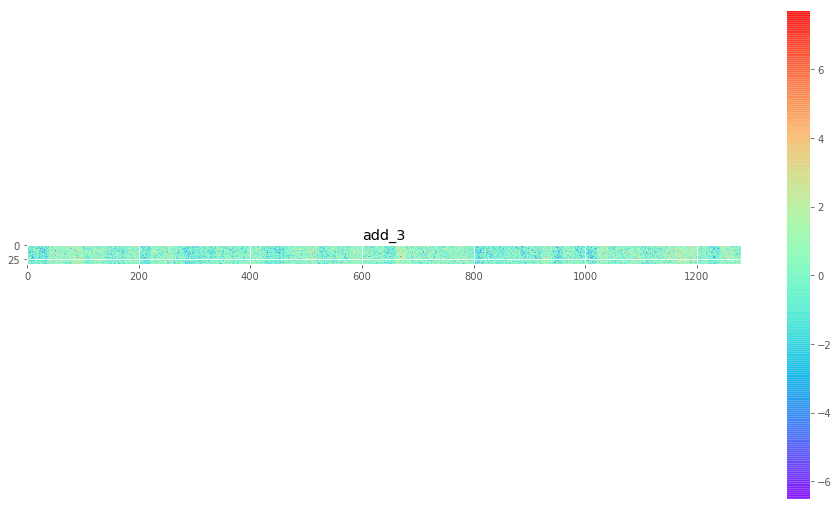

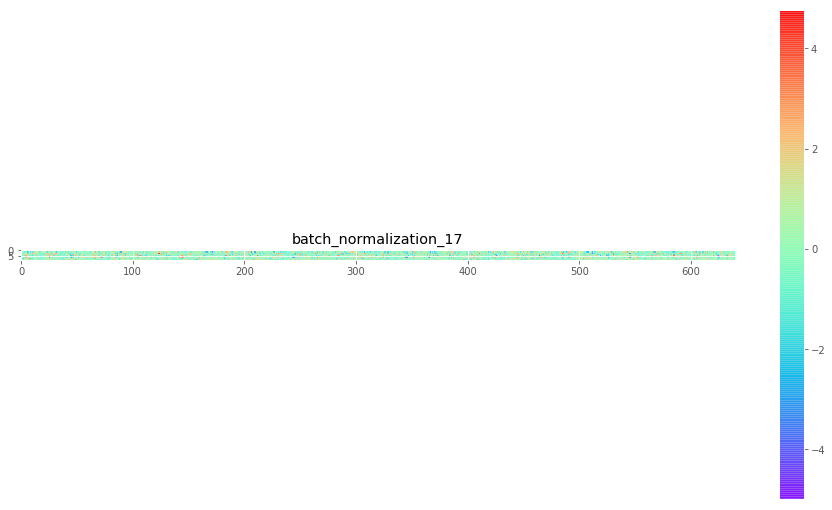

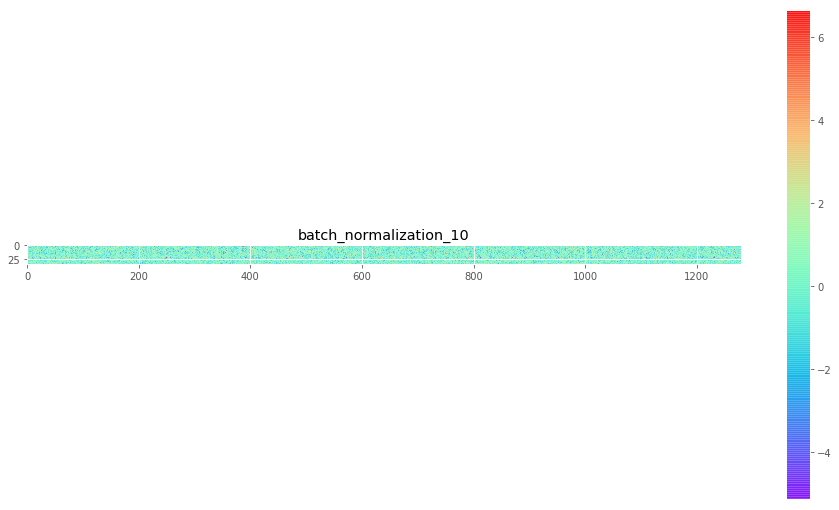

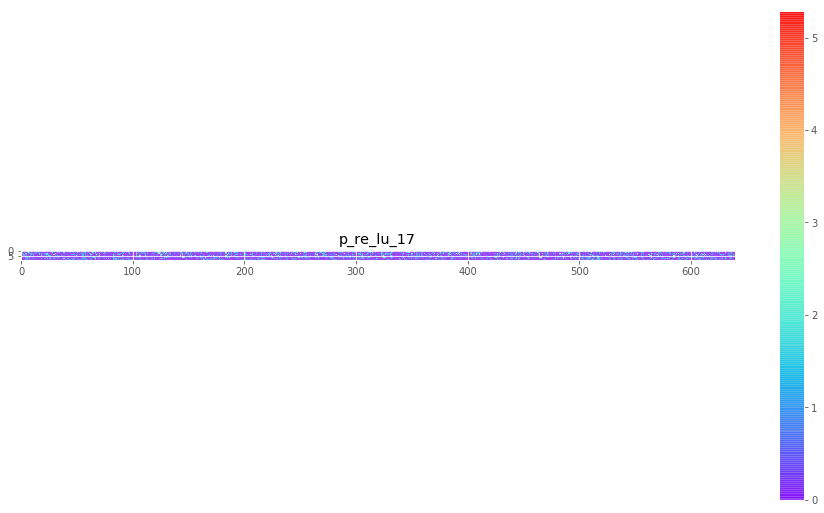

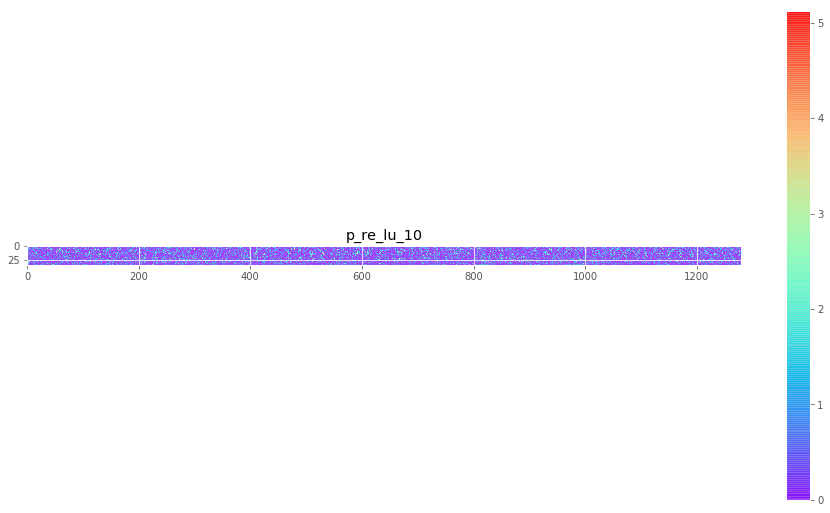

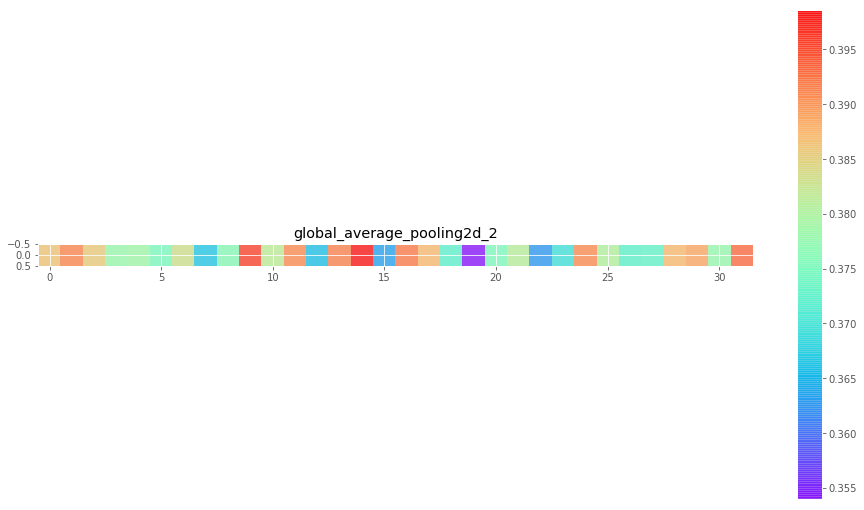

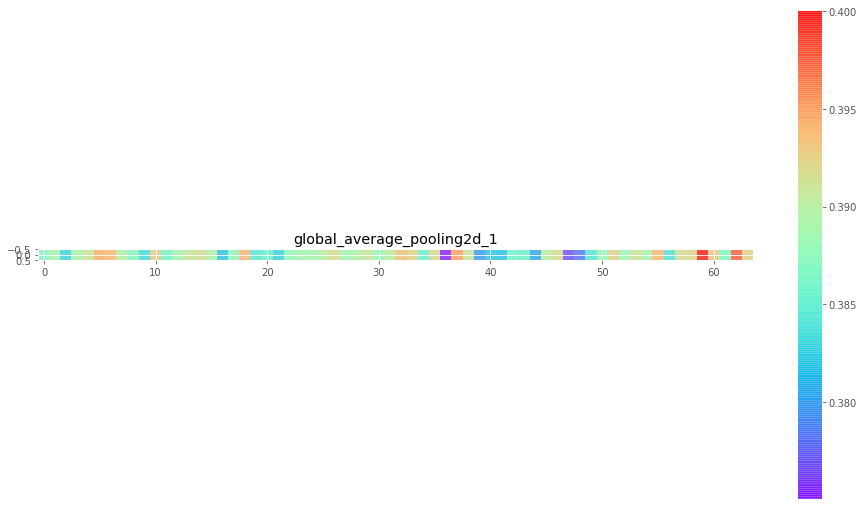

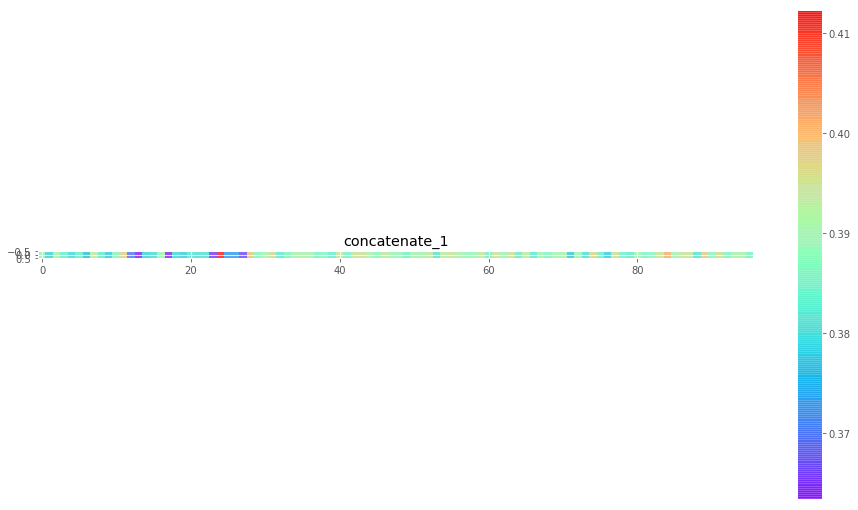

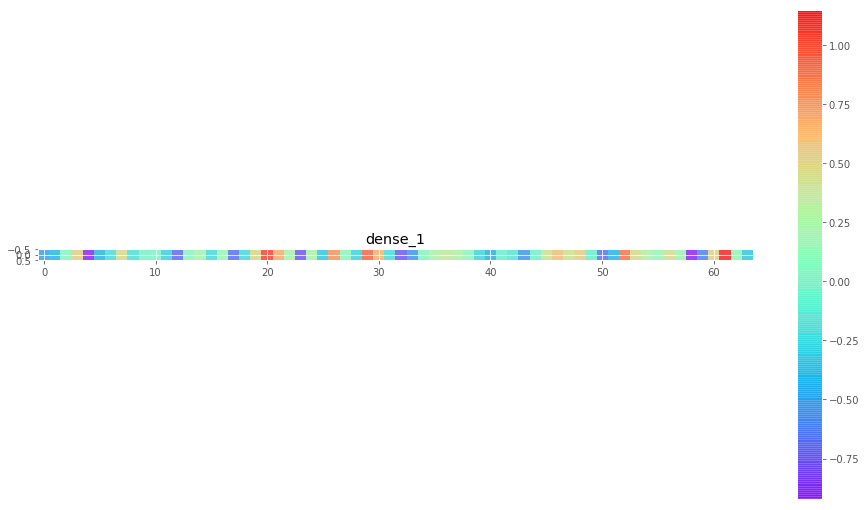

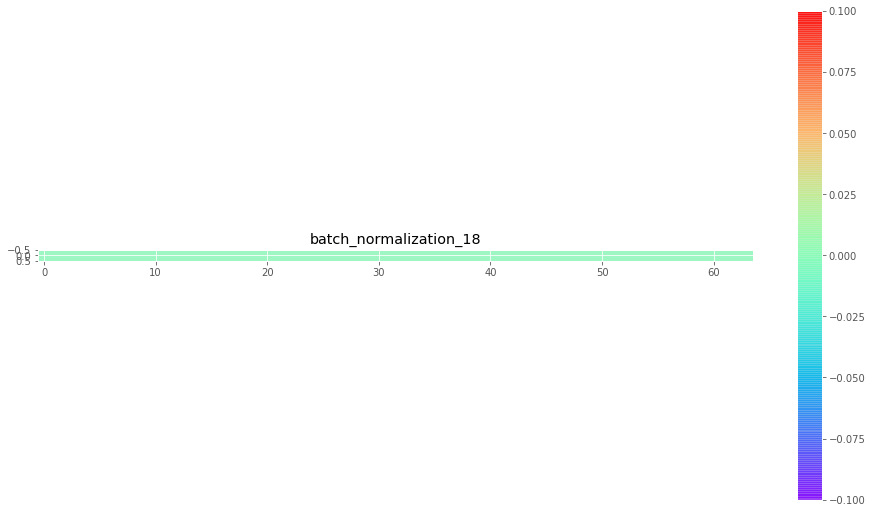

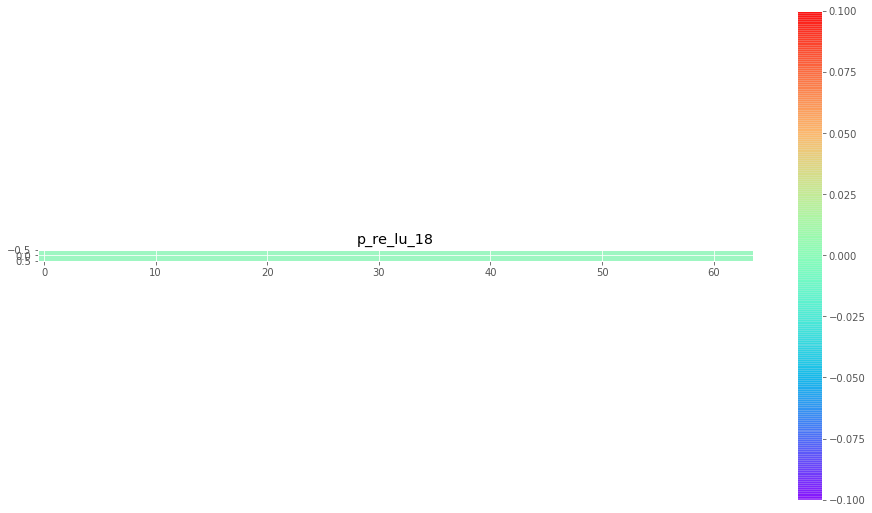

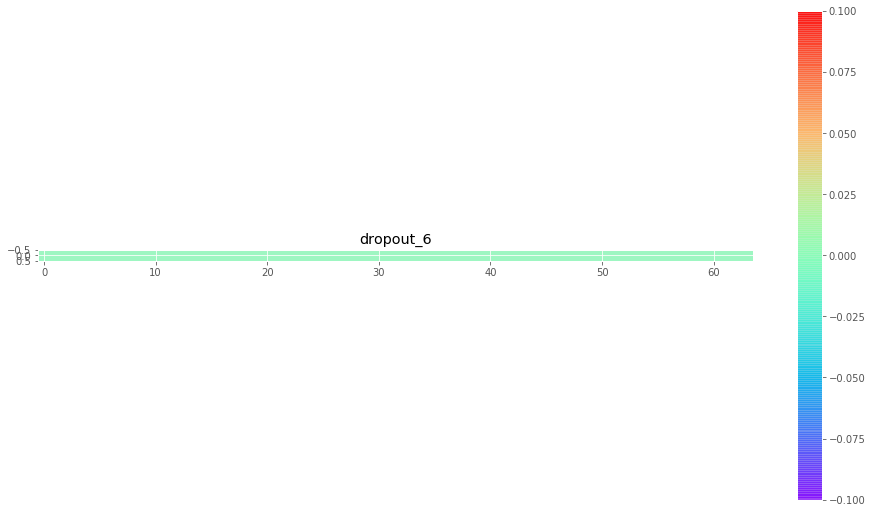

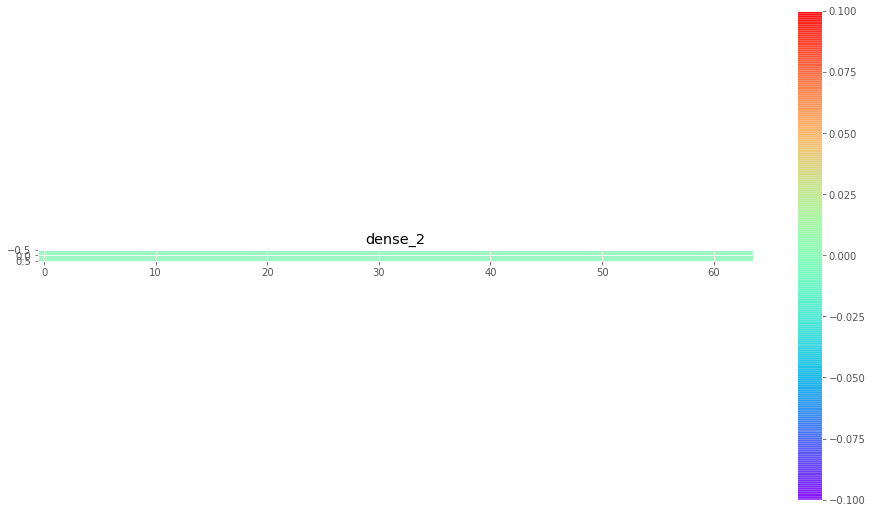

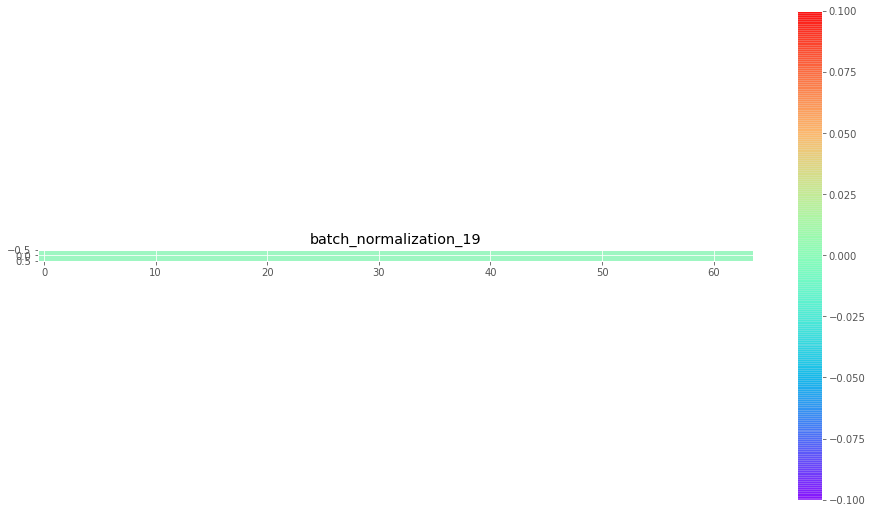

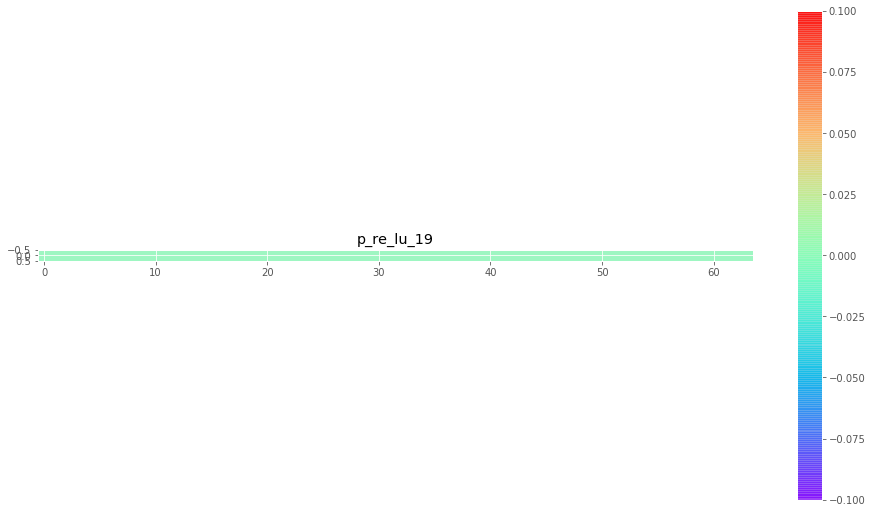

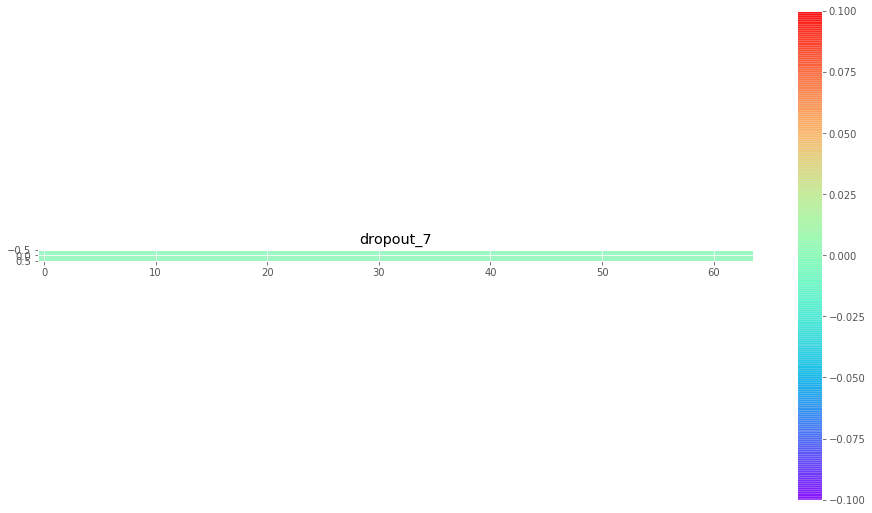

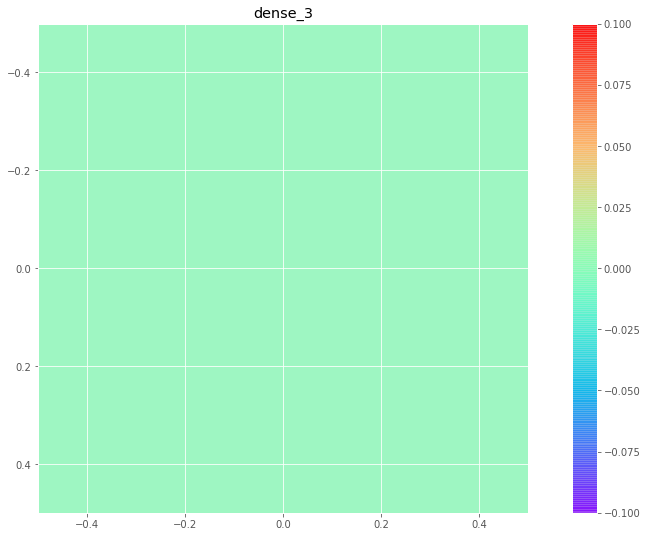

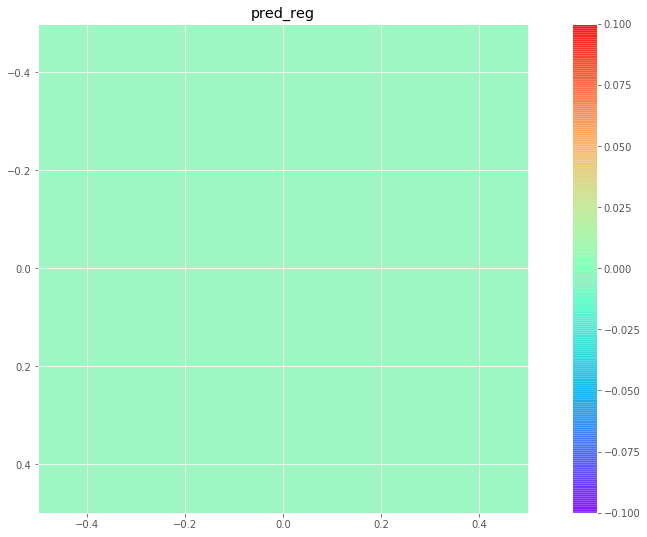

In [27]:
display_activations(strong_acts_new)

In [23]:
weak_acts_new = []
for i in weak_acts:
    if len(i.shape) == 3:
        _, a, b = i.shape
        weak_acts_new.append(i.reshape(a, b))
    else:
        weak_acts_new.append(i)

In [24]:
strong_acts_new = []
for i in strong_acts:
    if len(i.shape) == 3:
        _, a, b = i.shape
        strong_acts_new.append(i.reshape(a, b))
    else:
        strong_acts_new.append(i)

In [21]:
x_mhc = np.load("./mhystic/x_mhc.npy")
x_pep = np.load("./mhystic/x_pep.npy")

In [1]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
plt.style.use("ggplot")

%matplotlib inline

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
def plot_peptide_tsne(data, labels, description):
    
    """
    arguments:
    
    performance - 
    data - DataFrame with data for dimension reduction
    labels - np.array of colors for each point
    description - name for plot and npy array 
    
    --------
    function plot_peptide_tsne reduce dimension to 2 of high-dimensional representation in data and plots tsne 
    """
    """if len(data)/tsne.perplexity < 2.1:
        print(len(data)/tsne.perplexity)
        print("perplexity should be higher")
        return None"""
    
    tsne_repr = tsne.fit_transform(data.astype(np.float64))#.as_matrix())
    #np.save('{}_tsne.npy'.format(description), tsne_repr)
    
    plt.figure(figsize=(16, 9))
    plt.title("t-SNE visualisation of {}".format(description))
    plt.scatter(tsne_repr[:,0], tsne_repr[:,1], c = labels, cmap='rainbow', alpha=1, s=500)
    plt.xlabel("t-SNE projection component 1")
    plt.ylabel("t-SNE projection component 2")
    plt.colorbar()
    #ax = plt.axis('off')
    for label, x, y in zip(properties.amino_acid, tsne_repr[:, 0], tsne_repr[:, 1]):
        plt.annotate(label, xy=(x+8, y+8), xytext=(0, 0), textcoords='offset points', size=10)
    plt.savefig('tsne_{}.png'.format(description), dpi='figure')

In [3]:
w2v_proteins = gensim.models.Word2Vec.load("./mhystic/w2v_models/up9mers_size_20_window_3.pkl")

In [13]:
properties = pd.read_csv("atchley.csv", sep="\t")
embds = []
for i in properties.amino_acid:
    embds.append(w2v_proteins[i])
embds = np.array(embds)

In [14]:
interesting = ["alpha", "beta", "charge", "core", "hydropathy", "pH",
               "polarity", "rim", "surface", "turn", "volume", "strength", "disorder", "high_contact"]

In [15]:
tsne = TSNE(n_jobs=2, verbose=100, perplexity=1, angle=0.5)

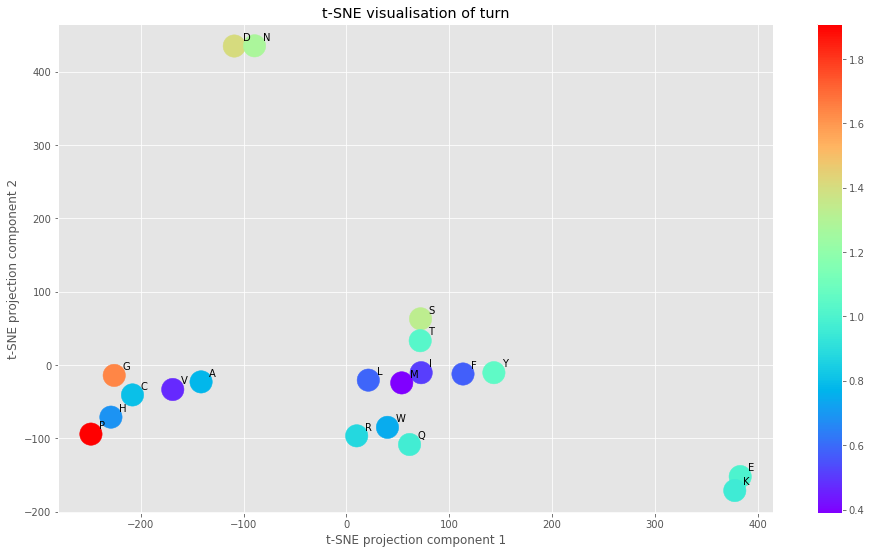

In [16]:
plot_peptide_tsne(embds, np.array(properties["turn"]), "turn")

In [6]:
plt.figure()
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [ ]:
tsne_repr = tsne.fit_transform(data.astype(np.float64))

In [13]:
normed_embeds = []
for i in embds:
    normed_embeds.append(i / np.max(i))
normed_embeds = np.array(normed_embeds)

In [5]:
w2v_proteins.max_vocab_size

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [11]:
from __future__ import print_function, division
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input, Conv1D, average, add
from keras.layers.core import Flatten
from keras.layers.pooling import MaxPooling1D, GlobalAveragePooling1D,GlobalAveragePooling2D 
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import PReLU


# def make_model_cnn(dir_name, mhc_len=34, pep_len=9, aa_vec_len=20):
#     def _block(prev_layer, shape):
#         branch = BatchNormalization()(prev_layer)
#         branch = PReLU()(branch)
#         branch = Conv1D(192, 1, kernel_initializer="he_normal")(branch)
        
#         branch = BatchNormalization()(branch)
#         branch = PReLU()(branch)
#         branch = Conv1D(shape[1], 1, kernel_initializer="he_normal")(branch)
        
#         return add([prev_layer, branch])
    
#     mhc_in = Input(shape=(mhc_len, aa_vec_len))
#     mhc_branch = _block(mhc_in, (mhc_len, aa_vec_len))
    
#     pep_in = Input(shape=(pep_len, aa_vec_len))
#     pep_branch = _block(pep_in, (pep_len, aa_vec_len))
    
#     mhc_branch = Flatten()(mhc_branch)
#     pep_branch = Flatten()(pep_branch)

#     merged = concatenate([pep_branch, mhc_branch])
#     merged = Dense(64, kernel_initializer="he_normal")(merged)
#     merged = BatchNormalization()(merged)
#     merged = PReLU()(merged)
#     merged = Dropout(.3)(merged)
    
#     merged = Dense(64, kernel_initializer="he_normal")(merged)
#     merged = BatchNormalization()(merged)
#     merged = PReLU()(merged)
#     merged = Dropout(.3)(merged)
    
#     merged = Dense(1)(merged)
#     pred = PReLU()(merged)

#     model = Model([mhc_in, pep_in], pred)
#     model.compile(loss='mse', optimizer="nadam")
    
#     with open(dir_name + "model.json", "w") as outf:
#         outf.write(model.to_json())
        
#     return model


def make_model_cnn2(dir_name, mhc_len=34, pep_len=9, aa_vec_len=20):
    def _block(prev_layer, shape):
        branch = BatchNormalization()(prev_layer)
        branch = PReLU()(branch)
        branch = Conv1D(192, 1, kernel_initializer="he_normal")(branch)
        
        branch = BatchNormalization()(branch)
        branch = PReLU()(branch)
        branch = Conv1D(128, 1, kernel_initializer="he_normal")(branch)
        
        branch = BatchNormalization()(branch)
        branch = PReLU()(branch)
        branch = Conv1D(shape[1], 1, kernel_initializer="he_normal")(branch)
        
        return add([prev_layer, branch])
    
    mhc_shape = (mhc_len, aa_vec_len)
    mhc_in = Input(shape=mhc_shape)
    mhc_branch = _block(mhc_in, mhc_shape)
    mhc_branch = BatchNormalization()(mhc_branch)
    mhc_branch = PReLU()(mhc_branch)
    
    pep_shape = (pep_len, aa_vec_len)
    pep_in = Input(shape=pep_shape)
    pep_branch = _block(pep_in, pep_shape)
    pep_branch = BatchNormalization()(pep_branch)
    pep_branch = PReLU()(pep_branch)
    
    mhc_branch = Flatten()(mhc_branch)
    pep_branch = Flatten()(pep_branch)

    merged = concatenate([pep_branch, mhc_branch])
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.3)(merged)
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.3)(merged)
    
    merged = Dense(1)(merged)
    pred = PReLU()(merged)

    model = Model([mhc_in, pep_in], pred)
    model.compile(loss='mse', optimizer="nadam")
    
    with open(dir_name + "model.json", "w") as outf:
        outf.write(model.to_json())
        
    return model


def make_model_cnn3(dir_name, mhc_len=34, pep_len=9, aa_vec_len=20):
    def _block(prev_layer, in_filters, out_filters):
        shortcut = BatchNormalization()(prev_layer)
        shortcut = PReLU()(shortcut)
        
        branch = Conv1D(in_filters, 1, kernel_initializer="he_normal")(shortcut)
        branch = BatchNormalization()(branch)
        branch = PReLU()(branch)
        branch = Dropout(.3)(branch)
        
        branch = Conv1D(out_filters, 1, kernel_initializer="he_normal")(branch)
        
        shortcut = Conv1D(out_filters, 1, kernel_initializer="he_normal")(shortcut)
        return add([shortcut, branch])
    
    mhc_shape = (mhc_len, aa_vec_len)
    pep_shape = (pep_len, aa_vec_len)
    
    mhc_in = Input(shape=mhc_shape)
    mhc_branch = _block(mhc_in, 64, 128)
    mhc_branch = _block(mhc_branch, 128, 196)
    mhc_branch = _block(mhc_branch, 196, 256)
    mhc_branch = BatchNormalization()(mhc_branch)
    mhc_branch = PReLU()(mhc_branch)    
    
    pep_in = Input(shape=pep_shape)
    pep_branch = _block(pep_in, 64, 128)
    pep_branch = _block(pep_branch, 128, 196)
    pep_branch = _block(pep_branch, 196, 256)
    pep_branch = BatchNormalization()(pep_branch)
    pep_branch = PReLU()(pep_branch)
    
    mhc_branch = Flatten()(mhc_branch)
    pep_branch = Flatten()(pep_branch)

    merged = concatenate([pep_branch, mhc_branch])
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.5)(merged)
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.5)(merged)
    
    pred = Dense(1)(merged)
    pred = PReLU(name="pred_reg")(pred)
    
#     pred_class = Dense(1)(merged)
#     pred_class = PReLU(name="pred_clf")(pred_class)

    model = Model([mhc_in, pep_in], pred)
    model.compile(loss='mse', optimizer="nadam")
    # model.compile(loss={"pred_reg":'mse', "pred_clf": "binary_crossentropy"}, 
                  # optimizer="adam", loss_weights={"pred_reg":1, "pred_clf":.2})
    
    with open(dir_name + "model.json", "w") as outf:
        outf.write(model.to_json())
        
    return model


def make_model_cnn4(dir_name, mhc_len=34, pep_len=9, aa_vec_len=20):
    def _block(prev_layer, in_filters, out_filters):
        shortcut = BatchNormalization()(prev_layer)
        shortcut = PReLU()(shortcut)
        
        branch = Conv1D(in_filters, 1, kernel_initializer="he_normal")(shortcut)
        branch = BatchNormalization()(branch)
        branch = PReLU()(branch)
        branch = Dropout(.3)(branch)
        
        branch = Conv1D(out_filters, 1, kernel_initializer="he_normal")(branch)
        
        shortcut = Conv1D(out_filters, 1, kernel_initializer="he_normal")(shortcut)
        return add([shortcut, branch])
    
    mhc_shape = (mhc_len, aa_vec_len)
    pep_shape = (pep_len, aa_vec_len)
    
    mhc_in = Input(shape=mhc_shape)
    mhc_branch = _block(mhc_in, 64, 128)
    mhc_branch = _block(mhc_branch, 128, 196)
    mhc_branch = _block(mhc_branch, 196, 256)
    mhc_branch = BatchNormalization()(mhc_branch)
    mhc_branch = PReLU()(mhc_branch)
    mhc_branch = GlobalAveragePooling2D()(mhc_branch)
    ZeroDivisionErro
    
    pep_in = Input(shape=pep_shape)
    pep_branch = _block(pep_in, 64, 128)
    pep_branch = _block(pep_branch, 128, 196)
    pep_branch = _block(pep_branch, 196, 256)
    pep_branch = BatchNormalization()(pep_branch)
    pep_branch = PReLU()(pep_branch)
    pep_branch = GlobalAveragePooling1D()(pep_branch)

    merged = concatenate([pep_branch, mhc_branch])
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.5)(merged)
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.5)(merged)
    
    pred = Dense(1)(merged)
    pred = PReLU(name="pred_reg")(pred)

    model = Model([mhc_in, pep_in], pred)
    model.compile(loss='mse', optimizer="nadam")
    
    with open(dir_name + "model.json", "w") as outf:
        outf.write(model.to_json())
        
    return model


def make_model_cnn(dir_name, mhc_len=34, pep_len=9, aa_vec_len=20):
    def _block(prev_layer, in_filters, out_filters):
        shortcut = BatchNormalization()(prev_layer)
        shortcut = PReLU()(shortcut)
        
        branch = Conv1D(in_filters, 1, kernel_initializer="he_normal")(shortcut)
        branch = BatchNormalization()(branch)
        branch = PReLU()(branch)
        branch = Dropout(.3)(branch)
        
        branch = Conv1D(out_filters, 1, kernel_initializer="he_normal")(branch)
        
        shortcut = Conv1D(out_filters, 1, kernel_initializer="he_normal")(shortcut)
        return add([shortcut, branch])
    
    mhc_shape = (mhc_len, aa_vec_len)
    pep_shape = (pep_len, aa_vec_len)
    
    mhc_in = Input(shape=mhc_shape)
    mhc_branch = _block(mhc_in, 32, 64)
    mhc_branch = _block(mhc_branch, 64, 128)
    mhc_branch = _block(mhc_branch, 128, 196) # cnnSmall
    mhc_branch = _block(mhc_branch, 196, 256)
    mhc_branch = BatchNormalization()(mhc_branch)
    mhc_branch = PReLU()(mhc_branch)
    
    pep_in = Input(shape=pep_shape)
    pep_branch = _block(pep_in, 32, 64)
    pep_branch = _block(pep_branch, 64, 128) # cnnSmall
    pep_branch = _block(pep_branch, 128, 192)
    pep_branch = BatchNormalization()(pep_branch)
    pep_branch = PReLU()(pep_branch)
    
    mhc_branch = Flatten()(mhc_branch)
    pep_branch = Flatten()(pep_branch)

    merged = concatenate([pep_branch, mhc_branch])
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.3)(merged)
    
    merged = Dense(64, kernel_initializer="he_normal")(merged)
    merged = BatchNormalization()(merged)
    merged = PReLU()(merged)
    merged = Dropout(.3)(merged)
    
    pred = Dense(1)(merged)
    pred = PReLU(name="pred_reg")(pred)

    model = Model([mhc_in, pep_in], pred)
    model.compile(loss='mse', optimizer="nadam")
    
    with open(dir_name + "model.json", "w") as outf:
        outf.write(model.to_json())
        
    return model